# Tuning & Stacking

In [4]:
import pandas as pd
import numpy as np

from scipy import stats
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score
from get_metrics import get_metrics_classification, check_overfitting
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.neighbors import KNeighborsClassifier

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from vectorizataion import DenseCountfVectorizer, DenseTfidfVectorizer, \
mean_vectorizer, TfIdfSVDTransformer

import xgboost as xgb
from lightgbm import LGBMClassifier

import lightgbm as lgbm
from catboost import CatBoostClassifier

import catboost
from catboost import Pool

import optuna
from optuna.integration import CatBoostPruningCallback

import pickle

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10
MAX_WORDS = 5000
N_FOLDS = 5

In [2]:
df = pd.read_csv('PreprocessData_v_1.1.csv')
df = df.drop(columns='Unnamed: 0')
# df = df.drop_duplicates()
# df = df.reset_index(drop=True)
df.head()

reviewText  \
0  впервые я взяла рассрочку никогда ничего не бр...   
1  только что увидела дешевый флэш накопитель , о...   
2  с данным интернет магазином я познакомился год...   
3  наша жизнь не стоит на месте . время идет , и ...   
4  интернет магазин . . этот интернет магазин зна...   

                                              Tokens  \
0  впервые взять рассрочка брать доверие компания...   
1  увидеть дешёвый флэш накопитель оплатить потре...   
2  данные интернет магазин познакомиться год наве...   
3  наш жизнь стоить место время идти меняться мен...   
4  интернет магазин интернет магазин знак очень д...   

                                         Tokens_stop  \
0  впервые я взять рассрочка никогда ничего не бр...   
1  только что увидеть дешёвый флэш накопитель опл...   
2  с данные интернет магазин я познакомиться год ...   
3  наш жизнь не стоить на место время идти и всё ...   
4  интернет магазин этот интернет магазин знак я ...   

                                           Sentences  target  
0  [['впервые', 'я', 'взять', 'рассрочка', 'никог...       0  
1  [['только', 'что', 'увидеть', 'дешёвый', 'флэш...       0  
2  [['с', 'данные', 'интернет', 'магазин', 'я', '...       1  
3  [['наш', 'жизнь', 'не', 'стоить', 'на', 'место...       1  
4  [['интернет', 'магазин'], ['этот', 'интернет',...       1

Для стэкинга классификаторов будем использовать текст преобразованный с помощью LSA

In [3]:
# Разбиение данных на обучающую выборку и тестовую
X = np.array(df.Tokens)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=RAND)
# Векторизация

transformer = TfIdfSVDTransformer(svd_n_components=300)
X_train_tf = transformer.fit_transform(X_train)
X_test_tf = transformer.transform(X_test)

# Выделение валидационной выборки из векторизованной обучающей

X_train_tf_, X_val_tf, y_train_, y_val = train_test_split(X_train_tf, 
                                                          y_train,
                                                          test_size=0.15, 
                                                          stratify=y_train, 
                                                          random_state=RAND)

In [4]:
# Загрузка ранее тюнингованных моделей 
with open('lr_lsa_tune24_04.pkl', 'rb') as f:
    lr = pickle.load(f)
    
with open('CatBoost_lsa_tune', 'rb') as f:
    cb = pickle.load(f)

with open('lgbm_lsa_tune.pkl', 'rb') as f:
    lgb = pickle.load(f)

with open('lgb_lsa_tune2.pkl', 'rb') as f:
    lgb_2 = pickle.load(f)
    
with open('lgb_w2v_tune.pkl', 'rb') as f:
    lgb_3 = pickle.load(f)
    
with open('rf_lsa_tune.pkl', 'rb') as f:
    rf = pickle.load(f)

## Optuna 

### Logistic regression

In [6]:
def objective_lr(trial, X, y, N_FOLDS=N_FOLDS, random_state=RAND):
    
    params = {
        "tol": trial.suggest_categorical("tol", [0.0006978096556731908]),
        "penalty": trial.suggest_categorical("penalty", ["l2"]),
        "C": trial.suggest_categorical("C", [0.02125943282820793]),
        "solver": trial.suggest_categorical("solver", ["lbfgs"]),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.001, 1, log=True),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
    }

    if params["solver"] in ["sag", "lbfgs", "newton-cg"]:
        params["penalty"] = trial.suggest_categorical("penalty", ["l2", "none"])
                
    cv = StratifiedKFold(n_splits=N_FOLDS, 
                         shuffle=True, 
                         random_state=random_state)
    
    cv_predicts = np.empty(N_FOLDS)
    labels = list(set(y_train))
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train_, X_test_ = X[train_idx], X[test_idx]
        y_train_, y_test_ = y.iloc[train_idx], y.iloc[test_idx]
      
        model = LogisticRegression(**params)
       
        for step in range(20):
            model.fit(X_train_, y_train_)
            pred = model.predict(X_test_)
            pred_proba = model.predict_proba(X_test_)
            intermediate_value = f1_score(y_test_, 
                                          pred, 
                                          labels=labels)
            trial.report(intermediate_value, step)
        
        cv_predicts[idx] = f1_score(y_test_, 
                                    pred, 
                                    labels=labels)
                  
            
        if trial.should_prune():
            raise optuna.TrialPruned()
                         
    return np.mean(cv_predicts[idx])

In [31]:
study = optuna.create_study(direction='maximize', 
                            study_name='LogisticRegression_Optuna_tuning', 
                            pruner=optuna.pruners.HyperbandPruner())
func = lambda trial: objective_lr(trial, 
                                  X_train_tf, 
                                  y_train, 
                                  N_FOLDS=N_FOLDS, 
                                  random_state=RAND)

study.optimize(func, n_trials=2, show_progress_bar=True)

[I 2024-04-24 00:29:42,336] A new study created in memory with name: LogisticRegression_Optuna_tuning


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-04-24 00:29:44,344] Trial 0 finished with value: 0.8828078524687685 and parameters: {'penalty': 'l2', 'C': 0.02125943282820793, 'solver': 'lbfgs', 'class_weight': 'balanced', 'random_state': 10}. Best is trial 0 with value: 0.8828078524687685.
[I 2024-04-24 00:29:46,367] Trial 1 finished with value: 0.8828078524687685 and parameters: {'penalty': 'l2', 'C': 0.02125943282820793, 'solver': 'lbfgs', 'class_weight': 'balanced', 'random_state': 10}. Best is trial 0 with value: 0.8828078524687685.


In [32]:
study.best_value

0.8828078524687685

In [33]:
study.best_params

{'penalty': 'l2',
 'C': 0.02125943282820793,
 'solver': 'lbfgs',
 'class_weight': 'balanced',
 'random_state': 10}

Оценка метрик тюнингованной модели относительно бейзлайна

In [5]:
lr_baseline = LogisticRegression(class_weight='balanced', 
                                 random_state=RAND)

lst = ['LogisticRegression_baseline', 
       'LogisticRegression_tune']

for i, model in enumerate([lr_baseline, lr]):
    
    model.fit(X_train_tf, y_train)
    pred = model.predict(X_test_tf)
    pred_proba = model.predict_proba(X_test_tf)
    print('=============================================')
    print(lst[i])
    check_overfitting(model, 
                      X_train_tf, 
                      y_train, 
                      X_test_tf, 
                      y_test, 
                      f1_score)
    try:
        metrics = pd.concat([
            
            metrics,
            get_metrics_classification(y_test,
                                       pred,
                                       pred_proba,
                                       name=lst[i]) 
            
                            ])
    except NameError:
        
        metrics = get_metrics_classification(y_test,
                                             pred,
                                             pred_proba,
                                             name=lst[i])
        
metrics.set_index('model')

LogisticRegression_baseline
f1_score train: 0.906
f1_score test: 0.899
delta = 0.9 %
LogisticRegression_tune
f1_score train: 0.906
f1_score test: 0.900
delta = 0.6 %


Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835

Немного улучшились метрики и устойчивость модели

### LightGBM

In [12]:
def objective_lgb(trial, X, y, N_FOLDS=N_FOLDS, random_state=RAND):
    
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [910]),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.01315702800264735]
        ),
        "max_depth": trial.suggest_categorical("max_depth", [5]),
        "num_leaves": trial.suggest_categorical("num_leaves", [32]),
        "min_child_samples": trial.suggest_int(
            "min_child_samples", 100, 70000, step=100
        ),
        "reg_alpha": trial.suggest_categorical("reg_alpha", [4]),
        "reg_lambda": trial.suggest_categorical("reg_lambda", [13]),
        "min_split_gain": trial.suggest_categorical("min_split_gain", [1]),
        "subsample": trial.suggest_categorical("subsample", [0.6445365729878498]),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.6739552601426958]
        ),
        "n_jobs": trial.suggest_categorical("n_jobs", [-1]),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
             }
    
    cv = StratifiedKFold(n_splits=N_FOLDS, 
                         shuffle=True, 
                         random_state=random_state)
    
    cv_predicts = np.empty(N_FOLDS)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train_, X_test_ = X[train_idx], X[test_idx]
        y_train_, y_test_ = y.iloc[train_idx], y.iloc[test_idx]
        
        pruning_callback = optuna.integration    \
            .LightGBMPruningCallback(trial, "l1")
        
        model = LGBMClassifier(**params)
        model.fit(X_train_, 
                  y_train_,
                  eval_set=[(X_test_, y_test_)],
                  eval_metric='auc',
                  callbacks=[lgbm.early_stopping(stopping_rounds=100)])
        
    pred = model.predict(X_test_)
    pred_proba = model.predict_proba(X_test_)
    cv_predicts[idx] = f1_score(y_test_, pred)

    return np.mean(cv_predicts)  

In [64]:
study = optuna.create_study(direction="maximize", study_name="LGB_tune1")
func = lambda trial: objective_lgb(
    trial, X_train_tf, y_train, N_FOLDS=N_FOLDS, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=3, show_progress_bar=True)

  0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[907]	valid_0's auc: 0.963832	valid_0's binary_logloss: 0.220844
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[885]	valid_0's auc: 0.962828	valid_0's binary_logloss: 0.230605
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[897]	valid_0's auc: 0.966619	valid_0's binary_logloss: 0.217473
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's auc: 0.970087	valid_0's binary_logloss: 0.211108
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's auc: 0.956026	valid_0's binary_logloss: 0.250643
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[907]	valid_0's

In [46]:
study.best_value

-0.6282555282555282

In [50]:
study.best_params

{'n_estimators': 1000,
 'learning_rate': 0.025082747608139035,
 'max_depth': 9,
 'num_leaves': 80,
 'reg_alpha': 26,
 'reg_lambda': 31,
 'min_split_gain': 3,
 'n_jobs': -1,
 'random_state': 10,
 'verbose': 0}

In [84]:
lgb = LGBMClassifier(**study.best_params)

Сравнение бейзлайн LightGBM и двух тюнингованных моделей (представление текста - LSA)

In [6]:
lgb_baseline = LGBMClassifier(random_state=RAND, 
                              class_weight='balanced', 
                              verbose=-1)

lst = ['LGBM baseline','LGBM tune1', 'LGBM tune2']

for i, model in enumerate([lgb_baseline, lgb, lgb_2]):
    
    model.fit(X_train_tf_, y_train_,
            eval_set=[(X_val_tf, y_val)],
            eval_metric='f1',
            callbacks=[lgbm.early_stopping(stopping_rounds=100)])
    
    pred = model.predict(X_test_tf)
    pred_proba = model.predict_proba(X_test_tf)
    
    try:
        metrics = pd.concat([
            
            metrics,
            get_metrics_classification(y_test,
                                       pred,
                                       pred_proba,
                                       name=lst[i]) 
            
                            ])
    except NameError:
        
        metrics = get_metrics_classification(y_test,
                                             pred,
                                             pred_proba,
                                             name=lst[i])


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's binary_logloss: 0.240984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's binary_logloss: 0.239606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [7]:
metrics.set_index('model')

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   
LGBM baseline                0.919686  0.963155   0.890253  0.894775   
LGBM tune1                   0.922931  0.966915   0.888968  0.906386   
LGBM tune2                   0.920227  0.964662   0.882145  0.907112   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835  
LGBM baseline                0.892508  0.225616  
LGBM tune1                   0.897593  0.219373  
LGBM tune2                   0.894454  0.225505

Сравнение устойчивости

In [8]:
for i, model in enumerate([lgb_baseline, lgb, lgb_2]):
    print('=============================================')
    print(lst[i])
    check_overfitting(model, 
                      X_train_tf, 
                      y_train, 
                      X_test_tf, 
                      y_test, 
                      f1_score)

    
    

LGBM baseline
f1_score train: 0.955
f1_score test: 0.893
delta = 7.0 %
LGBM tune1
f1_score train: 0.930
f1_score test: 0.898
delta = 3.6 %
LGBM tune2
f1_score train: 0.919
f1_score test: 0.894
delta = 2.7 %


Обе тюнингованные модели стали ощутимо более устойчивы относительно бейзлайна, метрики также подросли

### CatBoost

In [10]:
def objective_cat(trial, X, y, folds=N_FOLDS, random_state=RAND):
    
    params = {
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["F1"]),
        "n_estimators": trial.suggest_categorical("n_estimators", [500]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "max_depth": trial.suggest_categorical("max_depth", [6]),
        "min_data_in_leaf": trial.suggest_categorical("min_data_in_leaf", [44700]),
        "colsample_bylevel": trial.suggest_categorical(
            "colsample_bylevel", [0.971311790609664]
        ),
        "l2_leaf_reg": trial.suggest_categorical("l2_leaf_reg", [15.596430459414142]),
        "random_strength": trial.suggest_categorical(
            "random_strength", [11.772362535794304]
        ),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["MVS"]),
        "border_count": trial.suggest_categorical("border_count", [254]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
    }
    
#     if params["bootstrap_type"] == "Bayesian":
#         params["bagging_temperature"] = trial.suggest_float(
#             "bagging_temperature", 0, 100)
#     elif params["bootstrap_type"] == "Bernoulli":
#         params["subsample"] = trial.suggest_float(
#             "subsample", 0.1, 1, log=True)
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=RAND)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train_, X_test = X[train_idx], X[test_idx]
        y_train_, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train_, label=y_train_)
        eval_data = Pool(data=X_test, label=y_test)

        model = CatBoostClassifier(**params)
        pruner = CatBoostPruningCallback(trial, 'F1')
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  callbacks=[pruner],
                  verbose=0)
       
        pruner.check_pruned()    
        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        cv_predicts[idx] = f1_score(y_test, pred)
        
    return np.mean(cv_predicts)

In [88]:
study_cat = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat_lsa_tune")
func = lambda trial: objective_cat(trial,
                                   X_train_w2v,
                                   y_train,
                                   folds=N_FOLDS,
                                   random_state=RAND)

study_cat.optimize(func, n_trials=200, show_progress_bar=True)

[I 2024-04-23 20:28:18,049] A new study created in memory with name: Cat_lsa_tune


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-23 20:28:28,339] Trial 0 finished with value: 0.8843234091244342 and parameters: {'random_state': 10, 'eval_metric': 'F1', 'n_estimators': 500, 'learning_rate': 0.022123503583583896}. Best is trial 0 with value: 0.8843234091244342.
[I 2024-04-23 20:28:37,428] Trial 1 finished with value: 0.8718880176156046 and parameters: {'random_state': 10, 'eval_metric': 'F1', 'n_estimators': 500, 'learning_rate': 0.0035620526854238553}. Best is trial 0 with value: 0.8843234091244342.
[I 2024-04-23 20:28:37,512] Trial 2 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:28:42,105] Trial 3 finished with value: 0.8848660250145817 and parameters: {'random_state': 10, 'eval_metric': 'F1', 'n_estimators': 500, 'learning_rate': 0.23271879143685048}. Best is trial 3 with value: 0.8848660250145817.
[I 2024-04-23 20:28:42,193] Trial 4 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:28:42,276] Trial 5 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:28:42,363] Trial 6 prun

[I 2024-04-23 20:28:59,088] Trial 97 pruned. Trial was pruned at iteration 16.
[I 2024-04-23 20:28:59,178] Trial 98 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:28:59,267] Trial 99 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:28:59,356] Trial 100 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:28:59,520] Trial 101 pruned. Trial was pruned at iteration 16.
[I 2024-04-23 20:28:59,694] Trial 102 pruned. Trial was pruned at iteration 16.
[I 2024-04-23 20:28:59,787] Trial 103 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:28:59,954] Trial 104 pruned. Trial was pruned at iteration 16.
[I 2024-04-23 20:29:00,047] Trial 105 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:29:00,134] Trial 106 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:29:00,228] Trial 107 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:29:00,321] Trial 108 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:29:00,489] Trial 109 pruned. Trial

[I 2024-04-23 20:29:26,064] Trial 194 pruned. Trial was pruned at iteration 16.
[I 2024-04-23 20:29:26,631] Trial 195 pruned. Trial was pruned at iteration 64.
[I 2024-04-23 20:29:26,725] Trial 196 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:29:27,272] Trial 197 pruned. Trial was pruned at iteration 64.
[I 2024-04-23 20:29:27,376] Trial 198 pruned. Trial was pruned at iteration 4.
[I 2024-04-23 20:29:27,563] Trial 199 pruned. Trial was pruned at iteration 16.


In [63]:
study_cat.best_params

{'random_state': 10,
 'eval_metric': 'F1',
 'n_estimators': 500,
 'learning_rate': 0.11603978567019961,
 'max_depth': 6,
 'min_data_in_leaf': 44700,
 'colsample_bylevel': 0.971311790609664,
 'l2_leaf_reg': 15.596430459414142,
 'random_strength': 11.772362535794304,
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'grow_policy': 'SymmetricTree'}

In [61]:
study_cat.best_value

0.8908076965054522

In [9]:
train_pool = Pool(X_train_tf_, label=y_train_)
eval_pool = Pool(X_val_tf, label=y_val)


cb_baseline = CatBoostClassifier(random_state=RAND)

lst = ['CatBoost_baseline', 'CatBoost_tune']

for i, model in enumerate([cb_baseline, cb]):
    
    model.fit(train_pool,
              eval_set=eval_pool,
              early_stopping_rounds=100,
              verbose=0)
    
    pred = model.predict(X_test_tf)
    pred_proba = model.predict_proba(X_test_tf)
    print('=============================================')
    print(lst[i])
    check_overfitting(model, 
                      X_train_tf_, 
                      y_train_, 
                      X_test_tf, 
                      y_test, 
                      f1_score)
    try:
        metrics = pd.concat([
            
            metrics,
            get_metrics_classification(y_test,
                                       pred,
                                       pred_proba,
                                       name=lst[i]) 
            
                            ])
    except NameError:
        
        metrics = get_metrics_classification(y_test,
                                             pred,
                                             pred_proba,
                                             name=lst[i])
        
metrics.set_index('model')

CatBoost_baseline
f1_score train: 0.962
f1_score test: 0.890
delta = 8.1 %
CatBoost_tune
f1_score train: 0.940
f1_score test: 0.893
delta = 5.2 %


Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   
LGBM baseline                0.919686  0.963155   0.890253  0.894775   
LGBM tune1                   0.922931  0.966915   0.888968  0.906386   
LGBM tune2                   0.920227  0.964662   0.882145  0.907112   
CatBoost_baseline            0.919145  0.966628   0.904726  0.875181   
CatBoost_tune                0.921309  0.963569   0.904691  0.881713   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835  
LGBM baseline                0.892508  0.225616  
LGBM tune1                   0.897593  0.219373  
LGBM tune2                   0.894454  0.225505  
CatBoost_baseline            0.889709  0.217739  
CatBoost_tune                0.893054  0.222727

Улучшены метрики и устойчивость относительно бейзлайна

### LightGBM + W2V

Подбор гиперпараметров для LightGBM на эмбеддингах Word2Vec c целью снижения корреляции между классификаторами в стекинге

In [10]:
# Корпус всех документов
corpus = df.Tokens_stop.tolist()

# Cоздание модель Word2Vec
model = gensim.models.Word2Vec([doc.split() for doc in corpus], 
                               vector_size=100, window=5, workers=4)

In [11]:
# Векторизация
w2v_ = mean_vectorizer(model.wv)
X_train_w2v = w2v_.fit_transform(X_train)
X_test_w2v = w2v_.transform(X_test)


X_train_w2v_, X_val_w2v, y_train_, y_val = train_test_split(X_train_w2v, 
                                                              y_train,
                                                              test_size=0.15, 
                                                              stratify=y_train, 
                                                              random_state=RAND)

In [111]:
def objective_lgb2(trial, X, y, N_FOLDS=N_FOLDS, random_state=RAND):
    
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1187]),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.00902626018976023]
        ),
        "max_depth": trial.suggest_categorical("max_depth", [7]),
        "num_leaves": trial.suggest_categorical("num_leaves", [28]),
        "min_child_samples": trial.suggest_int(
            "min_child_samples", 100, 70000, step=100
        ),
        "reg_alpha": trial.suggest_categorical("reg_alpha", [4]),
        "reg_lambda": trial.suggest_categorical("reg_lambda", [13]),
        "min_split_gain": trial.suggest_categorical("min_split_gain", [1]),
        "subsample": trial.suggest_categorical("subsample", [0.6445365729878498]),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.6739552601426958]
        ),
        "n_jobs": trial.suggest_categorical("n_jobs", [-1]),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
    }
    
    cv = StratifiedKFold(n_splits=N_FOLDS, 
                         shuffle=True, 
                         random_state=random_state)
    
    cv_predicts = np.empty(N_FOLDS)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train_, X_test_ = X[train_idx], X[test_idx]
        y_train_, y_test_ = y.iloc[train_idx], y.iloc[test_idx]
        
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 
                                                                      "l1")
        model = LGBMClassifier(**params)
        model.fit(X_train_, 
                  y_train_,
                  eval_set=[(X_test_, y_test_)],
                  eval_metric='auc',
                  callbacks=[lgbm.early_stopping(stopping_rounds=100)])
        
    pred = model.predict(X_test_)
    pred_proba = model.predict_proba(X_test_)
    cv_predicts[idx] = f1_score(y_test_, pred)

    return np.mean(cv_predicts)  

In [112]:
study = optuna.create_study(direction="maximize", study_name="LGB_tune1")
func = lambda trial: objective_lgb2(
    trial, X_train_w2v, y_train, N_FOLDS=N_FOLDS, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=1, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's auc: 0.960617	valid_0's binary_logloss: 0.223356
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's auc: 0.96036	valid_0's binary_logloss: 0.233101
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1183]	valid_0's auc: 0.963038	valid_0's binary_logloss: 0.222469
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's auc: 0.968544	valid_0's binary_logloss: 0.219715
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1176]	valid_0's auc: 0.950902	valid_0's binary_logloss: 0.26531


In [108]:
study.best_params

{'n_estimators': 1187,
 'learning_rate': 0.00902626018976023,
 'max_depth': 7,
 'num_leaves': 28,
 'reg_alpha': 4,
 'reg_lambda': 13,
 'min_split_gain': 1,
 'n_jobs': -1,
 'random_state': 10,
 'verbose': -1,
 'class_weight': None}

In [12]:
lgb_baseline = LGBMClassifier(random_state=RAND, 
                              class_weight='balanced', 
                              verbose=-1)

lst = ['LGBM W2V baseline','LGBM W2V tune1']

for i, model in enumerate([lgb_baseline, lgb_3]):
    
    model.fit(X_train_w2v_, 
              y_train_,
              eval_set=[(X_val_w2v, y_val)],
              eval_metric='f1',
              callbacks=[lgbm.early_stopping(stopping_rounds=100)])
    
    pred = model.predict(X_test_w2v)
    pred_proba = model.predict_proba(X_test_w2v)
    
    try:
        metrics = pd.concat([
            
            metrics,
            get_metrics_classification(y_test,
                                       pred,
                                       pred_proba,
                                       name=lst[i]) 
            
                            ])
    except NameError:
        
        metrics = get_metrics_classification(y_test,
                                             pred,
                                             pred_proba,
                                             name=lst[i])


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.259298
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.249597


In [13]:
metrics.set_index('model')

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   
LGBM baseline                0.919686  0.963155   0.890253  0.894775   
LGBM tune1                   0.922931  0.966915   0.888968  0.906386   
LGBM tune2                   0.920227  0.964662   0.882145  0.907112   
CatBoost_baseline            0.919145  0.966628   0.904726  0.875181   
CatBoost_tune                0.921309  0.963569   0.904691  0.881713   
LGBM W2V baseline            0.915089  0.962104   0.878917  0.895501   
LGBM W2V tune1               0.920498  0.965240   0.900888  0.883890   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835  
LGBM baseline                0.892508  0.225616  
LGBM tune1                   0.897593  0.219373  
LGBM tune2                   0.894454  0.225505  
CatBoost_baseline            0.889709  0.217739  
CatBoost_tune                0.893054  0.222727  
LGBM W2V baseline            0.887132  0.232130  
LGBM W2V tune1               0.892308  0.220465

In [14]:
for i, model in enumerate([lgb_baseline, lgb_3]):
    print('=============================================')
    print(lst[i])
    check_overfitting(model, 
                      X_train_w2v_, 
                      y_train_, 
                      X_test_w2v, 
                      y_test, 
                      f1_score)

LGBM W2V baseline
f1_score train: 0.948
f1_score test: 0.890
delta = 6.5 %
LGBM W2V tune1
f1_score train: 0.925
f1_score test: 0.898
delta = 3.0 %


Аналогично, улучшены метрики и устойчивость.

### RandomForest

In [ ]:
def objective_rf(trial, X, y, N_FOLDS, random_state):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        'bootstrap': trial.suggest_categorical("bootstrap", [True]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_samples': trial.suggest_float('max_samples', 0.3, 0.99),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
        'class_weight': trial.suggest_categorical("class_weight", ['balanced']),
        'random_state': trial.suggest_categorical("random_state", [random_state]),
        'n_jobs': trial.suggest_categorical("n_jobs", [-1])
    }
    
    cv = StratifiedKFold(n_splits=N_FOLDS, 
                         shuffle=True, 
                         random_state=random_state)
    
    cv_predicts = np.empty(N_FOLDS)
    labels = list(set(y))
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        
        
        cv_predicts[idx] = f1_score(y_test, pred, labels=labels)

    return np.mean(cv_predicts)

In [ ]:
study_rf = optuna.create_study(direction="maximize", study_name="RF_01")
func = lambda trial: objective_rf(
    trial, X_train_tf, y_train, N_FOLDS, random_state=RAND)

study_rf.optimize(func, n_trials=30, show_progress_bar=True)

In [14]:
rf_baseline = RandomForestClassifier(class_weight='balanced', 
                                     random_state=RAND)

lst = ['RandomForest_baseline', 
       'RandomForest_tune']

for i, model in enumerate([rf_baseline, rf]):
    
    model.fit(X_train_tf, y_train)
    pred = model.predict(X_test_tf)
    pred_proba = model.predict_proba(X_test_tf)
    print('=============================================')
    print(model)
    check_overfitting(model, 
                      X_train_tf, 
                      y_train, 
                      X_test_tf, 
                      y_test, 
                      f1_score)
    try:
        metrics = pd.concat([
            
            metrics,
            get_metrics_classification(y_test,
                                       pred,
                                       pred_proba,
                                       name=lst[i]) 
            
                            ])
    except NameError:
        
        metrics = get_metrics_classification(y_test,
                                             pred,
                                             pred_proba,
                                             name=lst[i])
        
metrics.set_index('model')

RandomForestClassifier(class_weight='balanced', random_state=10)
f1_score train: 1.000
f1_score test: 0.874
delta = 14.4 %
RandomForestClassifier(class_weight='balanced', max_depth=11,
                       max_samples=0.7985861109554845, min_samples_leaf=9,
                       n_estimators=489, n_jobs=-1, random_state=10)
f1_score train: 0.912
f1_score test: 0.881
delta = 3.5 %


Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   
LGBM baseline                0.919686  0.963155   0.890253  0.894775   
LGBM tune1                   0.922931  0.966915   0.888968  0.906386   
LGBM tune2                   0.920227  0.964662   0.882145  0.907112   
CatBoost_baseline            0.919145  0.966628   0.904726  0.875181   
CatBoost_tune                0.921309  0.963569   0.904691  0.881713   
LGBM W2V baseline            0.915089  0.962104   0.878917  0.895501   
LGBM W2V tune1               0.920498  0.965240   0.900888  0.883890   
RandomForest_baseline        0.908870  0.948057   0.901931  0.847605   
RandomForest_tune            0.911033  0.950596   0.879248  0.882438   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835  
LGBM baseline                0.892508  0.225616  
LGBM tune1                   0.897593  0.219373  
LGBM tune2                   0.894454  0.225505  
CatBoost_baseline            0.889709  0.217739  
CatBoost_tune                0.893054  0.222727  
LGBM W2V baseline            0.887132  0.232130  
LGBM W2V tune1               0.892308  0.220465  
RandomForest_baseline        0.873924  0.304604  
RandomForest_tune            0.880840  0.359315

Немного улучшены метрики на тестовых данных, но главное, модель RandomForest стала устойчивой.

In [15]:
metrics.reset_index(drop=True)   \
    .style.highlight_max(color='lightblue')

Логистическая регрессия и после тюнинга показывает лучшие метрики

## Stacking hand tune

In [16]:
# Загрузка тюнингованных моделей

with open('lr_lsa_tune24_04.pkl', 'rb') as f:
    lr = pickle.load(f)
    
with open('CatBoost_lsa_tune', 'rb') as f:
    cb = pickle.load(f)

with open('lgbm_lsa_tune.pkl', 'rb') as f:
    lgb = pickle.load(f)

with open('lgb_lsa_tune2.pkl', 'rb') as f:
    lgb_2 = pickle.load(f)
    
with open('lgb_w2v_tune.pkl', 'rb') as f:
    lgb_3 = pickle.load(f)

with open('rf_lsa_tune.pkl', 'rb') as f:
    rf = pickle.load(f)

In [17]:
# Создание откалиброванных классификаторов

clf_1 = CalibratedClassifierCV(estimator=cb, 
                               method='isotonic', cv=N_FOLDS)
clf_2 = CalibratedClassifierCV(estimator=lr, 
                               method='isotonic', cv=N_FOLDS)
clf_3 = CalibratedClassifierCV(estimator=lgb, 
                               method='isotonic', cv=N_FOLDS)
clf_4 = CalibratedClassifierCV(estimator=lgb_2, 
                               method='isotonic', cv=N_FOLDS)
clf_5 = CalibratedClassifierCV(estimator=lgb_3, 
                               method='isotonic', cv=N_FOLDS)
clf_6 = CalibratedClassifierCV(     \
    
    estimator=LGBMClassifier(random_state=RAND,
                             is_unbalanced=True,
                             verbose=-1), 
    method='isotonic', cv=N_FOLDS
)

clf_7 = CalibratedClassifierCV(estimator=rf, 
                               method='isotonic', cv=N_FOLDS)

# Датафреймы для предсказания базовых моделей стекинга
meta_X = pd.DataFrame()
meta_X_test = pd.DataFrame()

**CatBoost**

In [18]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_tf, y_train)):
    X_train_fold, X_val_fold = X_train_tf[train_idx], X_train_tf[test_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], \
        y_train.iloc[test_idx]
    
    clf_1.fit(X_train_fold,
              y_train_fold,
              eval_set=[(X_val_fold, y_val_fold)],
              early_stopping_rounds=100,
              verbose=0)
    
    y_pred_val = clf_1.predict(X_val_fold)
    y_score_val = clf_1.predict_proba(X_val_fold)
    
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)
    print(f"""Fold {fold + 1} F1 Score: {f1_score(y_val_fold, y_pred_val)}
===========================================
            """)

clf_1.fit(X_train_tf_,
          y_train_,
          eval_set=[(X_val_tf, y_val)],
          early_stopping_rounds= 100,
          verbose=0)

meta_X['cb'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['cb'] = clf_1.predict_proba(X_test_tf)[:, 1]

Fold 1 F1 Score: 0.896048632218845
            
Fold 2 F1 Score: 0.9024833434282253
            
Fold 3 F1 Score: 0.8760842627013631
            
Fold 4 F1 Score: 0.8845208845208844
            
Fold 5 F1 Score: 0.893157262905162
            


In [19]:
meta_X[:5]

cb
0  0.011182
1  0.982285
2  0.021599
3  0.996507
4  0.937032

**LogisticRegression**

In [20]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_tf, y_train)):
    X_train_fold, X_val_fold = X_train_tf[train_idx], X_train_tf[test_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx],  \
        y_train.iloc[test_idx]
    
    clf_2.fit(X_train_fold, y_train_fold)
    
    y_pred_val = clf_2.predict(X_val_fold)
    y_score_val = clf_2.predict_proba(X_val_fold)
    
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)
    print(f"""Fold {fold + 1} F1 Score: {f1_score(y_val_fold, y_pred_val)}
===========================================
            """)

clf_2.fit(X_train_tf, y_train)

meta_X['lr'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['lr'] = clf_2.predict_proba(X_test_tf)[:, 1]

Fold 1 F1 Score: 0.8959608323133414
            
Fold 2 F1 Score: 0.909866017052375
            
Fold 3 F1 Score: 0.8735348550277606
            
Fold 4 F1 Score: 0.8841463414634145
            
Fold 5 F1 Score: 0.8933092224231466
            


**LGBM 1**

In [21]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_tf, 
                                                      y_train)):
    
    X_train_fold, X_val_fold = X_train_tf[train_idx], X_train_tf[test_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx],  \
        y_train.iloc[test_idx]
    
    clf_3.fit(X_train_fold,
              y_train_fold,
              eval_set=[(X_val_fold, y_val_fold)],
              eval_metric='f1',
              callbacks=[lgbm.early_stopping(stopping_rounds=100)])
    
    y_pred_val = clf_3.predict(X_val_fold)
    y_score_val = clf_3.predict_proba(X_val_fold)
    
    print(f"""Fold {fold + 1} F1 Score: {f1_score(y_val_fold, y_pred_val)}
===============================================
            """)
    
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)


clf_3.fit(X_train_tf_, 
          y_train_,
          eval_set=[(X_val_tf, y_val)],
          eval_metric='f1',
          callbacks=[lgbm.early_stopping(stopping_rounds=100)]
          )

meta_X['lgb_01'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['lgb_01'] = clf_3.predict_proba(X_test_tf)[:, 1]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.211842
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's binary_logloss: 0.211791
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's binary_logloss: 0.208347
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's binary_logloss: 0.212999
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.212053
Fold 1 F1 Score: 0.9006060606060605
            
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.206652
Training until validation scores don't improv

In [22]:
meta_X.head()

cb        lr    lgb_01
0  0.011182  0.007937  0.003245
1  0.982285  0.967204  0.980464
2  0.021599  0.019472  0.009307
3  0.996507  0.973746  0.982334
4  0.937032  0.971552  0.929089

### Stacking 3 models predictions

В качестве мета модели будем использовать бейзлайн логистической регрессии

In [23]:
meta_clf = LogisticRegression(random_state=RAND, 
                              class_weight='balanced')
meta_clf.fit(meta_X, y_train)

y_pred_final = meta_clf.predict(meta_X_test)
y_proba_final = meta_clf.predict_proba(meta_X_test)

y_pred_train = meta_clf.predict(meta_X)
y_proba_train = meta_clf.predict_proba(meta_X)

In [24]:
metrics = pd.concat([
    
    metrics, 
    get_metrics_classification(y_test, 
                               y_pred_final, 
                               y_proba_final, 
                               'Stacking 3 models test'),
                     
    get_metrics_classification(y_train, 
                               y_pred_train, 
                               y_proba_train, 
                               'Stacking 3 models train')
    
])

metrics.set_index('model')

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   
LGBM baseline                0.919686  0.963155   0.890253  0.894775   
LGBM tune1                   0.922931  0.966915   0.888968  0.906386   
LGBM tune2                   0.920227  0.964662   0.882145  0.907112   
CatBoost_baseline            0.919145  0.966628   0.904726  0.875181   
CatBoost_tune                0.921309  0.963569   0.904691  0.881713   
LGBM W2V baseline            0.915089  0.962104   0.878917  0.895501   
LGBM W2V tune1               0.920498  0.965240   0.900888  0.883890   
RandomForest_baseline        0.908870  0.948057   0.901931  0.847605   
RandomForest_tune            0.911033  0.950596   0.879248  0.882438   
Stacking 3 models test       0.924824  0.969378   0.892297  0.907837   
Stacking 3 models train      0.914999  0.956733   0.880487  0.893056   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835  
LGBM baseline                0.892508  0.225616  
LGBM tune1                   0.897593  0.219373  
LGBM tune2                   0.894454  0.225505  
CatBoost_baseline            0.889709  0.217739  
CatBoost_tune                0.893054  0.222727  
LGBM W2V baseline            0.887132  0.232130  
LGBM W2V tune1               0.892308  0.220465  
RandomForest_baseline        0.873924  0.304604  
RandomForest_tune            0.880840  0.359315  
Stacking 3 models test       0.900000  0.225946  
Stacking 3 models train      0.886727  0.253975

*Это первый момент где метрики на тестовых данных выше чем на обучающих, в конце стекинга опишу свои наблюдения*

Добавим еще несколько моделей в стекинг

**LGBM 2**

In [26]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_tf, 
                                                      y_train)):
    
    X_train_fold, X_val_fold = X_train_tf[train_idx], X_train_tf[test_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx],    \
        y_train.iloc[test_idx]
    
    clf_4.fit(X_train_fold,
              y_train_fold,
              eval_set=[(X_val_fold, y_val_fold)],
              eval_metric='f1',
              callbacks=[lgbm.early_stopping(stopping_rounds=100)])
    
    y_pred_val = clf_4.predict(X_val_fold)
    y_score_val = clf_4.predict_proba(X_val_fold)
    print(f"""Fold {fold + 1} F1 Score: {f1_score(y_val_fold, y_pred_val)}
===============================================
            """)
    
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

clf_4.fit(X_train_tf_, 
          y_train_,
          eval_set=[(X_val_tf, y_val)],
          eval_metric='f1',
          callbacks=[lgbm.early_stopping(stopping_rounds=100)]
          )

meta_X['lgb_02'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['lgb_02'] = clf_4.predict_proba(X_test_tf)[:, 1]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.220157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.250554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stoppi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Векторизация данных в эмбеддинги Word2Vec для LGBM

In [27]:
# Корпус всех документов
corpus = df.Tokens_stop.tolist()

# Cоздание модель Word2Vec
model = gensim.models.Word2Vec([doc.split() for doc in corpus], 
                               vector_size=100, window=5, workers=4)

w2v_ = mean_vectorizer(model.wv)
X_train_w2v = w2v_.fit_transform(X_train)
X_test_w2v = w2v_.transform(X_test)


X_train_w2v_, X_val_w2v, y_train_, y_val = train_test_split(X_train_w2v, 
                                                            y_train,
                                                            test_size=0.15, 
                                                            stratify=y_train, 
                                                            random_state=RAND)

**LGBM + Word2Vec**

In [28]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_w2v, 
                                                      y_train)):
    
    X_train_fold, X_val_fold = X_train_w2v[train_idx], X_train_w2v[test_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx],   \
        y_train.iloc[test_idx]
    
    clf_5.fit(X_train_fold,
              y_train_fold,
              eval_set=[(X_val_fold, y_val_fold)],
              eval_metric='f1',
              callbacks=[lgbm.early_stopping(stopping_rounds=100)])
    
    y_pred_val = clf_5.predict(X_val_fold)
    y_score_val = clf_5.predict_proba(X_val_fold)
    print(f"""Fold {fold + 1} F1 Score: {f1_score(y_val_fold, y_pred_val)}
===============================================
            """)
    
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)


clf_5.fit(X_train_w2v_, 
          y_train_,
          eval_set=[(X_val_w2v, y_val)],
          eval_metric='f1',
          callbacks=[lgbm.early_stopping(stopping_rounds=100)]
          )

meta_X['lgb_03'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['lgb_03'] = clf_5.predict_proba(X_test_w2v)[:, 1]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1171]	valid_0's binary_logloss: 0.213578
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.213143
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1163]	valid_0's binary_logloss: 0.216723
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1186]	valid_0's binary_logloss: 0.214528
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1180]	valid_0's binary_logloss: 0.213677
Fold 1 F1 Score: 0.8993288590604026
            
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1182]	valid_0's binary_logloss: 0.218074
Training until validation scores don't 

In [29]:
meta_X.head()

cb        lr    lgb_01    lgb_02    lgb_03
0  0.011182  0.007937  0.003245  0.010747  0.015744
1  0.982285  0.967204  0.980464  0.992310  0.912584
2  0.021599  0.019472  0.009307  0.014505  0.055238
3  0.996507  0.973746  0.982334  0.982936  0.951309
4  0.937032  0.971552  0.929089  0.960457  0.959116

### Stacking 5 models predictions

In [30]:
meta_clf = LogisticRegression(random_state=RAND, 
                              class_weight='balanced')
#meta_clf = KNeighborsClassifier()
meta_clf.fit(meta_X, y_train)

y_pred_final = meta_clf.predict(meta_X_test)
y_proba_final = meta_clf.predict_proba(meta_X_test)

y_pred_train = meta_clf.predict(meta_X)
y_proba_train = meta_clf.predict_proba(meta_X)

In [31]:
metrics = pd.concat([
    
    metrics, 
    get_metrics_classification(y_test, 
                               y_pred_final, 
                               y_proba_final, 
                               'Stacking 5 models test'),
                     
    get_metrics_classification(y_train, 
                               y_pred_train, 
                               y_proba_train, 
                               'Stacking 5 models train')
    
])

metrics.set_index('model')

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   
LGBM baseline                0.919686  0.963155   0.890253  0.894775   
LGBM tune1                   0.922931  0.966915   0.888968  0.906386   
LGBM tune2                   0.920227  0.964662   0.882145  0.907112   
CatBoost_baseline            0.919145  0.966628   0.904726  0.875181   
CatBoost_tune                0.921309  0.963569   0.904691  0.881713   
LGBM W2V baseline            0.915089  0.962104   0.878917  0.895501   
LGBM W2V tune1               0.920498  0.965240   0.900888  0.883890   
RandomForest_baseline        0.908870  0.948057   0.901931  0.847605   
RandomForest_tune            0.911033  0.950596   0.879248  0.882438   
Stacking 3 models test       0.924824  0.969378   0.892297  0.907837   
Stacking 3 models train      0.914999  0.956733   0.880487  0.893056   
Stacking 5 models test       0.926176  0.970100   0.893799  0.910015   
Stacking 5 models train      0.914909  0.957265   0.880640  0.892572   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835  
LGBM baseline                0.892508  0.225616  
LGBM tune1                   0.897593  0.219373  
LGBM tune2                   0.894454  0.225505  
CatBoost_baseline            0.889709  0.217739  
CatBoost_tune                0.893054  0.222727  
LGBM W2V baseline            0.887132  0.232130  
LGBM W2V tune1               0.892308  0.220465  
RandomForest_baseline        0.873924  0.304604  
RandomForest_tune            0.880840  0.359315  
Stacking 3 models test       0.900000  0.225946  
Stacking 3 models train      0.886727  0.253975  
Stacking 5 models test       0.901834  0.221970  
Stacking 5 models train      0.886566  0.251458

Метрики на тестовых данных улучшились, ситуация с предсказаниями на обучающей выборке не изменилась

**LGBM baseline**

In [32]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_tf, 
                                                      y_train)):
    
    X_train_fold, X_val_fold = X_train_tf[train_idx], X_train_tf[test_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx],   \
        y_train.iloc[test_idx]
    
    clf_6.fit(X_train_fold,
              y_train_fold,
              eval_set=[(X_val_fold, y_val_fold)],
              eval_metric='f1',
              callbacks=[lgbm.early_stopping(stopping_rounds=100)])
    
    y_pred_val = clf_6.predict(X_val_fold)
    y_score_val = clf_6.predict_proba(X_val_fold)
    print(f"""Fold {fold + 1} F1 Score: {f1_score(y_val_fold, y_pred_val)}
===============================================
            """)
    
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)


clf_6.fit(X_train_tf_, 
          y_train_,
          eval_set=[(X_val_tf, y_val)],
          eval_metric='f1',
          callbacks=[lgbm.early_stopping(stopping_rounds=100)]
          )

meta_X['lgb_04'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['lgb_04'] = clf_6.predict_proba(X_test_tf)[:, 1]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's binary_logloss: 0.204211
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.208848
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's binary_logloss: 0.205256
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's binary_logloss: 0.205814
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's binary_logloss: 0.206028
Fold 1 F1 Score: 0.9009661835748793
            
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's binary_logloss: 0.211688
Training until validation scores don't improve for 

**RandomForest**

In [33]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_tf, 
                                                      y_train)):
    
    X_train_fold, X_val_fold = X_train_tf[train_idx], X_train_tf[test_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx],   \
        y_train.iloc[test_idx]
    
    clf_7.fit(X_train_fold, y_train_fold)
    
    y_pred_val = clf_7.predict(X_val_fold)
    y_score_val = clf_7.predict_proba(X_val_fold)
    print(f"""Fold {fold + 1} F1 Score: {f1_score(y_val_fold, y_pred_val)}
===============================================
            """)
    
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)


clf_7.fit(X_train_tf, y_train)

meta_X['rf'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['rf'] = clf_7.predict_proba(X_test_tf)[:, 1]

Fold 1 F1 Score: 0.8810520023909145
            
Fold 2 F1 Score: 0.8859384429692215
            
Fold 3 F1 Score: 0.8523573200992557
            
Fold 4 F1 Score: 0.8711433756805809
            
Fold 5 F1 Score: 0.8746250749850031
            


### Stacking 7 models predictions

In [34]:
meta_clf = LogisticRegression(random_state=RAND, 
                              class_weight='balanced')

meta_clf.fit(meta_X, y_train)

y_pred_final = meta_clf.predict(meta_X_test)
y_proba_final = meta_clf.predict_proba(meta_X_test)

y_pred_train = meta_clf.predict(meta_X)
y_proba_train = meta_clf.predict_proba(meta_X)

metrics = pd.concat([
    
    metrics, 
    get_metrics_classification(y_test, 
                               y_pred_final, 
                               y_proba_final, 
                               'Stacking 7 models test'),
                     
    get_metrics_classification(y_train, 
                               y_pred_train, 
                               y_proba_train, 
                               'Stacking 7 models train')

])

metrics.set_index('model')

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   
LGBM baseline                0.919686  0.963155   0.890253  0.894775   
LGBM tune1                   0.922931  0.966915   0.888968  0.906386   
LGBM tune2                   0.920227  0.964662   0.882145  0.907112   
CatBoost_baseline            0.919145  0.966628   0.904726  0.875181   
CatBoost_tune                0.921309  0.963569   0.904691  0.881713   
LGBM W2V baseline            0.915089  0.962104   0.878917  0.895501   
LGBM W2V tune1               0.920498  0.965240   0.900888  0.883890   
RandomForest_baseline        0.908870  0.948057   0.901931  0.847605   
RandomForest_tune            0.911033  0.950596   0.879248  0.882438   
Stacking 3 models test       0.924824  0.969378   0.892297  0.907837   
Stacking 3 models train      0.914999  0.956733   0.880487  0.893056   
Stacking 5 models test       0.926176  0.970100   0.893799  0.910015   
Stacking 5 models train      0.914909  0.957265   0.880640  0.892572   
Stacking 7 models test       0.928880  0.969692   0.899642  0.910740   
Stacking 7 models train      0.915630  0.957161   0.881595  0.893540   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835  
LGBM baseline                0.892508  0.225616  
LGBM tune1                   0.897593  0.219373  
LGBM tune2                   0.894454  0.225505  
CatBoost_baseline            0.889709  0.217739  
CatBoost_tune                0.893054  0.222727  
LGBM W2V baseline            0.887132  0.232130  
LGBM W2V tune1               0.892308  0.220465  
RandomForest_baseline        0.873924  0.304604  
RandomForest_tune            0.880840  0.359315  
Stacking 3 models test       0.900000  0.225946  
Stacking 3 models train      0.886727  0.253975  
Stacking 5 models test       0.901834  0.221970  
Stacking 5 models train      0.886566  0.251458  
Stacking 7 models test       0.905157  0.220981  
Stacking 7 models train      0.887527  0.250759

При увеличении количества моделей в стекинге метрики на тестовых данных растут, что говорит об улучшении обобщающей способности стекинга, однако метрики на обучающих данных не улучшаются. Попробуем с помощью кросс-валидации для мета модели
оценить значения на фолдах, возможно на одном из фолдов проседают метрики, хотя стоит отметить, что базовые модели показывали достаточно ровные значения F1 на всех фолдах

In [35]:
test_preds = []
cv_predicts_val = np.empty(N_FOLDS)

cv = StratifiedKFold(n_splits=N_FOLDS)

for fold, (train_idx, test_idx) in enumerate(cv.split(meta_X, 
                                                      y_train)):
    X_train_fold, X_val_fold = meta_X.iloc[train_idx],  \
        meta_X.iloc[test_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], \
        y_train.iloc[test_idx]
    
    meta_model = LogisticRegression(class_weight='balanced', 
                                    random_state=277)
    
    meta_model.fit(X_train_fold, y_train_fold)
    
    
    y_pred_val = meta_model.predict(X_val_fold)
    cv_predicts_val[fold] = f1_score(y_val_fold, y_pred_val)
    y_pred_test = meta_model.predict(meta_X_test)
    
    print(f"""Fold {fold + 1} F1 Score: {cv_predicts_val[fold]}
===============================================
            """)
    
    test_preds.append(y_pred_test)
    
print(f'F1 Score OOF {np.mean(cv_predicts_val)}')

test_pred = stats.mode(np.column_stack(test_preds), axis=1)[0]
      
print(f'F1 Score Holdout {f1_score(y_test, test_pred)}') 




Fold 1 F1 Score: 0.889294403892944
            
Fold 2 F1 Score: 0.894891368173811
            
Fold 3 F1 Score: 0.8690330477356181
            
Fold 4 F1 Score: 0.8825665859564165
            
Fold 5 F1 Score: 0.8938944872554832
            
F1 Score OOF 0.8859359786028544
F1 Score Holdout 0.9048305695746215


Значения на фолдах достаточно ровные, однако на любом из фолдов F1 score ниже чем holdout. Причина не в просадке
на одном из фолдов.

## Weighted Stacking

In [59]:
# Веса для предсказаний мета модели 
weights = [0.05767672, 0.38368815, 0.17454364, 
           0.04002658, 0.32389349, 0.00876845, 0.01140299]

In [60]:
# Создание усредненных взвешенных предсказаний базовых моделей

meta_train = np.array(meta_X.multiply(weights)   \
                      .sum(axis=1)).reshape(-1, 1)

meta_test = np.array(meta_X_test.multiply(weights)    \
                     .sum(axis=1)).reshape(-1, 1)

In [61]:
meta_clf = LogisticRegression(random_state=RAND, 
                              class_weight='balanced')
#meta_clf = KNeighborsClassifier()
meta_clf.fit(meta_train, y_train)

y_pred_final = meta_clf.predict(meta_test)
y_proba_final = meta_clf.predict_proba(meta_test)

y_pred_train = meta_clf.predict(meta_train)
y_proba_train = meta_clf.predict_proba(meta_train)

In [62]:
metrics = pd.concat([
    
    metrics, 
    get_metrics_classification(y_test,
                               y_pred_final, 
                               y_proba_final, 
                               name='Weighted stacking test'),
                     
    get_metrics_classification(y_train, 
                               y_pred_train, 
                               y_proba_train, 
                               name='Weighted stacking  train')
    
])

metrics.set_index('model')

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
LogisticRegression_baseline  0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune      0.924013  0.969783   0.882763  0.917997   
LGBM baseline                0.919686  0.963155   0.890253  0.894775   
LGBM tune1                   0.922931  0.966915   0.888968  0.906386   
LGBM tune2                   0.920227  0.964662   0.882145  0.907112   
CatBoost_baseline            0.919145  0.966628   0.904726  0.875181   
CatBoost_tune                0.921309  0.963569   0.904691  0.881713   
LGBM W2V baseline            0.915089  0.962104   0.878917  0.895501   
LGBM W2V tune1               0.920498  0.965240   0.900888  0.883890   
RandomForest_baseline        0.908870  0.948057   0.901931  0.847605   
RandomForest_tune            0.911033  0.950596   0.879248  0.882438   
Stacking 3 models test       0.924824  0.969378   0.892297  0.907837   
Stacking 3 models train      0.914999  0.956733   0.880487  0.893056   
Stacking 5 models test       0.926176  0.970100   0.893799  0.910015   
Stacking 5 models train      0.914909  0.957265   0.880640  0.892572   
Stacking 7 models test       0.928880  0.969692   0.899642  0.910740   
Stacking 7 models train      0.915630  0.957161   0.881595  0.893540   
Weighted stacking test       0.925906  0.969777   0.892603  0.910740   
Weighted stacking  train     0.915630  0.957094   0.880686  0.894750   

                                   f1   Logloss  
model                                            
LogisticRegression_baseline  0.898540  0.213115  
LogisticRegression_tune      0.900036  0.212835  
LGBM baseline                0.892508  0.225616  
LGBM tune1                   0.897593  0.219373  
LGBM tune2                   0.894454  0.225505  
CatBoost_baseline            0.889709  0.217739  
CatBoost_tune                0.893054  0.222727  
LGBM W2V baseline            0.887132  0.232130  
LGBM W2V tune1               0.892308  0.220465  
RandomForest_baseline        0.873924  0.304604  
RandomForest_tune            0.880840  0.359315  
Stacking 3 models test       0.900000  0.225946  
Stacking 3 models train      0.886727  0.253975  
Stacking 5 models test       0.901834  0.221970  
Stacking 5 models train      0.886566  0.251458  
Stacking 7 models test       0.905157  0.220981  
Stacking 7 models train      0.887527  0.250759  
Weighted stacking test       0.901580  0.223230  
Weighted stacking  train     0.887662  0.252597

Взвешенный стэкинг не дал улучшения результатов, посмотрим как ведет себя встроенный в sklearn StackingClassifier

In [66]:
with open('lr_lsa_tune24_04.pkl', 'rb') as f:
    lr = pickle.load(f)
    
with open('CatBoost_lsa_tune', 'rb') as f:
    cb = pickle.load(f)

with open('lgbm_lsa_tune.pkl', 'rb') as f:
    lgb = pickle.load(f)

with open('lgb_lsa_tune2.pkl', 'rb') as f:
    lgb_2 = pickle.load(f)
    
with open('lgb_w2v_tune.pkl', 'rb') as f:
    lgb_3 = pickle.load(f)

with open('rf_lsa_tune.pkl', 'rb') as f:
    rf = pickle.load(f)

In [67]:
clf_1 = CalibratedClassifierCV(estimator=cb, 
                               method='isotonic', cv=N_FOLDS)
clf_2 = CalibratedClassifierCV(estimator=lr, 
                               method='isotonic', cv=N_FOLDS)
clf_3 = CalibratedClassifierCV(estimator=lgb, 
                               method='isotonic', cv=N_FOLDS)
clf_4 = CalibratedClassifierCV(estimator=lgb_2, 
                               method='isotonic', cv=N_FOLDS)
clf_5 = CalibratedClassifierCV(estimator=lgb_3, 
                               method='isotonic', cv=N_FOLDS)
clf_6 = CalibratedClassifierCV(     \
    
    estimator=LGBMClassifier(random_state=RAND,
                             is_unbalanced=True,
                             verbose=-1), 
    method='isotonic', cv=N_FOLDS
)

clf_7 = CalibratedClassifierCV(estimator=rf, 
                               method='isotonic', cv=N_FOLDS)

In [68]:
estimators = [('cb', clf_1), ('lr', clf_2), ('lgb', clf_3),
              ('lgb_02', clf_4), ('lgb_03', clf_5), ('lgb_04', clf_6), ('rf', clf_7)]

In [69]:
meta_st = StackingClassifier(estimators=estimators,
                            final_estimator=LogisticRegression(   \
                                class_weight='balanced',
                                random_state=RAND
),
                             
                            cv=N_FOLDS,
                            stack_method='predict_proba',
                            verbose=0)

meta_st.fit(X_train_tf, y_train)

0:	learn: 0.8675457	total: 82.5ms	remaining: 41.2s
1:	learn: 0.8670069	total: 169ms	remaining: 42s
2:	learn: 0.8673469	total: 276ms	remaining: 45.7s
3:	learn: 0.8652676	total: 367ms	remaining: 45.5s
4:	learn: 0.8674482	total: 448ms	remaining: 44.4s
5:	learn: 0.8702637	total: 540ms	remaining: 44.5s
6:	learn: 0.8709133	total: 623ms	remaining: 43.9s
7:	learn: 0.8715203	total: 708ms	remaining: 43.5s
8:	learn: 0.8717478	total: 790ms	remaining: 43.1s
9:	learn: 0.8717090	total: 874ms	remaining: 42.8s
10:	learn: 0.8717793	total: 958ms	remaining: 42.6s
11:	learn: 0.8726221	total: 1.04s	remaining: 42.5s
12:	learn: 0.8732866	total: 1.14s	remaining: 42.8s
13:	learn: 0.8741419	total: 1.23s	remaining: 42.7s
14:	learn: 0.8745804	total: 1.32s	remaining: 42.7s
15:	learn: 0.8743703	total: 1.41s	remaining: 42.7s
16:	learn: 0.8749809	total: 1.5s	remaining: 42.6s
17:	learn: 0.8751907	total: 1.59s	remaining: 42.5s
18:	learn: 0.8759146	total: 1.68s	remaining: 42.5s
19:	learn: 0.8761412	total: 1.77s	remaining

162:	learn: 0.9706771	total: 15.7s	remaining: 32.4s
163:	learn: 0.9711350	total: 15.8s	remaining: 32.3s
164:	learn: 0.9715840	total: 15.9s	remaining: 32.2s
165:	learn: 0.9717138	total: 16s	remaining: 32.1s
166:	learn: 0.9720079	total: 16.1s	remaining: 32.1s
167:	learn: 0.9733817	total: 16.2s	remaining: 32s
168:	learn: 0.9736762	total: 16.3s	remaining: 31.9s
169:	learn: 0.9736842	total: 16.4s	remaining: 31.8s
170:	learn: 0.9741262	total: 16.5s	remaining: 31.7s
171:	learn: 0.9742814	total: 16.6s	remaining: 31.6s
172:	learn: 0.9744211	total: 16.7s	remaining: 31.5s
173:	learn: 0.9747391	total: 16.8s	remaining: 31.4s
174:	learn: 0.9751816	total: 16.9s	remaining: 31.3s
175:	learn: 0.9748865	total: 17s	remaining: 31.3s
176:	learn: 0.9750416	total: 17.1s	remaining: 31.1s
177:	learn: 0.9750416	total: 17.2s	remaining: 31.1s
178:	learn: 0.9753516	total: 17.3s	remaining: 31s
179:	learn: 0.9764065	total: 17.4s	remaining: 30.9s
180:	learn: 0.9768707	total: 17.5s	remaining: 30.8s
181:	learn: 0.976709

321:	learn: 0.9974316	total: 31.9s	remaining: 17.7s
322:	learn: 0.9974316	total: 32s	remaining: 17.6s
323:	learn: 0.9975824	total: 32.1s	remaining: 17.5s
324:	learn: 0.9975824	total: 32.3s	remaining: 17.4s
325:	learn: 0.9975831	total: 32.3s	remaining: 17.3s
326:	learn: 0.9974316	total: 32.5s	remaining: 17.2s
327:	learn: 0.9975824	total: 32.5s	remaining: 17.1s
328:	learn: 0.9974316	total: 32.6s	remaining: 17s
329:	learn: 0.9974316	total: 32.8s	remaining: 16.9s
330:	learn: 0.9975824	total: 32.9s	remaining: 16.8s
331:	learn: 0.9975824	total: 33s	remaining: 16.7s
332:	learn: 0.9975816	total: 33.1s	remaining: 16.6s
333:	learn: 0.9975824	total: 33.2s	remaining: 16.5s
334:	learn: 0.9974301	total: 33.3s	remaining: 16.4s
335:	learn: 0.9977331	total: 33.4s	remaining: 16.3s
336:	learn: 0.9977331	total: 33.5s	remaining: 16.2s
337:	learn: 0.9977331	total: 33.6s	remaining: 16.1s
338:	learn: 0.9977331	total: 33.7s	remaining: 16s
339:	learn: 0.9977331	total: 33.8s	remaining: 15.9s
340:	learn: 0.997733

481:	learn: 0.9998488	total: 48.4s	remaining: 1.81s
482:	learn: 0.9996977	total: 48.5s	remaining: 1.71s
483:	learn: 0.9998488	total: 48.6s	remaining: 1.61s
484:	learn: 0.9998488	total: 48.7s	remaining: 1.51s
485:	learn: 0.9998488	total: 48.8s	remaining: 1.41s
486:	learn: 0.9998488	total: 48.9s	remaining: 1.31s
487:	learn: 0.9998488	total: 49s	remaining: 1.21s
488:	learn: 0.9998488	total: 49.1s	remaining: 1.1s
489:	learn: 0.9998488	total: 49.2s	remaining: 1s
490:	learn: 0.9998488	total: 49.4s	remaining: 905ms
491:	learn: 0.9998488	total: 49.5s	remaining: 804ms
492:	learn: 0.9998488	total: 49.5s	remaining: 704ms
493:	learn: 0.9998488	total: 49.6s	remaining: 603ms
494:	learn: 0.9998488	total: 49.8s	remaining: 503ms
495:	learn: 0.9998488	total: 49.9s	remaining: 402ms
496:	learn: 0.9998488	total: 50s	remaining: 302ms
497:	learn: 0.9998488	total: 50.1s	remaining: 201ms
498:	learn: 0.9998488	total: 50.2s	remaining: 101ms
499:	learn: 0.9998488	total: 50.3s	remaining: 0us
0:	learn: 0.8653670	to

143:	learn: 0.9644485	total: 13.9s	remaining: 34.3s
144:	learn: 0.9647631	total: 14s	remaining: 34.2s
145:	learn: 0.9649309	total: 14.1s	remaining: 34.1s
146:	learn: 0.9654126	total: 14.2s	remaining: 34s
147:	learn: 0.9664694	total: 14.3s	remaining: 33.9s
148:	learn: 0.9672330	total: 14.4s	remaining: 33.8s
149:	learn: 0.9670863	total: 14.5s	remaining: 33.7s
150:	learn: 0.9687595	total: 14.6s	remaining: 33.7s
151:	learn: 0.9692098	total: 14.7s	remaining: 33.6s
152:	learn: 0.9691911	total: 14.8s	remaining: 33.5s
153:	learn: 0.9697890	total: 14.9s	remaining: 33.4s
154:	learn: 0.9705882	total: 15s	remaining: 33.3s
155:	learn: 0.9710474	total: 15.1s	remaining: 33.2s
156:	learn: 0.9711859	total: 15.2s	remaining: 33.2s
157:	learn: 0.9714892	total: 15.3s	remaining: 33.1s
158:	learn: 0.9716452	total: 15.4s	remaining: 33s
159:	learn: 0.9716366	total: 15.5s	remaining: 32.9s
160:	learn: 0.9723992	total: 15.6s	remaining: 32.8s
161:	learn: 0.9725550	total: 15.7s	remaining: 32.7s
162:	learn: 0.972563

303:	learn: 0.9972793	total: 30.2s	remaining: 19.5s
304:	learn: 0.9972801	total: 30.3s	remaining: 19.4s
305:	learn: 0.9974309	total: 30.4s	remaining: 19.3s
306:	learn: 0.9975816	total: 30.5s	remaining: 19.2s
307:	learn: 0.9975816	total: 30.6s	remaining: 19.1s
308:	learn: 0.9975816	total: 30.7s	remaining: 19s
309:	learn: 0.9977324	total: 30.9s	remaining: 18.9s
310:	learn: 0.9977324	total: 30.9s	remaining: 18.8s
311:	learn: 0.9975809	total: 31s	remaining: 18.7s
312:	learn: 0.9977324	total: 31.1s	remaining: 18.6s
313:	learn: 0.9980348	total: 31.3s	remaining: 18.5s
314:	learn: 0.9978839	total: 31.4s	remaining: 18.4s
315:	learn: 0.9980348	total: 31.5s	remaining: 18.3s
316:	learn: 0.9983371	total: 31.6s	remaining: 18.2s
317:	learn: 0.9980348	total: 31.7s	remaining: 18.1s
318:	learn: 0.9978839	total: 31.8s	remaining: 18s
319:	learn: 0.9978839	total: 31.9s	remaining: 17.9s
320:	learn: 0.9978839	total: 32s	remaining: 17.8s
321:	learn: 0.9980348	total: 32.1s	remaining: 17.7s
322:	learn: 0.998034

462:	learn: 0.9996975	total: 46.5s	remaining: 3.71s
463:	learn: 0.9996975	total: 46.6s	remaining: 3.61s
464:	learn: 0.9996975	total: 46.7s	remaining: 3.51s
465:	learn: 0.9996975	total: 46.8s	remaining: 3.41s
466:	learn: 0.9996975	total: 46.9s	remaining: 3.31s
467:	learn: 0.9996975	total: 47s	remaining: 3.21s
468:	learn: 0.9996975	total: 47.1s	remaining: 3.11s
469:	learn: 0.9996975	total: 47.2s	remaining: 3.01s
470:	learn: 0.9996975	total: 47.3s	remaining: 2.91s
471:	learn: 0.9996975	total: 47.4s	remaining: 2.81s
472:	learn: 0.9996975	total: 47.5s	remaining: 2.71s
473:	learn: 0.9996975	total: 47.6s	remaining: 2.61s
474:	learn: 0.9996975	total: 47.7s	remaining: 2.51s
475:	learn: 0.9996975	total: 47.8s	remaining: 2.41s
476:	learn: 0.9996975	total: 47.9s	remaining: 2.31s
477:	learn: 0.9996975	total: 48s	remaining: 2.21s
478:	learn: 0.9996975	total: 48.1s	remaining: 2.11s
479:	learn: 0.9996975	total: 48.2s	remaining: 2.01s
480:	learn: 0.9996975	total: 48.3s	remaining: 1.91s
481:	learn: 0.99

125:	learn: 0.9628394	total: 12.2s	remaining: 36.1s
126:	learn: 0.9634461	total: 12.3s	remaining: 36s
127:	learn: 0.9637604	total: 12.4s	remaining: 35.9s
128:	learn: 0.9640528	total: 12.5s	remaining: 35.9s
129:	learn: 0.9644809	total: 12.6s	remaining: 35.8s
130:	learn: 0.9646380	total: 12.7s	remaining: 35.7s
131:	learn: 0.9649735	total: 12.8s	remaining: 35.6s
132:	learn: 0.9664593	total: 12.9s	remaining: 35.5s
133:	learn: 0.9664796	total: 13s	remaining: 35.4s
134:	learn: 0.9667729	total: 13.1s	remaining: 35.3s
135:	learn: 0.9677126	total: 13.2s	remaining: 35.3s
136:	learn: 0.9681529	total: 13.3s	remaining: 35.2s
137:	learn: 0.9679964	total: 13.4s	remaining: 35.1s
138:	learn: 0.9694032	total: 13.5s	remaining: 35s
139:	learn: 0.9701560	total: 13.6s	remaining: 34.9s
140:	learn: 0.9704590	total: 13.7s	remaining: 34.8s
141:	learn: 0.9707531	total: 13.8s	remaining: 34.8s
142:	learn: 0.9713680	total: 13.9s	remaining: 34.7s
143:	learn: 0.9716710	total: 14s	remaining: 34.6s
144:	learn: 0.973022

285:	learn: 0.9978833	total: 28.7s	remaining: 21.5s
286:	learn: 0.9980342	total: 28.8s	remaining: 21.4s
287:	learn: 0.9977324	total: 28.9s	remaining: 21.3s
288:	learn: 0.9978833	total: 29s	remaining: 21.2s
289:	learn: 0.9978833	total: 29.1s	remaining: 21.1s
290:	learn: 0.9978833	total: 29.2s	remaining: 21s
291:	learn: 0.9983361	total: 29.3s	remaining: 20.9s
292:	learn: 0.9983361	total: 29.4s	remaining: 20.8s
293:	learn: 0.9981851	total: 29.5s	remaining: 20.7s
294:	learn: 0.9980342	total: 29.6s	remaining: 20.6s
295:	learn: 0.9981851	total: 29.7s	remaining: 20.5s
296:	learn: 0.9981851	total: 29.8s	remaining: 20.4s
297:	learn: 0.9981851	total: 29.9s	remaining: 20.3s
298:	learn: 0.9983366	total: 30s	remaining: 20.2s
299:	learn: 0.9984876	total: 30.1s	remaining: 20.1s
300:	learn: 0.9984876	total: 30.2s	remaining: 20s
301:	learn: 0.9984876	total: 30.3s	remaining: 19.9s
302:	learn: 0.9984876	total: 30.4s	remaining: 19.8s
303:	learn: 0.9983366	total: 30.5s	remaining: 19.7s
304:	learn: 0.998487

444:	learn: 0.9998488	total: 45.2s	remaining: 5.58s
445:	learn: 0.9998488	total: 45.3s	remaining: 5.48s
446:	learn: 0.9998488	total: 45.4s	remaining: 5.38s
447:	learn: 0.9998488	total: 45.5s	remaining: 5.28s
448:	learn: 0.9998488	total: 45.6s	remaining: 5.18s
449:	learn: 0.9998488	total: 45.7s	remaining: 5.08s
450:	learn: 0.9998488	total: 45.8s	remaining: 4.97s
451:	learn: 0.9998488	total: 45.9s	remaining: 4.87s
452:	learn: 0.9998488	total: 46s	remaining: 4.77s
453:	learn: 0.9998488	total: 46.1s	remaining: 4.67s
454:	learn: 0.9998488	total: 46.2s	remaining: 4.57s
455:	learn: 0.9998488	total: 46.3s	remaining: 4.47s
456:	learn: 1.0000000	total: 46.4s	remaining: 4.37s
457:	learn: 1.0000000	total: 46.5s	remaining: 4.27s
458:	learn: 1.0000000	total: 46.6s	remaining: 4.16s
459:	learn: 1.0000000	total: 46.7s	remaining: 4.06s
460:	learn: 0.9998488	total: 46.8s	remaining: 3.96s
461:	learn: 1.0000000	total: 46.9s	remaining: 3.86s
462:	learn: 0.9998488	total: 47s	remaining: 3.76s
463:	learn: 0.99

106:	learn: 0.9490600	total: 10.3s	remaining: 37.7s
107:	learn: 0.9503181	total: 10.4s	remaining: 37.7s
108:	learn: 0.9511973	total: 10.5s	remaining: 37.6s
109:	learn: 0.9528716	total: 10.6s	remaining: 37.5s
110:	learn: 0.9528859	total: 10.7s	remaining: 37.4s
111:	learn: 0.9531889	total: 10.8s	remaining: 37.4s
112:	learn: 0.9539394	total: 10.9s	remaining: 37.3s
113:	learn: 0.9545179	total: 11s	remaining: 37.2s
114:	learn: 0.9555859	total: 11.1s	remaining: 37.1s
115:	learn: 0.9552963	total: 11.2s	remaining: 37s
116:	learn: 0.9560739	total: 11.3s	remaining: 36.9s
117:	learn: 0.9562055	total: 11.4s	remaining: 36.9s
118:	learn: 0.9577465	total: 11.5s	remaining: 36.8s
119:	learn: 0.9588253	total: 11.6s	remaining: 36.7s
120:	learn: 0.9592856	total: 11.7s	remaining: 36.6s
121:	learn: 0.9609209	total: 11.8s	remaining: 36.6s
122:	learn: 0.9615268	total: 11.9s	remaining: 36.5s
123:	learn: 0.9623127	total: 12s	remaining: 36.4s
124:	learn: 0.9627724	total: 12.1s	remaining: 36.3s
125:	learn: 0.9634

265:	learn: 0.9969789	total: 26.6s	remaining: 23.4s
266:	learn: 0.9969789	total: 26.7s	remaining: 23.3s
267:	learn: 0.9972810	total: 26.8s	remaining: 23.2s
268:	learn: 0.9972810	total: 27s	remaining: 23.1s
269:	learn: 0.9974324	total: 27.1s	remaining: 23s
270:	learn: 0.9974324	total: 27.2s	remaining: 22.9s
271:	learn: 0.9972810	total: 27.3s	remaining: 22.8s
272:	learn: 0.9972810	total: 27.4s	remaining: 22.7s
273:	learn: 0.9972810	total: 27.5s	remaining: 22.6s
274:	learn: 0.9972810	total: 27.6s	remaining: 22.5s
275:	learn: 0.9972810	total: 27.7s	remaining: 22.5s
276:	learn: 0.9974324	total: 27.8s	remaining: 22.3s
277:	learn: 0.9975831	total: 27.9s	remaining: 22.3s
278:	learn: 0.9975831	total: 28s	remaining: 22.2s
279:	learn: 0.9975831	total: 28.1s	remaining: 22.1s
280:	learn: 0.9975831	total: 28.2s	remaining: 22s
281:	learn: 0.9974324	total: 28.3s	remaining: 21.9s
282:	learn: 0.9974324	total: 28.4s	remaining: 21.8s
283:	learn: 0.9975831	total: 28.5s	remaining: 21.7s
284:	learn: 0.997583

425:	learn: 0.9995463	total: 43.2s	remaining: 7.51s
426:	learn: 0.9995463	total: 43.3s	remaining: 7.41s
427:	learn: 0.9995463	total: 43.4s	remaining: 7.31s
428:	learn: 0.9995463	total: 43.6s	remaining: 7.21s
429:	learn: 0.9995463	total: 43.7s	remaining: 7.11s
430:	learn: 0.9995463	total: 43.8s	remaining: 7.01s
431:	learn: 0.9995463	total: 43.9s	remaining: 6.9s
432:	learn: 0.9995463	total: 44s	remaining: 6.8s
433:	learn: 0.9995463	total: 44.1s	remaining: 6.7s
434:	learn: 0.9995463	total: 44.2s	remaining: 6.6s
435:	learn: 0.9995463	total: 44.3s	remaining: 6.5s
436:	learn: 0.9996976	total: 44.4s	remaining: 6.4s
437:	learn: 0.9996976	total: 44.5s	remaining: 6.29s
438:	learn: 0.9996976	total: 44.6s	remaining: 6.19s
439:	learn: 0.9996976	total: 44.7s	remaining: 6.09s
440:	learn: 0.9996976	total: 44.8s	remaining: 5.99s
441:	learn: 0.9996976	total: 44.9s	remaining: 5.89s
442:	learn: 0.9996976	total: 45s	remaining: 5.79s
443:	learn: 0.9996976	total: 45.1s	remaining: 5.69s
444:	learn: 0.9996976	

87:	learn: 0.9363968	total: 8.4s	remaining: 39.3s
88:	learn: 0.9358077	total: 8.5s	remaining: 39.2s
89:	learn: 0.9368821	total: 8.59s	remaining: 39.1s
90:	learn: 0.9370438	total: 8.68s	remaining: 39s
91:	learn: 0.9382416	total: 8.78s	remaining: 38.9s
92:	learn: 0.9385952	total: 8.88s	remaining: 38.9s
93:	learn: 0.9388813	total: 8.97s	remaining: 38.7s
94:	learn: 0.9401371	total: 9.07s	remaining: 38.7s
95:	learn: 0.9410331	total: 9.17s	remaining: 38.6s
96:	learn: 0.9410331	total: 9.27s	remaining: 38.5s
97:	learn: 0.9413378	total: 9.37s	remaining: 38.4s
98:	learn: 0.9424132	total: 9.47s	remaining: 38.4s
99:	learn: 0.9431835	total: 9.57s	remaining: 38.3s
100:	learn: 0.9440219	total: 9.67s	remaining: 38.2s
101:	learn: 0.9450282	total: 9.78s	remaining: 38.2s
102:	learn: 0.9453327	total: 9.88s	remaining: 38.1s
103:	learn: 0.9459912	total: 9.99s	remaining: 38.1s
104:	learn: 0.9456704	total: 10.1s	remaining: 37.9s
105:	learn: 0.9466160	total: 10.2s	remaining: 37.9s
106:	learn: 0.9484724	total: 

248:	learn: 0.9953151	total: 24.9s	remaining: 25.1s
249:	learn: 0.9954655	total: 25s	remaining: 25s
250:	learn: 0.9957666	total: 25.1s	remaining: 24.9s
251:	learn: 0.9957666	total: 25.2s	remaining: 24.8s
252:	learn: 0.9957666	total: 25.3s	remaining: 24.7s
253:	learn: 0.9957666	total: 25.4s	remaining: 24.6s
254:	learn: 0.9956160	total: 25.5s	remaining: 24.5s
255:	learn: 0.9957666	total: 25.6s	remaining: 24.4s
256:	learn: 0.9957666	total: 25.7s	remaining: 24.3s
257:	learn: 0.9959184	total: 25.8s	remaining: 24.2s
258:	learn: 0.9960701	total: 25.9s	remaining: 24.1s
259:	learn: 0.9960689	total: 26s	remaining: 24s
260:	learn: 0.9960689	total: 26.1s	remaining: 23.9s
261:	learn: 0.9962207	total: 26.2s	remaining: 23.8s
262:	learn: 0.9963724	total: 26.3s	remaining: 23.7s
263:	learn: 0.9968273	total: 26.4s	remaining: 23.6s
264:	learn: 0.9968283	total: 26.5s	remaining: 23.5s
265:	learn: 0.9965252	total: 26.6s	remaining: 23.4s
266:	learn: 0.9965252	total: 26.7s	remaining: 23.3s
267:	learn: 0.996676

409:	learn: 0.9998488	total: 41.5s	remaining: 9.12s
410:	learn: 0.9998488	total: 41.6s	remaining: 9.02s
411:	learn: 0.9996976	total: 41.8s	remaining: 8.92s
412:	learn: 0.9996976	total: 41.9s	remaining: 8.82s
413:	learn: 0.9998488	total: 42s	remaining: 8.72s
414:	learn: 0.9998488	total: 42.1s	remaining: 8.62s
415:	learn: 0.9998488	total: 42.2s	remaining: 8.52s
416:	learn: 0.9998488	total: 42.3s	remaining: 8.41s
417:	learn: 0.9998488	total: 42.4s	remaining: 8.31s
418:	learn: 0.9998488	total: 42.5s	remaining: 8.21s
419:	learn: 0.9998488	total: 42.6s	remaining: 8.11s
420:	learn: 0.9998488	total: 42.7s	remaining: 8.01s
421:	learn: 0.9998488	total: 42.8s	remaining: 7.91s
422:	learn: 0.9998488	total: 42.9s	remaining: 7.81s
423:	learn: 0.9998488	total: 43s	remaining: 7.71s
424:	learn: 0.9998488	total: 43.1s	remaining: 7.61s
425:	learn: 0.9998488	total: 43.2s	remaining: 7.51s
426:	learn: 0.9998488	total: 43.3s	remaining: 7.41s
427:	learn: 0.9998488	total: 43.4s	remaining: 7.3s
428:	learn: 0.999

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

30:	learn: 0.8858066	total: 2.84s	remaining: 43s
31:	learn: 0.8868606	total: 2.94s	remaining: 43.1s
32:	learn: 0.8874097	total: 3.04s	remaining: 43s
33:	learn: 0.8889734	total: 3.14s	remaining: 43s
34:	learn: 0.8891846	total: 3.23s	remaining: 42.9s
35:	learn: 0.8898192	total: 3.32s	remaining: 42.8s
36:	learn: 0.8904526	total: 3.42s	remaining: 42.8s
37:	learn: 0.8915938	total: 3.51s	remaining: 42.7s
38:	learn: 0.8919741	total: 3.6s	remaining: 42.5s
39:	learn: 0.8926123	total: 3.69s	remaining: 42.5s
40:	learn: 0.8933740	total: 3.79s	remaining: 42.4s
41:	learn: 0.8937952	total: 3.88s	remaining: 42.3s
42:	learn: 0.8937143	total: 3.96s	remaining: 42.1s
43:	learn: 0.8947770	total: 4.06s	remaining: 42s
44:	learn: 0.8962228	total: 4.15s	remaining: 42s
45:	learn: 0.8958413	total: 4.25s	remaining: 41.9s
46:	learn: 0.8984405	total: 4.34s	remaining: 41.8s
47:	learn: 0.8972746	total: 4.43s	remaining: 41.8s
48:	learn: 0.8978269	total: 4.52s	remaining: 41.6s
49:	learn: 0.8974066	total: 4.61s	remainin

192:	learn: 0.9911203	total: 19s	remaining: 30.3s
193:	learn: 0.9911203	total: 19.1s	remaining: 30.2s
194:	learn: 0.9914950	total: 19.2s	remaining: 30.1s
195:	learn: 0.9916824	total: 19.4s	remaining: 30s
196:	learn: 0.9918730	total: 19.4s	remaining: 29.9s
197:	learn: 0.9922510	total: 19.6s	remaining: 29.8s
198:	learn: 0.9914918	total: 19.7s	remaining: 29.7s
199:	learn: 0.9916824	total: 19.8s	remaining: 29.6s
200:	learn: 0.9916824	total: 19.9s	remaining: 29.5s
201:	learn: 0.9918699	total: 20s	remaining: 29.4s
202:	learn: 0.9916793	total: 20s	remaining: 29.3s
203:	learn: 0.9922510	total: 20.2s	remaining: 29.2s
204:	learn: 0.9920605	total: 20.3s	remaining: 29.2s
205:	learn: 0.9924471	total: 20.4s	remaining: 29.1s
206:	learn: 0.9922568	total: 20.5s	remaining: 29s
207:	learn: 0.9922568	total: 20.6s	remaining: 28.9s
208:	learn: 0.9922568	total: 20.7s	remaining: 28.8s
209:	learn: 0.9924443	total: 20.8s	remaining: 28.7s
210:	learn: 0.9924443	total: 20.9s	remaining: 28.6s
211:	learn: 0.9928221	

352:	learn: 0.9992439	total: 35.5s	remaining: 14.8s
353:	learn: 0.9992439	total: 35.6s	remaining: 14.7s
354:	learn: 0.9992439	total: 35.7s	remaining: 14.6s
355:	learn: 0.9992439	total: 35.8s	remaining: 14.5s
356:	learn: 0.9992439	total: 35.9s	remaining: 14.4s
357:	learn: 0.9992439	total: 36s	remaining: 14.3s
358:	learn: 0.9992439	total: 36.1s	remaining: 14.2s
359:	learn: 0.9992439	total: 36.2s	remaining: 14.1s
360:	learn: 0.9992439	total: 36.3s	remaining: 14s
361:	learn: 0.9994330	total: 36.4s	remaining: 13.9s
362:	learn: 0.9992439	total: 36.5s	remaining: 13.8s
363:	learn: 0.9992439	total: 36.6s	remaining: 13.7s
364:	learn: 0.9992439	total: 36.7s	remaining: 13.6s
365:	learn: 0.9992439	total: 36.8s	remaining: 13.5s
366:	learn: 0.9992439	total: 36.9s	remaining: 13.4s
367:	learn: 0.9992439	total: 37s	remaining: 13.3s
368:	learn: 0.9992439	total: 37.1s	remaining: 13.2s
369:	learn: 0.9994330	total: 37.2s	remaining: 13.1s
370:	learn: 0.9994330	total: 37.4s	remaining: 13s
371:	learn: 0.999433

12:	learn: 0.8794218	total: 1.14s	remaining: 42.6s
13:	learn: 0.8794515	total: 1.22s	remaining: 42.4s
14:	learn: 0.8796807	total: 1.31s	remaining: 42.4s
15:	learn: 0.8799848	total: 1.41s	remaining: 42.5s
16:	learn: 0.8809117	total: 1.5s	remaining: 42.7s
17:	learn: 0.8823418	total: 1.59s	remaining: 42.7s
18:	learn: 0.8824648	total: 1.68s	remaining: 42.5s
19:	learn: 0.8835708	total: 1.77s	remaining: 42.5s
20:	learn: 0.8846665	total: 1.87s	remaining: 42.6s
21:	learn: 0.8865275	total: 1.97s	remaining: 42.7s
22:	learn: 0.8864844	total: 2.06s	remaining: 42.7s
23:	learn: 0.8864844	total: 2.15s	remaining: 42.6s
24:	learn: 0.8866097	total: 2.25s	remaining: 42.7s
25:	learn: 0.8858984	total: 2.34s	remaining: 42.7s
26:	learn: 0.8869928	total: 2.44s	remaining: 42.7s
27:	learn: 0.8881716	total: 2.53s	remaining: 42.7s
28:	learn: 0.8899013	total: 2.63s	remaining: 42.6s
29:	learn: 0.8899431	total: 2.72s	remaining: 42.7s
30:	learn: 0.8908711	total: 2.81s	remaining: 42.5s
31:	learn: 0.8909160	total: 2.91

173:	learn: 0.9858196	total: 17s	remaining: 31.9s
174:	learn: 0.9865861	total: 17.1s	remaining: 31.8s
175:	learn: 0.9865861	total: 17.2s	remaining: 31.7s
176:	learn: 0.9865861	total: 17.3s	remaining: 31.6s
177:	learn: 0.9873418	total: 17.4s	remaining: 31.5s
178:	learn: 0.9879063	total: 17.5s	remaining: 31.4s
179:	learn: 0.9880975	total: 17.6s	remaining: 31.3s
180:	learn: 0.9880930	total: 17.7s	remaining: 31.2s
181:	learn: 0.9882798	total: 17.8s	remaining: 31.1s
182:	learn: 0.9886621	total: 17.9s	remaining: 31.1s
183:	learn: 0.9886621	total: 18s	remaining: 30.9s
184:	learn: 0.9892351	total: 18.1s	remaining: 30.9s
185:	learn: 0.9890442	total: 18.2s	remaining: 30.8s
186:	learn: 0.9890442	total: 18.3s	remaining: 30.7s
187:	learn: 0.9894220	total: 18.4s	remaining: 30.6s
188:	learn: 0.9897998	total: 18.5s	remaining: 30.5s
189:	learn: 0.9899906	total: 18.6s	remaining: 30.4s
190:	learn: 0.9903683	total: 18.7s	remaining: 30.3s
191:	learn: 0.9907425	total: 18.8s	remaining: 30.2s
192:	learn: 0.99

333:	learn: 0.9996221	total: 33.5s	remaining: 16.6s
334:	learn: 0.9996221	total: 33.6s	remaining: 16.5s
335:	learn: 0.9996221	total: 33.7s	remaining: 16.4s
336:	learn: 0.9996221	total: 33.8s	remaining: 16.3s
337:	learn: 0.9996221	total: 33.9s	remaining: 16.2s
338:	learn: 0.9996221	total: 34s	remaining: 16.1s
339:	learn: 0.9996221	total: 34.1s	remaining: 16s
340:	learn: 0.9996221	total: 34.2s	remaining: 15.9s
341:	learn: 0.9996221	total: 34.3s	remaining: 15.8s
342:	learn: 0.9996221	total: 34.4s	remaining: 15.8s
343:	learn: 0.9996221	total: 34.5s	remaining: 15.7s
344:	learn: 0.9996221	total: 34.6s	remaining: 15.6s
345:	learn: 0.9996221	total: 34.7s	remaining: 15.5s
346:	learn: 0.9996221	total: 34.8s	remaining: 15.4s
347:	learn: 0.9996221	total: 34.9s	remaining: 15.3s
348:	learn: 0.9996221	total: 35s	remaining: 15.2s
349:	learn: 0.9996221	total: 35.1s	remaining: 15.1s
350:	learn: 0.9996221	total: 35.2s	remaining: 15s
351:	learn: 0.9996221	total: 35.3s	remaining: 14.9s
352:	learn: 0.999622

494:	learn: 1.0000000	total: 50s	remaining: 505ms
495:	learn: 1.0000000	total: 50.1s	remaining: 404ms
496:	learn: 1.0000000	total: 50.2s	remaining: 303ms
497:	learn: 1.0000000	total: 50.3s	remaining: 202ms
498:	learn: 1.0000000	total: 50.4s	remaining: 101ms
499:	learn: 1.0000000	total: 50.5s	remaining: 0us
0:	learn: 0.8693393	total: 81.2ms	remaining: 40.5s
1:	learn: 0.8593200	total: 161ms	remaining: 40.1s
2:	learn: 0.8703566	total: 252ms	remaining: 41.8s
3:	learn: 0.8704220	total: 349ms	remaining: 43.3s
4:	learn: 0.8684311	total: 429ms	remaining: 42.5s
5:	learn: 0.8669113	total: 522ms	remaining: 43s
6:	learn: 0.8742424	total: 605ms	remaining: 42.6s
7:	learn: 0.8673214	total: 685ms	remaining: 42.1s
8:	learn: 0.8734322	total: 767ms	remaining: 41.9s
9:	learn: 0.8759646	total: 850ms	remaining: 41.7s
10:	learn: 0.8761364	total: 950ms	remaining: 42.2s
11:	learn: 0.8761146	total: 1.05s	remaining: 42.9s
12:	learn: 0.8771331	total: 1.16s	remaining: 43.4s
13:	learn: 0.8782526	total: 1.25s	remain

156:	learn: 0.9841150	total: 15.4s	remaining: 33.7s
157:	learn: 0.9837429	total: 15.5s	remaining: 33.6s
158:	learn: 0.9844991	total: 15.6s	remaining: 33.5s
159:	learn: 0.9848828	total: 15.7s	remaining: 33.4s
160:	learn: 0.9850690	total: 15.8s	remaining: 33.4s
161:	learn: 0.9852552	total: 15.9s	remaining: 33.2s
162:	learn: 0.9852552	total: 16s	remaining: 33.2s
163:	learn: 0.9852552	total: 16.1s	remaining: 33.1s
164:	learn: 0.9852552	total: 16.2s	remaining: 33s
165:	learn: 0.9856333	total: 16.3s	remaining: 32.9s
166:	learn: 0.9860061	total: 16.5s	remaining: 32.8s
167:	learn: 0.9865759	total: 16.6s	remaining: 32.7s
168:	learn: 0.9865759	total: 16.6s	remaining: 32.6s
169:	learn: 0.9865759	total: 16.7s	remaining: 32.5s
170:	learn: 0.9865810	total: 16.8s	remaining: 32.4s
171:	learn: 0.9871456	total: 17s	remaining: 32.3s
172:	learn: 0.9867675	total: 17.1s	remaining: 32.2s
173:	learn: 0.9873322	total: 17.2s	remaining: 32.1s
174:	learn: 0.9877103	total: 17.3s	remaining: 32.1s
175:	learn: 0.9875

316:	learn: 0.9990554	total: 32s	remaining: 18.5s
317:	learn: 0.9990554	total: 32.1s	remaining: 18.4s
318:	learn: 0.9990554	total: 32.2s	remaining: 18.3s
319:	learn: 0.9990554	total: 32.3s	remaining: 18.2s
320:	learn: 0.9992444	total: 32.4s	remaining: 18.1s
321:	learn: 0.9992444	total: 32.5s	remaining: 18s
322:	learn: 0.9992444	total: 32.6s	remaining: 17.9s
323:	learn: 0.9990554	total: 32.7s	remaining: 17.8s
324:	learn: 0.9992444	total: 32.8s	remaining: 17.7s
325:	learn: 0.9992444	total: 32.9s	remaining: 17.6s
326:	learn: 0.9994332	total: 33s	remaining: 17.5s
327:	learn: 0.9994332	total: 33.1s	remaining: 17.4s
328:	learn: 0.9994332	total: 33.2s	remaining: 17.3s
329:	learn: 0.9994332	total: 33.3s	remaining: 17.2s
330:	learn: 0.9992444	total: 33.4s	remaining: 17.1s
331:	learn: 0.9994332	total: 33.5s	remaining: 17s
332:	learn: 0.9994332	total: 33.6s	remaining: 16.9s
333:	learn: 0.9994332	total: 33.7s	remaining: 16.8s
334:	learn: 0.9994332	total: 33.9s	remaining: 16.7s
335:	learn: 0.999433

476:	learn: 1.0000000	total: 48.5s	remaining: 2.34s
477:	learn: 1.0000000	total: 48.6s	remaining: 2.24s
478:	learn: 1.0000000	total: 48.7s	remaining: 2.13s
479:	learn: 1.0000000	total: 48.8s	remaining: 2.03s
480:	learn: 1.0000000	total: 48.9s	remaining: 1.93s
481:	learn: 1.0000000	total: 49s	remaining: 1.83s
482:	learn: 1.0000000	total: 49.1s	remaining: 1.73s
483:	learn: 1.0000000	total: 49.2s	remaining: 1.63s
484:	learn: 1.0000000	total: 49.3s	remaining: 1.52s
485:	learn: 1.0000000	total: 49.4s	remaining: 1.42s
486:	learn: 1.0000000	total: 49.5s	remaining: 1.32s
487:	learn: 1.0000000	total: 49.6s	remaining: 1.22s
488:	learn: 1.0000000	total: 49.7s	remaining: 1.12s
489:	learn: 1.0000000	total: 49.8s	remaining: 1.02s
490:	learn: 1.0000000	total: 49.9s	remaining: 915ms
491:	learn: 1.0000000	total: 50s	remaining: 814ms
492:	learn: 1.0000000	total: 50.1s	remaining: 712ms
493:	learn: 1.0000000	total: 50.3s	remaining: 610ms
494:	learn: 1.0000000	total: 50.3s	remaining: 509ms
495:	learn: 1.00

138:	learn: 0.9764527	total: 13.5s	remaining: 35s
139:	learn: 0.9768325	total: 13.6s	remaining: 34.9s
140:	learn: 0.9774322	total: 13.7s	remaining: 34.8s
141:	learn: 0.9783927	total: 13.8s	remaining: 34.7s
142:	learn: 0.9787718	total: 13.9s	remaining: 34.6s
143:	learn: 0.9791588	total: 14s	remaining: 34.6s
144:	learn: 0.9795299	total: 14.1s	remaining: 34.5s
145:	learn: 0.9787718	total: 14.2s	remaining: 34.4s
146:	learn: 0.9799166	total: 14.3s	remaining: 34.3s
147:	learn: 0.9806745	total: 14.4s	remaining: 34.2s
148:	learn: 0.9804961	total: 14.5s	remaining: 34.1s
149:	learn: 0.9812393	total: 14.6s	remaining: 34s
150:	learn: 0.9820110	total: 14.7s	remaining: 34s
151:	learn: 0.9820110	total: 14.8s	remaining: 33.9s
152:	learn: 0.9825824	total: 14.9s	remaining: 33.8s
153:	learn: 0.9831535	total: 15s	remaining: 33.7s
154:	learn: 0.9831535	total: 15.1s	remaining: 33.6s
155:	learn: 0.9829545	total: 15.2s	remaining: 33.5s
156:	learn: 0.9831471	total: 15.3s	remaining: 33.4s
157:	learn: 0.9831471	

297:	learn: 0.9977333	total: 29.8s	remaining: 20.2s
298:	learn: 0.9977333	total: 29.9s	remaining: 20.1s
299:	learn: 0.9977333	total: 30s	remaining: 20s
300:	learn: 0.9979218	total: 30.1s	remaining: 19.9s
301:	learn: 0.9979218	total: 30.2s	remaining: 19.8s
302:	learn: 0.9979218	total: 30.3s	remaining: 19.7s
303:	learn: 0.9979218	total: 30.4s	remaining: 19.6s
304:	learn: 0.9979218	total: 30.5s	remaining: 19.5s
305:	learn: 0.9979218	total: 30.6s	remaining: 19.4s
306:	learn: 0.9979218	total: 30.7s	remaining: 19.3s
307:	learn: 0.9979218	total: 30.8s	remaining: 19.2s
308:	learn: 0.9979218	total: 30.9s	remaining: 19.1s
309:	learn: 0.9979218	total: 31s	remaining: 19s
310:	learn: 0.9979218	total: 31.1s	remaining: 18.9s
311:	learn: 0.9981104	total: 31.2s	remaining: 18.8s
312:	learn: 0.9984883	total: 31.3s	remaining: 18.7s
313:	learn: 0.9982990	total: 31.4s	remaining: 18.6s
314:	learn: 0.9986770	total: 31.5s	remaining: 18.5s
315:	learn: 0.9986770	total: 31.6s	remaining: 18.4s
316:	learn: 0.998488

457:	learn: 1.0000000	total: 46.3s	remaining: 4.24s
458:	learn: 1.0000000	total: 46.4s	remaining: 4.14s
459:	learn: 1.0000000	total: 46.5s	remaining: 4.04s
460:	learn: 1.0000000	total: 46.6s	remaining: 3.94s
461:	learn: 1.0000000	total: 46.7s	remaining: 3.84s
462:	learn: 1.0000000	total: 46.8s	remaining: 3.74s
463:	learn: 1.0000000	total: 46.9s	remaining: 3.64s
464:	learn: 1.0000000	total: 47s	remaining: 3.54s
465:	learn: 1.0000000	total: 47.1s	remaining: 3.44s
466:	learn: 1.0000000	total: 47.2s	remaining: 3.33s
467:	learn: 1.0000000	total: 47.3s	remaining: 3.23s
468:	learn: 1.0000000	total: 47.4s	remaining: 3.13s
469:	learn: 1.0000000	total: 47.5s	remaining: 3.03s
470:	learn: 1.0000000	total: 47.6s	remaining: 2.93s
471:	learn: 1.0000000	total: 47.7s	remaining: 2.83s
472:	learn: 1.0000000	total: 47.8s	remaining: 2.73s
473:	learn: 1.0000000	total: 47.9s	remaining: 2.63s
474:	learn: 1.0000000	total: 48s	remaining: 2.53s
475:	learn: 1.0000000	total: 48.1s	remaining: 2.42s
476:	learn: 1.00

119:	learn: 0.9639195	total: 11.4s	remaining: 36.2s
120:	learn: 0.9641162	total: 11.5s	remaining: 36.1s
121:	learn: 0.9647059	total: 11.6s	remaining: 36s
122:	learn: 0.9656742	total: 11.7s	remaining: 36s
123:	learn: 0.9666161	total: 11.8s	remaining: 35.9s
124:	learn: 0.9667995	total: 11.9s	remaining: 35.8s
125:	learn: 0.9679378	total: 12s	remaining: 35.7s
126:	learn: 0.9687085	total: 12.1s	remaining: 35.6s
127:	learn: 0.9683292	total: 12.2s	remaining: 35.5s
128:	learn: 0.9687322	total: 12.3s	remaining: 35.4s
129:	learn: 0.9692949	total: 12.4s	remaining: 35.3s
130:	learn: 0.9694902	total: 12.5s	remaining: 35.2s
131:	learn: 0.9691112	total: 12.6s	remaining: 35.1s
132:	learn: 0.9698921	total: 12.7s	remaining: 35.1s
133:	learn: 0.9708444	total: 12.8s	remaining: 35s
134:	learn: 0.9706495	total: 12.9s	remaining: 34.9s
135:	learn: 0.9712121	total: 13s	remaining: 34.8s
136:	learn: 0.9716017	total: 13.1s	remaining: 34.8s
137:	learn: 0.9721749	total: 13.2s	remaining: 34.7s
138:	learn: 0.9731061	

280:	learn: 0.9986775	total: 27.9s	remaining: 21.7s
281:	learn: 0.9986775	total: 28s	remaining: 21.6s
282:	learn: 0.9986775	total: 28.1s	remaining: 21.5s
283:	learn: 0.9986775	total: 28.2s	remaining: 21.4s
284:	learn: 0.9986775	total: 28.3s	remaining: 21.4s
285:	learn: 0.9986775	total: 28.4s	remaining: 21.3s
286:	learn: 0.9986775	total: 28.5s	remaining: 21.2s
287:	learn: 0.9986775	total: 28.6s	remaining: 21.1s
288:	learn: 0.9986775	total: 28.7s	remaining: 21s
289:	learn: 0.9986775	total: 28.8s	remaining: 20.9s
290:	learn: 0.9986775	total: 28.9s	remaining: 20.8s
291:	learn: 0.9990554	total: 29s	remaining: 20.7s
292:	learn: 0.9990554	total: 29.1s	remaining: 20.6s
293:	learn: 0.9990554	total: 29.2s	remaining: 20.5s
294:	learn: 0.9990554	total: 29.3s	remaining: 20.4s
295:	learn: 0.9990554	total: 29.4s	remaining: 20.3s
296:	learn: 0.9990554	total: 29.5s	remaining: 20.2s
297:	learn: 0.9990554	total: 29.6s	remaining: 20.1s
298:	learn: 0.9990554	total: 29.7s	remaining: 20s
299:	learn: 0.999055

441:	learn: 0.9998110	total: 44.5s	remaining: 5.83s
442:	learn: 0.9998110	total: 44.6s	remaining: 5.73s
443:	learn: 0.9998110	total: 44.7s	remaining: 5.63s
444:	learn: 0.9998110	total: 44.8s	remaining: 5.53s
445:	learn: 0.9998110	total: 44.9s	remaining: 5.43s
446:	learn: 1.0000000	total: 45s	remaining: 5.33s
447:	learn: 1.0000000	total: 45.1s	remaining: 5.23s
448:	learn: 1.0000000	total: 45.2s	remaining: 5.13s
449:	learn: 1.0000000	total: 45.3s	remaining: 5.03s
450:	learn: 0.9998110	total: 45.4s	remaining: 4.93s
451:	learn: 1.0000000	total: 45.5s	remaining: 4.83s
452:	learn: 1.0000000	total: 45.6s	remaining: 4.73s
453:	learn: 1.0000000	total: 45.7s	remaining: 4.63s
454:	learn: 1.0000000	total: 45.8s	remaining: 4.53s
455:	learn: 1.0000000	total: 45.9s	remaining: 4.43s
456:	learn: 1.0000000	total: 46s	remaining: 4.33s
457:	learn: 1.0000000	total: 46.1s	remaining: 4.23s
458:	learn: 1.0000000	total: 46.2s	remaining: 4.13s
459:	learn: 1.0000000	total: 46.3s	remaining: 4.03s
460:	learn: 1.00

103:	learn: 0.9437774	total: 9.77s	remaining: 37.2s
104:	learn: 0.9434178	total: 9.88s	remaining: 37.2s
105:	learn: 0.9455860	total: 9.98s	remaining: 37.1s
106:	learn: 0.9463470	total: 10.1s	remaining: 37.1s
107:	learn: 0.9471282	total: 10.2s	remaining: 37s
108:	learn: 0.9485085	total: 10.3s	remaining: 36.9s
109:	learn: 0.9484889	total: 10.4s	remaining: 36.8s
110:	learn: 0.9496485	total: 10.5s	remaining: 36.8s
111:	learn: 0.9498480	total: 10.6s	remaining: 36.7s
112:	learn: 0.9504950	total: 10.7s	remaining: 36.6s
113:	learn: 0.9510942	total: 10.8s	remaining: 36.5s
114:	learn: 0.9528158	total: 10.9s	remaining: 36.4s
115:	learn: 0.9533600	total: 11s	remaining: 36.3s
116:	learn: 0.9549515	total: 11.1s	remaining: 36.3s
117:	learn: 0.9552807	total: 11.2s	remaining: 36.2s
118:	learn: 0.9552807	total: 11.3s	remaining: 36.1s
119:	learn: 0.9566375	total: 11.4s	remaining: 36s
120:	learn: 0.9560419	total: 11.5s	remaining: 35.9s
121:	learn: 0.9560586	total: 11.6s	remaining: 35.8s
122:	learn: 0.9570

262:	learn: 0.9965986	total: 26s	remaining: 23.5s
263:	learn: 0.9967882	total: 26.1s	remaining: 23.4s
264:	learn: 0.9967882	total: 26.2s	remaining: 23.3s
265:	learn: 0.9971650	total: 26.3s	remaining: 23.2s
266:	learn: 0.9971650	total: 26.4s	remaining: 23.1s
267:	learn: 0.9969766	total: 26.5s	remaining: 23s
268:	learn: 0.9969766	total: 26.6s	remaining: 22.9s
269:	learn: 0.9969766	total: 26.7s	remaining: 22.8s
270:	learn: 0.9973545	total: 26.9s	remaining: 22.7s
271:	learn: 0.9973545	total: 27s	remaining: 22.6s
272:	learn: 0.9973545	total: 27.1s	remaining: 22.5s
273:	learn: 0.9975439	total: 27.2s	remaining: 22.4s
274:	learn: 0.9975439	total: 27.3s	remaining: 22.3s
275:	learn: 0.9973545	total: 27.4s	remaining: 22.2s
276:	learn: 0.9975439	total: 27.5s	remaining: 22.1s
277:	learn: 0.9975439	total: 27.6s	remaining: 22s
278:	learn: 0.9979210	total: 27.7s	remaining: 21.9s
279:	learn: 0.9982984	total: 27.8s	remaining: 21.8s
280:	learn: 0.9982984	total: 27.9s	remaining: 21.7s
281:	learn: 0.998487

421:	learn: 0.9998110	total: 42.4s	remaining: 7.84s
422:	learn: 0.9998110	total: 42.5s	remaining: 7.74s
423:	learn: 0.9998110	total: 42.6s	remaining: 7.64s
424:	learn: 0.9998110	total: 42.7s	remaining: 7.54s
425:	learn: 0.9998110	total: 42.8s	remaining: 7.44s
426:	learn: 0.9998110	total: 42.9s	remaining: 7.34s
427:	learn: 0.9998110	total: 43s	remaining: 7.24s
428:	learn: 0.9998110	total: 43.1s	remaining: 7.14s
429:	learn: 0.9998110	total: 43.2s	remaining: 7.04s
430:	learn: 0.9998110	total: 43.3s	remaining: 6.94s
431:	learn: 0.9998110	total: 43.4s	remaining: 6.84s
432:	learn: 0.9998110	total: 43.5s	remaining: 6.74s
433:	learn: 0.9998110	total: 43.6s	remaining: 6.64s
434:	learn: 0.9998110	total: 43.8s	remaining: 6.54s
435:	learn: 0.9998110	total: 43.9s	remaining: 6.44s
436:	learn: 0.9998110	total: 44s	remaining: 6.34s
437:	learn: 0.9998110	total: 44.1s	remaining: 6.24s
438:	learn: 0.9998110	total: 44.2s	remaining: 6.14s
439:	learn: 0.9998110	total: 44.3s	remaining: 6.04s
440:	learn: 0.99

82:	learn: 0.9333839	total: 7.82s	remaining: 39.3s
83:	learn: 0.9343703	total: 7.91s	remaining: 39.2s
84:	learn: 0.9349270	total: 8.01s	remaining: 39.1s
85:	learn: 0.9352818	total: 8.11s	remaining: 39s
86:	learn: 0.9358147	total: 8.21s	remaining: 39s
87:	learn: 0.9365983	total: 8.31s	remaining: 38.9s
88:	learn: 0.9377373	total: 8.41s	remaining: 38.8s
89:	learn: 0.9396813	total: 8.51s	remaining: 38.8s
90:	learn: 0.9404401	total: 8.6s	remaining: 38.7s
91:	learn: 0.9413328	total: 8.7s	remaining: 38.6s
92:	learn: 0.9405056	total: 8.8s	remaining: 38.5s
93:	learn: 0.9409082	total: 8.89s	remaining: 38.4s
94:	learn: 0.9415560	total: 8.99s	remaining: 38.3s
95:	learn: 0.9428734	total: 9.09s	remaining: 38.3s
96:	learn: 0.9428517	total: 9.19s	remaining: 38.2s
97:	learn: 0.9449506	total: 9.3s	remaining: 38.1s
98:	learn: 0.9460281	total: 9.39s	remaining: 38s
99:	learn: 0.9464692	total: 9.49s	remaining: 38s
100:	learn: 0.9472486	total: 9.59s	remaining: 37.9s
101:	learn: 0.9478277	total: 9.69s	remaini

242:	learn: 0.9973545	total: 24.1s	remaining: 25.5s
243:	learn: 0.9977316	total: 24.3s	remaining: 25.4s
244:	learn: 0.9977316	total: 24.4s	remaining: 25.4s
245:	learn: 0.9979210	total: 24.5s	remaining: 25.3s
246:	learn: 0.9979210	total: 24.6s	remaining: 25.2s
247:	learn: 0.9979210	total: 24.7s	remaining: 25.1s
248:	learn: 0.9979210	total: 24.8s	remaining: 25s
249:	learn: 0.9981104	total: 24.9s	remaining: 24.9s
250:	learn: 0.9981104	total: 25s	remaining: 24.8s
251:	learn: 0.9981104	total: 25.1s	remaining: 24.7s
252:	learn: 0.9981104	total: 25.2s	remaining: 24.6s
253:	learn: 0.9981104	total: 25.3s	remaining: 24.5s
254:	learn: 0.9984877	total: 25.4s	remaining: 24.4s
255:	learn: 0.9984877	total: 25.5s	remaining: 24.3s
256:	learn: 0.9986770	total: 25.6s	remaining: 24.2s
257:	learn: 0.9986770	total: 25.7s	remaining: 24.1s
258:	learn: 0.9986770	total: 25.8s	remaining: 24s
259:	learn: 0.9986770	total: 25.9s	remaining: 23.9s
260:	learn: 0.9986770	total: 26s	remaining: 23.8s
261:	learn: 0.998677

401:	learn: 0.9996221	total: 40.7s	remaining: 9.92s
402:	learn: 0.9998110	total: 40.8s	remaining: 9.82s
403:	learn: 0.9998110	total: 40.9s	remaining: 9.72s
404:	learn: 0.9998110	total: 41s	remaining: 9.62s
405:	learn: 0.9998110	total: 41.1s	remaining: 9.52s
406:	learn: 0.9998110	total: 41.2s	remaining: 9.41s
407:	learn: 0.9998110	total: 41.3s	remaining: 9.31s
408:	learn: 0.9998110	total: 41.4s	remaining: 9.21s
409:	learn: 0.9998110	total: 41.5s	remaining: 9.11s
410:	learn: 0.9998110	total: 41.6s	remaining: 9.01s
411:	learn: 0.9998110	total: 41.7s	remaining: 8.91s
412:	learn: 0.9998110	total: 41.8s	remaining: 8.81s
413:	learn: 0.9998110	total: 41.9s	remaining: 8.71s
414:	learn: 0.9998110	total: 42s	remaining: 8.61s
415:	learn: 0.9998110	total: 42.1s	remaining: 8.51s
416:	learn: 0.9998110	total: 42.2s	remaining: 8.41s
417:	learn: 0.9998110	total: 42.3s	remaining: 8.3s
418:	learn: 0.9998110	total: 42.4s	remaining: 8.2s
419:	learn: 0.9998110	total: 42.5s	remaining: 8.1s
420:	learn: 0.99981

63:	learn: 0.9196665	total: 6.01s	remaining: 41s
64:	learn: 0.9233687	total: 6.11s	remaining: 40.9s
65:	learn: 0.9246822	total: 6.22s	remaining: 40.9s
66:	learn: 0.9239522	total: 6.31s	remaining: 40.8s
67:	learn: 0.9255885	total: 6.41s	remaining: 40.7s
68:	learn: 0.9260523	total: 6.5s	remaining: 40.6s
69:	learn: 0.9262559	total: 6.59s	remaining: 40.5s
70:	learn: 0.9280576	total: 6.69s	remaining: 40.4s
71:	learn: 0.9286120	total: 6.79s	remaining: 40.4s
72:	learn: 0.9296416	total: 6.89s	remaining: 40.3s
73:	learn: 0.9302237	total: 6.99s	remaining: 40.2s
74:	learn: 0.9304265	total: 7.09s	remaining: 40.2s
75:	learn: 0.9309822	total: 7.19s	remaining: 40.1s
76:	learn: 0.9317147	total: 7.29s	remaining: 40s
77:	learn: 0.9339658	total: 7.39s	remaining: 40s
78:	learn: 0.9343204	total: 7.49s	remaining: 39.9s
79:	learn: 0.9363964	total: 7.58s	remaining: 39.8s
80:	learn: 0.9364206	total: 7.68s	remaining: 39.7s
81:	learn: 0.9375356	total: 7.78s	remaining: 39.6s
82:	learn: 0.9374052	total: 7.88s	rema

223:	learn: 0.9962164	total: 22.4s	remaining: 27.6s
224:	learn: 0.9962164	total: 22.5s	remaining: 27.5s
225:	learn: 0.9962164	total: 22.6s	remaining: 27.4s
226:	learn: 0.9960265	total: 22.7s	remaining: 27.3s
227:	learn: 0.9958381	total: 22.8s	remaining: 27.2s
228:	learn: 0.9962164	total: 22.9s	remaining: 27.1s
229:	learn: 0.9965935	total: 23s	remaining: 27s
230:	learn: 0.9965935	total: 23.1s	remaining: 26.9s
231:	learn: 0.9965935	total: 23.2s	remaining: 26.8s
232:	learn: 0.9964049	total: 23.3s	remaining: 26.7s
233:	learn: 0.9965948	total: 23.4s	remaining: 26.6s
234:	learn: 0.9967833	total: 23.5s	remaining: 26.5s
235:	learn: 0.9967833	total: 23.6s	remaining: 26.4s
236:	learn: 0.9967833	total: 23.7s	remaining: 26.3s
237:	learn: 0.9965948	total: 23.8s	remaining: 26.2s
238:	learn: 0.9969743	total: 23.9s	remaining: 26.1s
239:	learn: 0.9973515	total: 24s	remaining: 26s
240:	learn: 0.9971629	total: 24.1s	remaining: 25.9s
241:	learn: 0.9977307	total: 24.2s	remaining: 25.8s
242:	learn: 0.998108

383:	learn: 0.9996219	total: 38.8s	remaining: 11.7s
384:	learn: 0.9996219	total: 38.9s	remaining: 11.6s
385:	learn: 0.9996219	total: 39s	remaining: 11.5s
386:	learn: 0.9998110	total: 39.1s	remaining: 11.4s
387:	learn: 0.9998110	total: 39.2s	remaining: 11.3s
388:	learn: 0.9998110	total: 39.3s	remaining: 11.2s
389:	learn: 0.9996219	total: 39.4s	remaining: 11.1s
390:	learn: 0.9996219	total: 39.5s	remaining: 11s
391:	learn: 0.9996219	total: 39.6s	remaining: 10.9s
392:	learn: 0.9996219	total: 39.7s	remaining: 10.8s
393:	learn: 0.9996219	total: 39.8s	remaining: 10.7s
394:	learn: 0.9996219	total: 39.9s	remaining: 10.6s
395:	learn: 0.9996219	total: 40s	remaining: 10.5s
396:	learn: 0.9996219	total: 40.1s	remaining: 10.4s
397:	learn: 0.9996219	total: 40.2s	remaining: 10.3s
398:	learn: 0.9996219	total: 40.3s	remaining: 10.2s
399:	learn: 0.9996219	total: 40.4s	remaining: 10.1s
400:	learn: 0.9998110	total: 40.5s	remaining: 10s
401:	learn: 0.9998110	total: 40.6s	remaining: 9.9s
402:	learn: 0.9998110

45:	learn: 0.8995451	total: 4.24s	remaining: 41.8s
46:	learn: 0.9001327	total: 4.33s	remaining: 41.8s
47:	learn: 0.9003215	total: 4.42s	remaining: 41.6s
48:	learn: 0.9021389	total: 4.51s	remaining: 41.5s
49:	learn: 0.9032380	total: 4.61s	remaining: 41.4s
50:	learn: 0.9042030	total: 4.7s	remaining: 41.4s
51:	learn: 0.9051316	total: 4.79s	remaining: 41.3s
52:	learn: 0.9053389	total: 4.88s	remaining: 41.2s
53:	learn: 0.9065757	total: 4.98s	remaining: 41.1s
54:	learn: 0.9073688	total: 5.07s	remaining: 41.1s
55:	learn: 0.9077826	total: 5.16s	remaining: 40.9s
56:	learn: 0.9091941	total: 5.25s	remaining: 40.8s
57:	learn: 0.9092284	total: 5.36s	remaining: 40.8s
58:	learn: 0.9097446	total: 5.46s	remaining: 40.8s
59:	learn: 0.9110859	total: 5.55s	remaining: 40.7s
60:	learn: 0.9119485	total: 5.65s	remaining: 40.7s
61:	learn: 0.9143181	total: 5.75s	remaining: 40.6s
62:	learn: 0.9145881	total: 5.85s	remaining: 40.6s
63:	learn: 0.9159267	total: 5.96s	remaining: 40.6s
64:	learn: 0.9166194	total: 6.06

206:	learn: 0.9924271	total: 20.4s	remaining: 28.9s
207:	learn: 0.9929964	total: 20.5s	remaining: 28.8s
208:	learn: 0.9933775	total: 20.6s	remaining: 28.7s
209:	learn: 0.9935655	total: 20.7s	remaining: 28.6s
210:	learn: 0.9933750	total: 20.8s	remaining: 28.5s
211:	learn: 0.9939463	total: 20.9s	remaining: 28.4s
212:	learn: 0.9941388	total: 21s	remaining: 28.3s
213:	learn: 0.9943246	total: 21.1s	remaining: 28.2s
214:	learn: 0.9941343	total: 21.2s	remaining: 28.1s
215:	learn: 0.9941343	total: 21.3s	remaining: 28s
216:	learn: 0.9941343	total: 21.4s	remaining: 27.9s
217:	learn: 0.9943246	total: 21.5s	remaining: 27.8s
218:	learn: 0.9941366	total: 21.6s	remaining: 27.7s
219:	learn: 0.9941366	total: 21.7s	remaining: 27.6s
220:	learn: 0.9941366	total: 21.8s	remaining: 27.5s
221:	learn: 0.9943246	total: 21.9s	remaining: 27.4s
222:	learn: 0.9943246	total: 22s	remaining: 27.3s
223:	learn: 0.9943246	total: 22.1s	remaining: 27.2s
224:	learn: 0.9945128	total: 22.2s	remaining: 27.1s
225:	learn: 0.9948

365:	learn: 0.9994330	total: 36.7s	remaining: 13.4s
366:	learn: 0.9994330	total: 36.8s	remaining: 13.3s
367:	learn: 0.9994330	total: 36.9s	remaining: 13.2s
368:	learn: 0.9994330	total: 37s	remaining: 13.1s
369:	learn: 0.9994330	total: 37.1s	remaining: 13s
370:	learn: 0.9994330	total: 37.2s	remaining: 12.9s
371:	learn: 0.9994330	total: 37.3s	remaining: 12.8s
372:	learn: 0.9994330	total: 37.4s	remaining: 12.7s
373:	learn: 0.9994330	total: 37.5s	remaining: 12.6s
374:	learn: 0.9994330	total: 37.6s	remaining: 12.5s
375:	learn: 0.9994330	total: 37.7s	remaining: 12.4s
376:	learn: 0.9996221	total: 37.8s	remaining: 12.3s
377:	learn: 0.9996221	total: 37.9s	remaining: 12.2s
378:	learn: 0.9996221	total: 38s	remaining: 12.1s
379:	learn: 0.9998110	total: 38.1s	remaining: 12s
380:	learn: 0.9998110	total: 38.2s	remaining: 11.9s
381:	learn: 0.9998110	total: 38.3s	remaining: 11.8s
382:	learn: 0.9998110	total: 38.4s	remaining: 11.7s
383:	learn: 0.9998110	total: 38.5s	remaining: 11.6s
384:	learn: 0.999811

24:	learn: 0.8814139	total: 2.23s	remaining: 42.4s
25:	learn: 0.8815364	total: 2.32s	remaining: 42.3s
26:	learn: 0.8820844	total: 2.42s	remaining: 42.4s
27:	learn: 0.8822522	total: 2.5s	remaining: 42.1s
28:	learn: 0.8844183	total: 2.59s	remaining: 42s
29:	learn: 0.8853890	total: 2.67s	remaining: 41.9s
30:	learn: 0.8856005	total: 2.76s	remaining: 41.7s
31:	learn: 0.8867388	total: 2.86s	remaining: 41.9s
32:	learn: 0.8869499	total: 2.96s	remaining: 41.9s
33:	learn: 0.8879196	total: 3.06s	remaining: 41.9s
34:	learn: 0.8880030	total: 3.15s	remaining: 41.9s
35:	learn: 0.8893108	total: 3.25s	remaining: 41.9s
36:	learn: 0.8899013	total: 3.34s	remaining: 41.8s
37:	learn: 0.8918457	total: 3.44s	remaining: 41.8s
38:	learn: 0.8926060	total: 3.53s	remaining: 41.7s
39:	learn: 0.8944666	total: 3.62s	remaining: 41.6s
40:	learn: 0.8955167	total: 3.71s	remaining: 41.5s
41:	learn: 0.8953864	total: 3.8s	remaining: 41.4s
42:	learn: 0.8969053	total: 3.9s	remaining: 41.5s
43:	learn: 0.8965386	total: 3.99s	re

185:	learn: 0.9892066	total: 18.2s	remaining: 30.8s
186:	learn: 0.9897805	total: 18.3s	remaining: 30.7s
187:	learn: 0.9899716	total: 18.4s	remaining: 30.6s
188:	learn: 0.9893980	total: 18.5s	remaining: 30.5s
189:	learn: 0.9897805	total: 18.6s	remaining: 30.4s
190:	learn: 0.9897805	total: 18.7s	remaining: 30.3s
191:	learn: 0.9905375	total: 18.8s	remaining: 30.2s
192:	learn: 0.9903427	total: 19s	remaining: 30.2s
193:	learn: 0.9903427	total: 19.1s	remaining: 30.1s
194:	learn: 0.9907179	total: 19.2s	remaining: 30s
195:	learn: 0.9910934	total: 19.3s	remaining: 29.9s
196:	learn: 0.9914724	total: 19.4s	remaining: 29.8s
197:	learn: 0.9912846	total: 19.5s	remaining: 29.7s
198:	learn: 0.9922393	total: 19.6s	remaining: 29.6s
199:	learn: 0.9922363	total: 19.7s	remaining: 29.5s
200:	learn: 0.9922393	total: 19.8s	remaining: 29.4s
201:	learn: 0.9933750	total: 19.9s	remaining: 29.3s
202:	learn: 0.9933750	total: 20s	remaining: 29.3s
203:	learn: 0.9933750	total: 20.1s	remaining: 29.2s
204:	learn: 0.9933

344:	learn: 0.9998109	total: 34.6s	remaining: 15.6s
345:	learn: 0.9998109	total: 34.7s	remaining: 15.5s
346:	learn: 0.9998109	total: 34.8s	remaining: 15.4s
347:	learn: 0.9998109	total: 34.9s	remaining: 15.3s
348:	learn: 0.9998109	total: 35s	remaining: 15.2s
349:	learn: 0.9998109	total: 35.1s	remaining: 15.1s
350:	learn: 0.9998109	total: 35.2s	remaining: 15s
351:	learn: 0.9998109	total: 35.3s	remaining: 14.9s
352:	learn: 0.9998109	total: 35.5s	remaining: 14.8s
353:	learn: 0.9998109	total: 35.6s	remaining: 14.7s
354:	learn: 0.9998109	total: 35.7s	remaining: 14.6s
355:	learn: 0.9998109	total: 35.8s	remaining: 14.5s
356:	learn: 0.9998109	total: 35.9s	remaining: 14.4s
357:	learn: 0.9998109	total: 36s	remaining: 14.3s
358:	learn: 0.9998109	total: 36.1s	remaining: 14.2s
359:	learn: 0.9998109	total: 36.2s	remaining: 14.1s
360:	learn: 0.9998109	total: 36.3s	remaining: 14s
361:	learn: 0.9998109	total: 36.4s	remaining: 13.9s
362:	learn: 0.9998109	total: 36.5s	remaining: 13.8s
363:	learn: 0.999810

3:	learn: 0.8659794	total: 352ms	remaining: 43.7s
4:	learn: 0.8663039	total: 433ms	remaining: 42.9s
5:	learn: 0.8678440	total: 526ms	remaining: 43.3s
6:	learn: 0.8756922	total: 610ms	remaining: 43s
7:	learn: 0.8714286	total: 691ms	remaining: 42.5s
8:	learn: 0.8761468	total: 777ms	remaining: 42.4s
9:	learn: 0.8718443	total: 859ms	remaining: 42.1s
10:	learn: 0.8772198	total: 952ms	remaining: 42.3s
11:	learn: 0.8791793	total: 1.04s	remaining: 42.3s
12:	learn: 0.8816714	total: 1.14s	remaining: 42.5s
13:	learn: 0.8825204	total: 1.22s	remaining: 42.4s
14:	learn: 0.8822188	total: 1.31s	remaining: 42.4s
15:	learn: 0.8829888	total: 1.41s	remaining: 42.7s
16:	learn: 0.8840827	total: 1.5s	remaining: 42.6s
17:	learn: 0.8840387	total: 1.6s	remaining: 42.7s
18:	learn: 0.8828897	total: 1.69s	remaining: 42.7s
19:	learn: 0.8847471	total: 1.78s	remaining: 42.7s
20:	learn: 0.8864371	total: 1.87s	remaining: 42.7s
21:	learn: 0.8868176	total: 1.97s	remaining: 42.9s
22:	learn: 0.8897324	total: 2.06s	remainin

164:	learn: 0.9877010	total: 16.3s	remaining: 33.1s
165:	learn: 0.9875189	total: 16.4s	remaining: 33s
166:	learn: 0.9879017	total: 16.5s	remaining: 32.9s
167:	learn: 0.9879017	total: 16.6s	remaining: 32.8s
168:	learn: 0.9880930	total: 16.7s	remaining: 32.8s
169:	learn: 0.9884666	total: 16.8s	remaining: 32.7s
170:	learn: 0.9890359	total: 16.9s	remaining: 32.6s
171:	learn: 0.9892229	total: 17s	remaining: 32.5s
172:	learn: 0.9894100	total: 17.1s	remaining: 32.4s
173:	learn: 0.9894180	total: 17.2s	remaining: 32.3s
174:	learn: 0.9894180	total: 17.3s	remaining: 32.2s
175:	learn: 0.9897921	total: 17.4s	remaining: 32.1s
176:	learn: 0.9907320	total: 17.5s	remaining: 32s
177:	learn: 0.9909263	total: 17.7s	remaining: 31.9s
178:	learn: 0.9907390	total: 17.8s	remaining: 31.8s
179:	learn: 0.9909228	total: 17.9s	remaining: 31.8s
180:	learn: 0.9907390	total: 18s	remaining: 31.7s
181:	learn: 0.9913043	total: 18.1s	remaining: 31.6s
182:	learn: 0.9913076	total: 18.2s	remaining: 31.5s
183:	learn: 0.991873

323:	learn: 0.9994328	total: 32.7s	remaining: 17.8s
324:	learn: 0.9996218	total: 32.8s	remaining: 17.7s
325:	learn: 0.9994328	total: 32.9s	remaining: 17.6s
326:	learn: 0.9994328	total: 33s	remaining: 17.5s
327:	learn: 0.9994328	total: 33.1s	remaining: 17.4s
328:	learn: 0.9996218	total: 33.2s	remaining: 17.3s
329:	learn: 0.9996218	total: 33.3s	remaining: 17.2s
330:	learn: 0.9998109	total: 33.4s	remaining: 17.1s
331:	learn: 0.9998109	total: 33.6s	remaining: 17s
332:	learn: 0.9998109	total: 33.7s	remaining: 16.9s
333:	learn: 0.9998109	total: 33.8s	remaining: 16.8s
334:	learn: 0.9996219	total: 33.9s	remaining: 16.7s
335:	learn: 0.9998109	total: 34s	remaining: 16.6s
336:	learn: 0.9996219	total: 34.1s	remaining: 16.5s
337:	learn: 0.9996219	total: 34.2s	remaining: 16.4s
338:	learn: 0.9996219	total: 34.3s	remaining: 16.3s
339:	learn: 0.9996219	total: 34.4s	remaining: 16.2s
340:	learn: 0.9996219	total: 34.5s	remaining: 16.1s
341:	learn: 0.9996219	total: 34.6s	remaining: 16s
342:	learn: 0.999621

482:	learn: 1.0000000	total: 50s	remaining: 1.76s
483:	learn: 1.0000000	total: 50.1s	remaining: 1.66s
484:	learn: 1.0000000	total: 50.2s	remaining: 1.55s
485:	learn: 1.0000000	total: 50.3s	remaining: 1.45s
486:	learn: 1.0000000	total: 50.4s	remaining: 1.34s
487:	learn: 1.0000000	total: 50.5s	remaining: 1.24s
488:	learn: 1.0000000	total: 50.6s	remaining: 1.14s
489:	learn: 1.0000000	total: 50.8s	remaining: 1.03s
490:	learn: 1.0000000	total: 50.9s	remaining: 932ms
491:	learn: 1.0000000	total: 51s	remaining: 829ms
492:	learn: 1.0000000	total: 51.1s	remaining: 725ms
493:	learn: 1.0000000	total: 51.2s	remaining: 621ms
494:	learn: 1.0000000	total: 51.3s	remaining: 518ms
495:	learn: 1.0000000	total: 51.4s	remaining: 414ms
496:	learn: 1.0000000	total: 51.5s	remaining: 311ms
497:	learn: 1.0000000	total: 51.6s	remaining: 207ms
498:	learn: 1.0000000	total: 51.7s	remaining: 104ms
499:	learn: 1.0000000	total: 51.8s	remaining: 0us
0:	learn: 0.8737573	total: 82ms	remaining: 40.9s
1:	learn: 0.8741324	t

144:	learn: 0.9831599	total: 14.4s	remaining: 35.3s
145:	learn: 0.9835445	total: 14.5s	remaining: 35.2s
146:	learn: 0.9835445	total: 14.6s	remaining: 35.1s
147:	learn: 0.9850520	total: 14.8s	remaining: 35.1s
148:	learn: 0.9848714	total: 14.9s	remaining: 35.1s
149:	learn: 0.9854305	total: 15s	remaining: 35s
150:	learn: 0.9848771	total: 15.1s	remaining: 34.9s
151:	learn: 0.9858143	total: 15.2s	remaining: 34.8s
152:	learn: 0.9861925	total: 15.3s	remaining: 34.7s
153:	learn: 0.9863843	total: 15.4s	remaining: 34.6s
154:	learn: 0.9861821	total: 15.5s	remaining: 34.5s
155:	learn: 0.9863791	total: 15.6s	remaining: 34.5s
156:	learn: 0.9871261	total: 15.7s	remaining: 34.4s
157:	learn: 0.9878971	total: 15.8s	remaining: 34.3s
158:	learn: 0.9877103	total: 16s	remaining: 34.2s
159:	learn: 0.9875142	total: 16.1s	remaining: 34.2s
160:	learn: 0.9878925	total: 16.2s	remaining: 34.1s
161:	learn: 0.9892107	total: 16.3s	remaining: 34s
162:	learn: 0.9894020	total: 16.4s	remaining: 33.9s
163:	learn: 0.988457

303:	learn: 0.9994330	total: 31.3s	remaining: 20.2s
304:	learn: 0.9996219	total: 31.4s	remaining: 20.1s
305:	learn: 0.9996219	total: 31.5s	remaining: 20s
306:	learn: 0.9996219	total: 31.7s	remaining: 19.9s
307:	learn: 0.9996219	total: 31.8s	remaining: 19.8s
308:	learn: 0.9996219	total: 31.9s	remaining: 19.7s
309:	learn: 0.9996219	total: 32s	remaining: 19.6s
310:	learn: 0.9996219	total: 32.1s	remaining: 19.5s
311:	learn: 0.9996219	total: 32.2s	remaining: 19.4s
312:	learn: 0.9996219	total: 32.3s	remaining: 19.3s
313:	learn: 0.9996219	total: 32.4s	remaining: 19.2s
314:	learn: 0.9996219	total: 32.5s	remaining: 19.1s
315:	learn: 0.9996219	total: 32.6s	remaining: 19s
316:	learn: 0.9996219	total: 32.7s	remaining: 18.9s
317:	learn: 0.9996219	total: 32.8s	remaining: 18.8s
318:	learn: 0.9996219	total: 32.9s	remaining: 18.7s
319:	learn: 0.9998110	total: 33s	remaining: 18.6s
320:	learn: 0.9998110	total: 33.1s	remaining: 18.5s
321:	learn: 0.9998110	total: 33.2s	remaining: 18.4s
322:	learn: 0.999811

463:	learn: 1.0000000	total: 48s	remaining: 3.73s
464:	learn: 1.0000000	total: 48.1s	remaining: 3.62s
465:	learn: 1.0000000	total: 48.2s	remaining: 3.52s
466:	learn: 1.0000000	total: 48.3s	remaining: 3.42s
467:	learn: 1.0000000	total: 48.5s	remaining: 3.31s
468:	learn: 1.0000000	total: 48.6s	remaining: 3.21s
469:	learn: 1.0000000	total: 48.7s	remaining: 3.11s
470:	learn: 1.0000000	total: 48.8s	remaining: 3s
471:	learn: 1.0000000	total: 48.9s	remaining: 2.9s
472:	learn: 1.0000000	total: 49s	remaining: 2.8s
473:	learn: 1.0000000	total: 49.1s	remaining: 2.69s
474:	learn: 1.0000000	total: 49.2s	remaining: 2.59s
475:	learn: 1.0000000	total: 49.3s	remaining: 2.48s
476:	learn: 1.0000000	total: 49.4s	remaining: 2.38s
477:	learn: 1.0000000	total: 49.5s	remaining: 2.28s
478:	learn: 1.0000000	total: 49.6s	remaining: 2.17s
479:	learn: 1.0000000	total: 49.7s	remaining: 2.07s
480:	learn: 1.0000000	total: 49.8s	remaining: 1.97s
481:	learn: 1.0000000	total: 49.9s	remaining: 1.86s
482:	learn: 1.0000000

126:	learn: 0.9744270	total: 12.7s	remaining: 37.2s
127:	learn: 0.9751847	total: 12.8s	remaining: 37.1s
128:	learn: 0.9751753	total: 12.9s	remaining: 37s
129:	learn: 0.9765152	total: 13s	remaining: 36.9s
130:	learn: 0.9763213	total: 13.1s	remaining: 36.8s
131:	learn: 0.9767266	total: 13.2s	remaining: 36.7s
132:	learn: 0.9782485	total: 13.3s	remaining: 36.6s
133:	learn: 0.9782485	total: 13.4s	remaining: 36.5s
134:	learn: 0.9784336	total: 13.5s	remaining: 36.4s
135:	learn: 0.9791982	total: 13.6s	remaining: 36.4s
136:	learn: 0.9795764	total: 13.7s	remaining: 36.3s
137:	learn: 0.9799698	total: 13.8s	remaining: 36.2s
138:	learn: 0.9812677	total: 13.9s	remaining: 36.1s
139:	learn: 0.9818526	total: 14s	remaining: 36s
140:	learn: 0.9831726	total: 14.1s	remaining: 35.9s
141:	learn: 0.9833648	total: 14.2s	remaining: 35.8s
142:	learn: 0.9833648	total: 14.3s	remaining: 35.7s
143:	learn: 0.9835508	total: 14.4s	remaining: 35.6s
144:	learn: 0.9833711	total: 14.5s	remaining: 35.5s
145:	learn: 0.983371

286:	learn: 0.9988662	total: 29.4s	remaining: 21.8s
287:	learn: 0.9988662	total: 29.5s	remaining: 21.7s
288:	learn: 0.9990550	total: 29.6s	remaining: 21.6s
289:	learn: 0.9990550	total: 29.7s	remaining: 21.5s
290:	learn: 0.9996219	total: 29.8s	remaining: 21.4s
291:	learn: 0.9996219	total: 29.9s	remaining: 21.3s
292:	learn: 0.9994330	total: 30s	remaining: 21.2s
293:	learn: 0.9996219	total: 30.1s	remaining: 21.1s
294:	learn: 0.9996219	total: 30.2s	remaining: 21s
295:	learn: 0.9994330	total: 30.3s	remaining: 20.9s
296:	learn: 0.9994330	total: 30.4s	remaining: 20.8s
297:	learn: 0.9994330	total: 30.5s	remaining: 20.7s
298:	learn: 0.9994330	total: 30.6s	remaining: 20.6s
299:	learn: 0.9994330	total: 30.7s	remaining: 20.5s
300:	learn: 0.9994330	total: 30.8s	remaining: 20.4s
301:	learn: 0.9994330	total: 30.9s	remaining: 20.3s
302:	learn: 0.9994330	total: 31s	remaining: 20.2s
303:	learn: 0.9994330	total: 31.1s	remaining: 20.1s
304:	learn: 0.9996219	total: 31.2s	remaining: 20s
305:	learn: 0.999621

447:	learn: 0.9996219	total: 46.1s	remaining: 5.35s
448:	learn: 0.9996219	total: 46.2s	remaining: 5.25s
449:	learn: 0.9996219	total: 46.3s	remaining: 5.15s
450:	learn: 0.9996219	total: 46.4s	remaining: 5.05s
451:	learn: 0.9996219	total: 46.5s	remaining: 4.94s
452:	learn: 0.9996219	total: 46.7s	remaining: 4.84s
453:	learn: 0.9996219	total: 46.8s	remaining: 4.74s
454:	learn: 0.9998109	total: 46.9s	remaining: 4.63s
455:	learn: 0.9998109	total: 47s	remaining: 4.53s
456:	learn: 0.9998109	total: 47.1s	remaining: 4.43s
457:	learn: 0.9996219	total: 47.2s	remaining: 4.33s
458:	learn: 0.9996219	total: 47.3s	remaining: 4.22s
459:	learn: 0.9996219	total: 47.4s	remaining: 4.12s
460:	learn: 0.9996219	total: 47.5s	remaining: 4.02s
461:	learn: 0.9996219	total: 47.6s	remaining: 3.91s
462:	learn: 0.9996219	total: 47.7s	remaining: 3.81s
463:	learn: 0.9996219	total: 47.8s	remaining: 3.71s
464:	learn: 0.9996219	total: 47.9s	remaining: 3.6s
465:	learn: 0.9996219	total: 48s	remaining: 3.5s
466:	learn: 0.9996

109:	learn: 0.9628788	total: 11s	remaining: 39s
110:	learn: 0.9634539	total: 11.1s	remaining: 38.9s
111:	learn: 0.9640015	total: 11.2s	remaining: 38.8s
112:	learn: 0.9651251	total: 11.3s	remaining: 38.7s
113:	learn: 0.9658962	total: 11.4s	remaining: 38.6s
114:	learn: 0.9659091	total: 11.5s	remaining: 38.5s
115:	learn: 0.9661049	total: 11.6s	remaining: 38.4s
116:	learn: 0.9666667	total: 11.7s	remaining: 38.3s
117:	learn: 0.9674489	total: 11.8s	remaining: 38.2s
118:	learn: 0.9680106	total: 11.9s	remaining: 38.1s
119:	learn: 0.9696970	total: 12s	remaining: 38s
120:	learn: 0.9704209	total: 12.1s	remaining: 37.9s
121:	learn: 0.9717643	total: 12.2s	remaining: 37.8s
122:	learn: 0.9721538	total: 12.3s	remaining: 37.7s
123:	learn: 0.9723485	total: 12.4s	remaining: 37.6s
124:	learn: 0.9725431	total: 12.5s	remaining: 37.5s
125:	learn: 0.9729320	total: 12.6s	remaining: 37.4s
126:	learn: 0.9733106	total: 12.7s	remaining: 37.3s
127:	learn: 0.9738636	total: 12.8s	remaining: 37.2s
128:	learn: 0.975563

269:	learn: 0.9982996	total: 27.6s	remaining: 23.5s
270:	learn: 0.9982996	total: 27.7s	remaining: 23.4s
271:	learn: 0.9982996	total: 27.8s	remaining: 23.3s
272:	learn: 0.9984883	total: 27.9s	remaining: 23.2s
273:	learn: 0.9979218	total: 28s	remaining: 23.1s
274:	learn: 0.9981104	total: 28.1s	remaining: 23s
275:	learn: 0.9981104	total: 28.2s	remaining: 22.9s
276:	learn: 0.9979218	total: 28.3s	remaining: 22.8s
277:	learn: 0.9979218	total: 28.4s	remaining: 22.7s
278:	learn: 0.9982996	total: 28.5s	remaining: 22.6s
279:	learn: 0.9981111	total: 28.6s	remaining: 22.5s
280:	learn: 0.9981111	total: 28.7s	remaining: 22.4s
281:	learn: 0.9982996	total: 28.8s	remaining: 22.3s
282:	learn: 0.9982996	total: 28.9s	remaining: 22.2s
283:	learn: 0.9984889	total: 29s	remaining: 22.1s
284:	learn: 0.9982996	total: 29.1s	remaining: 22s
285:	learn: 0.9984889	total: 29.2s	remaining: 21.9s
286:	learn: 0.9984889	total: 29.3s	remaining: 21.8s
287:	learn: 0.9986775	total: 29.5s	remaining: 21.7s
288:	learn: 0.998678

429:	learn: 0.9998110	total: 44.4s	remaining: 7.23s
430:	learn: 0.9998110	total: 44.5s	remaining: 7.13s
431:	learn: 0.9998110	total: 44.6s	remaining: 7.02s
432:	learn: 0.9998110	total: 44.7s	remaining: 6.92s
433:	learn: 0.9998110	total: 44.8s	remaining: 6.82s
434:	learn: 0.9998110	total: 44.9s	remaining: 6.71s
435:	learn: 0.9998110	total: 45s	remaining: 6.61s
436:	learn: 0.9998110	total: 45.1s	remaining: 6.51s
437:	learn: 0.9998110	total: 45.3s	remaining: 6.41s
438:	learn: 0.9998110	total: 45.4s	remaining: 6.3s
439:	learn: 0.9998110	total: 45.5s	remaining: 6.2s
440:	learn: 0.9998110	total: 45.6s	remaining: 6.1s
441:	learn: 0.9998110	total: 45.7s	remaining: 5.99s
442:	learn: 0.9998110	total: 45.8s	remaining: 5.89s
443:	learn: 0.9998110	total: 45.9s	remaining: 5.79s
444:	learn: 0.9998110	total: 46s	remaining: 5.68s
445:	learn: 0.9998110	total: 46.1s	remaining: 5.58s
446:	learn: 0.9998110	total: 46.2s	remaining: 5.48s
447:	learn: 0.9998110	total: 46.3s	remaining: 5.38s
448:	learn: 0.99981

91:	learn: 0.9487666	total: 8.8s	remaining: 39s
92:	learn: 0.9495065	total: 8.91s	remaining: 39s
93:	learn: 0.9498861	total: 9s	remaining: 38.9s
94:	learn: 0.9506079	total: 9.1s	remaining: 38.8s
95:	learn: 0.9506641	total: 9.2s	remaining: 38.7s
96:	learn: 0.9512241	total: 9.31s	remaining: 38.7s
97:	learn: 0.9532319	total: 9.42s	remaining: 38.6s
98:	learn: 0.9543726	total: 9.52s	remaining: 38.6s
99:	learn: 0.9546231	total: 9.62s	remaining: 38.5s
100:	learn: 0.9561420	total: 9.73s	remaining: 38.4s
101:	learn: 0.9561087	total: 9.84s	remaining: 38.4s
102:	learn: 0.9572812	total: 9.94s	remaining: 38.3s
103:	learn: 0.9582701	total: 10s	remaining: 38.2s
104:	learn: 0.9588313	total: 10.1s	remaining: 38.2s
105:	learn: 0.9595902	total: 10.2s	remaining: 38.1s
106:	learn: 0.9610932	total: 10.3s	remaining: 38s
107:	learn: 0.9607285	total: 10.5s	remaining: 37.9s
108:	learn: 0.9614874	total: 10.6s	remaining: 37.9s
109:	learn: 0.9624288	total: 10.7s	remaining: 37.8s
110:	learn: 0.9637502	total: 10.8s	

253:	learn: 0.9984871	total: 25.5s	remaining: 24.7s
254:	learn: 0.9984871	total: 25.6s	remaining: 24.6s
255:	learn: 0.9986765	total: 25.7s	remaining: 24.5s
256:	learn: 0.9988658	total: 25.9s	remaining: 24.4s
257:	learn: 0.9988658	total: 26s	remaining: 24.3s
258:	learn: 0.9988658	total: 26.1s	remaining: 24.2s
259:	learn: 0.9990546	total: 26.2s	remaining: 24.1s
260:	learn: 0.9990546	total: 26.3s	remaining: 24.1s
261:	learn: 0.9990546	total: 26.4s	remaining: 24s
262:	learn: 0.9990546	total: 26.5s	remaining: 23.9s
263:	learn: 0.9990546	total: 26.6s	remaining: 23.8s
264:	learn: 0.9990546	total: 26.7s	remaining: 23.7s
265:	learn: 0.9990546	total: 26.8s	remaining: 23.6s
266:	learn: 0.9990546	total: 26.9s	remaining: 23.5s
267:	learn: 0.9990546	total: 27s	remaining: 23.4s
268:	learn: 0.9990546	total: 27.1s	remaining: 23.3s
269:	learn: 0.9990546	total: 27.2s	remaining: 23.2s
270:	learn: 0.9992436	total: 27.3s	remaining: 23.1s
271:	learn: 0.9992436	total: 27.4s	remaining: 23s
272:	learn: 0.999432

414:	learn: 1.0000000	total: 42.2s	remaining: 8.65s
415:	learn: 0.9998109	total: 42.3s	remaining: 8.55s
416:	learn: 0.9998109	total: 42.5s	remaining: 8.45s
417:	learn: 0.9998109	total: 42.6s	remaining: 8.35s
418:	learn: 1.0000000	total: 42.7s	remaining: 8.25s
419:	learn: 1.0000000	total: 42.8s	remaining: 8.14s
420:	learn: 1.0000000	total: 42.9s	remaining: 8.04s
421:	learn: 1.0000000	total: 43s	remaining: 7.94s
422:	learn: 1.0000000	total: 43.1s	remaining: 7.84s
423:	learn: 1.0000000	total: 43.2s	remaining: 7.74s
424:	learn: 1.0000000	total: 43.3s	remaining: 7.64s
425:	learn: 1.0000000	total: 43.4s	remaining: 7.54s
426:	learn: 1.0000000	total: 43.5s	remaining: 7.43s
427:	learn: 1.0000000	total: 43.6s	remaining: 7.33s
428:	learn: 1.0000000	total: 43.7s	remaining: 7.23s
429:	learn: 1.0000000	total: 43.8s	remaining: 7.13s
430:	learn: 1.0000000	total: 43.9s	remaining: 7.03s
431:	learn: 1.0000000	total: 44s	remaining: 6.92s
432:	learn: 1.0000000	total: 44.1s	remaining: 6.82s
433:	learn: 1.00

75:	learn: 0.9281517	total: 7.09s	remaining: 39.6s
76:	learn: 0.9292891	total: 7.2s	remaining: 39.5s
77:	learn: 0.9298445	total: 7.3s	remaining: 39.5s
78:	learn: 0.9308057	total: 7.4s	remaining: 39.4s
79:	learn: 0.9317665	total: 7.5s	remaining: 39.4s
80:	learn: 0.9332828	total: 7.61s	remaining: 39.4s
81:	learn: 0.9326013	total: 7.71s	remaining: 39.3s
82:	learn: 0.9337372	total: 7.81s	remaining: 39.2s
83:	learn: 0.9344697	total: 7.91s	remaining: 39.2s
84:	learn: 0.9355817	total: 8.01s	remaining: 39.1s
85:	learn: 0.9368960	total: 8.12s	remaining: 39.1s
86:	learn: 0.9377609	total: 8.21s	remaining: 39s
87:	learn: 0.9389689	total: 8.32s	remaining: 39s
88:	learn: 0.9399052	total: 8.42s	remaining: 38.9s
89:	learn: 0.9411765	total: 8.51s	remaining: 38.8s
90:	learn: 0.9425157	total: 8.62s	remaining: 38.7s
91:	learn: 0.9430524	total: 8.72s	remaining: 38.7s
92:	learn: 0.9445710	total: 8.82s	remaining: 38.6s
93:	learn: 0.9450133	total: 8.93s	remaining: 38.6s
94:	learn: 0.9458128	total: 9.03s	remai

237:	learn: 0.9956579	total: 23.5s	remaining: 25.9s
238:	learn: 0.9956579	total: 23.6s	remaining: 25.8s
239:	learn: 0.9956579	total: 23.7s	remaining: 25.7s
240:	learn: 0.9956579	total: 23.8s	remaining: 25.6s
241:	learn: 0.9956579	total: 23.9s	remaining: 25.5s
242:	learn: 0.9960340	total: 24s	remaining: 25.4s
243:	learn: 0.9960340	total: 24.1s	remaining: 25.3s
244:	learn: 0.9962221	total: 24.2s	remaining: 25.2s
245:	learn: 0.9960340	total: 24.4s	remaining: 25.1s
246:	learn: 0.9962221	total: 24.5s	remaining: 25s
247:	learn: 0.9964104	total: 24.6s	remaining: 25s
248:	learn: 0.9964104	total: 24.7s	remaining: 24.9s
249:	learn: 0.9964104	total: 24.8s	remaining: 24.8s
250:	learn: 0.9965999	total: 24.9s	remaining: 24.7s
251:	learn: 0.9964104	total: 25s	remaining: 24.6s
252:	learn: 0.9964104	total: 25.1s	remaining: 24.5s
253:	learn: 0.9965999	total: 25.2s	remaining: 24.4s
254:	learn: 0.9965999	total: 25.3s	remaining: 24.3s
255:	learn: 0.9965999	total: 25.4s	remaining: 24.2s
256:	learn: 0.996598

396:	learn: 1.0000000	total: 39.8s	remaining: 10.3s
397:	learn: 1.0000000	total: 39.9s	remaining: 10.2s
398:	learn: 1.0000000	total: 40s	remaining: 10.1s
399:	learn: 1.0000000	total: 40.1s	remaining: 10s
400:	learn: 1.0000000	total: 40.2s	remaining: 9.93s
401:	learn: 1.0000000	total: 40.3s	remaining: 9.83s
402:	learn: 1.0000000	total: 40.4s	remaining: 9.73s
403:	learn: 1.0000000	total: 40.5s	remaining: 9.63s
404:	learn: 1.0000000	total: 40.7s	remaining: 9.54s
405:	learn: 1.0000000	total: 40.8s	remaining: 9.44s
406:	learn: 1.0000000	total: 40.9s	remaining: 9.34s
407:	learn: 1.0000000	total: 41s	remaining: 9.24s
408:	learn: 1.0000000	total: 41.1s	remaining: 9.14s
409:	learn: 1.0000000	total: 41.2s	remaining: 9.04s
410:	learn: 1.0000000	total: 41.3s	remaining: 8.94s
411:	learn: 1.0000000	total: 41.4s	remaining: 8.84s
412:	learn: 1.0000000	total: 41.5s	remaining: 8.74s
413:	learn: 1.0000000	total: 41.6s	remaining: 8.64s
414:	learn: 1.0000000	total: 41.7s	remaining: 8.54s
415:	learn: 1.0000

57:	learn: 0.9100569	total: 5.38s	remaining: 41s
58:	learn: 0.9120942	total: 5.47s	remaining: 40.9s
59:	learn: 0.9137210	total: 5.58s	remaining: 40.9s
60:	learn: 0.9153510	total: 5.68s	remaining: 40.9s
61:	learn: 0.9155572	total: 5.78s	remaining: 40.8s
62:	learn: 0.9157955	total: 5.88s	remaining: 40.8s
63:	learn: 0.9177456	total: 5.98s	remaining: 40.7s
64:	learn: 0.9197413	total: 6.08s	remaining: 40.7s
65:	learn: 0.9202967	total: 6.18s	remaining: 40.7s
66:	learn: 0.9224335	total: 6.29s	remaining: 40.6s
67:	learn: 0.9234859	total: 6.39s	remaining: 40.6s
68:	learn: 0.9236902	total: 6.48s	remaining: 40.5s
69:	learn: 0.9255036	total: 6.59s	remaining: 40.5s
70:	learn: 0.9274040	total: 6.7s	remaining: 40.5s
71:	learn: 0.9280152	total: 6.8s	remaining: 40.4s
72:	learn: 0.9272002	total: 6.9s	remaining: 40.4s
73:	learn: 0.9288973	total: 6.99s	remaining: 40.3s
74:	learn: 0.9288973	total: 7.08s	remaining: 40.1s
75:	learn: 0.9318398	total: 7.19s	remaining: 40.1s
76:	learn: 0.9322195	total: 7.28s	re

217:	learn: 0.9962250	total: 21.8s	remaining: 28.2s
218:	learn: 0.9962250	total: 21.9s	remaining: 28.1s
219:	learn: 0.9958459	total: 22s	remaining: 28s
220:	learn: 0.9958459	total: 22.1s	remaining: 27.9s
221:	learn: 0.9958459	total: 22.2s	remaining: 27.8s
222:	learn: 0.9958459	total: 22.3s	remaining: 27.7s
223:	learn: 0.9962250	total: 22.4s	remaining: 27.6s
224:	learn: 0.9962250	total: 22.5s	remaining: 27.5s
225:	learn: 0.9962236	total: 22.6s	remaining: 27.4s
226:	learn: 0.9962236	total: 22.7s	remaining: 27.3s
227:	learn: 0.9966012	total: 22.8s	remaining: 27.3s
228:	learn: 0.9966012	total: 22.9s	remaining: 27.2s
229:	learn: 0.9967906	total: 23.1s	remaining: 27.1s
230:	learn: 0.9969789	total: 23.2s	remaining: 27s
231:	learn: 0.9969789	total: 23.3s	remaining: 26.9s
232:	learn: 0.9969789	total: 23.4s	remaining: 26.8s
233:	learn: 0.9969789	total: 23.5s	remaining: 26.7s
234:	learn: 0.9969789	total: 23.6s	remaining: 26.6s
235:	learn: 0.9969789	total: 23.7s	remaining: 26.5s
236:	learn: 0.9969

376:	learn: 0.9998110	total: 38.4s	remaining: 12.5s
377:	learn: 0.9998110	total: 38.5s	remaining: 12.4s
378:	learn: 0.9998110	total: 38.6s	remaining: 12.3s
379:	learn: 0.9998110	total: 38.7s	remaining: 12.2s
380:	learn: 0.9998110	total: 38.8s	remaining: 12.1s
381:	learn: 0.9998110	total: 38.9s	remaining: 12s
382:	learn: 0.9998110	total: 39s	remaining: 11.9s
383:	learn: 0.9998110	total: 39.1s	remaining: 11.8s
384:	learn: 0.9998110	total: 39.2s	remaining: 11.7s
385:	learn: 0.9998110	total: 39.3s	remaining: 11.6s
386:	learn: 0.9998110	total: 39.4s	remaining: 11.5s
387:	learn: 0.9998110	total: 39.5s	remaining: 11.4s
388:	learn: 0.9998110	total: 39.6s	remaining: 11.3s
389:	learn: 0.9998110	total: 39.7s	remaining: 11.2s
390:	learn: 0.9998110	total: 39.8s	remaining: 11.1s
391:	learn: 0.9998110	total: 39.9s	remaining: 11s
392:	learn: 0.9998110	total: 40s	remaining: 10.9s
393:	learn: 0.9998110	total: 40.1s	remaining: 10.8s
394:	learn: 0.9998110	total: 40.2s	remaining: 10.7s
395:	learn: 0.999811

38:	learn: 0.8950465	total: 3.6s	remaining: 42.6s
39:	learn: 0.8957148	total: 3.69s	remaining: 42.5s
40:	learn: 0.8963426	total: 3.79s	remaining: 42.4s
41:	learn: 0.8968389	total: 3.88s	remaining: 42.3s
42:	learn: 0.8988636	total: 3.97s	remaining: 42.2s
43:	learn: 0.8992806	total: 4.06s	remaining: 42.1s
44:	learn: 0.8997916	total: 4.16s	remaining: 42.1s
45:	learn: 0.9009657	total: 4.25s	remaining: 42s
46:	learn: 0.9014564	total: 4.35s	remaining: 41.9s
47:	learn: 0.9033113	total: 4.45s	remaining: 41.9s
48:	learn: 0.9047889	total: 4.54s	remaining: 41.8s
49:	learn: 0.9052393	total: 4.63s	remaining: 41.7s
50:	learn: 0.9068229	total: 4.73s	remaining: 41.6s
51:	learn: 0.9075123	total: 4.83s	remaining: 41.6s
52:	learn: 0.9073060	total: 4.92s	remaining: 41.5s
53:	learn: 0.9091596	total: 5.01s	remaining: 41.4s
54:	learn: 0.9091939	total: 5.11s	remaining: 41.3s
55:	learn: 0.9092624	total: 5.21s	remaining: 41.3s
56:	learn: 0.9110106	total: 5.31s	remaining: 41.2s
57:	learn: 0.9113876	total: 5.41s	

199:	learn: 0.9937654	total: 19.8s	remaining: 29.7s
200:	learn: 0.9941432	total: 19.9s	remaining: 29.7s
201:	learn: 0.9945231	total: 20s	remaining: 29.5s
202:	learn: 0.9947130	total: 20.1s	remaining: 29.5s
203:	learn: 0.9947130	total: 20.2s	remaining: 29.4s
204:	learn: 0.9947130	total: 20.3s	remaining: 29.3s
205:	learn: 0.9950906	total: 20.4s	remaining: 29.2s
206:	learn: 0.9952768	total: 20.5s	remaining: 29.1s
207:	learn: 0.9952768	total: 20.7s	remaining: 29s
208:	learn: 0.9958459	total: 20.8s	remaining: 28.9s
209:	learn: 0.9952786	total: 20.9s	remaining: 28.8s
210:	learn: 0.9952786	total: 21s	remaining: 28.7s
211:	learn: 0.9956579	total: 21.1s	remaining: 28.6s
212:	learn: 0.9958459	total: 21.2s	remaining: 28.5s
213:	learn: 0.9956579	total: 21.3s	remaining: 28.4s
214:	learn: 0.9956579	total: 21.4s	remaining: 28.3s
215:	learn: 0.9956579	total: 21.5s	remaining: 28.2s
216:	learn: 0.9956579	total: 21.6s	remaining: 28.1s
217:	learn: 0.9960340	total: 21.7s	remaining: 28s
218:	learn: 0.996223

359:	learn: 0.9996219	total: 36.4s	remaining: 14.1s
360:	learn: 0.9996219	total: 36.5s	remaining: 14s
361:	learn: 0.9996219	total: 36.6s	remaining: 13.9s
362:	learn: 0.9996219	total: 36.7s	remaining: 13.8s
363:	learn: 0.9996219	total: 36.8s	remaining: 13.7s
364:	learn: 0.9996219	total: 36.9s	remaining: 13.6s
365:	learn: 0.9996219	total: 37s	remaining: 13.5s
366:	learn: 0.9996219	total: 37.1s	remaining: 13.4s
367:	learn: 0.9996219	total: 37.2s	remaining: 13.3s
368:	learn: 0.9996219	total: 37.3s	remaining: 13.2s
369:	learn: 0.9996219	total: 37.4s	remaining: 13.1s
370:	learn: 0.9996219	total: 37.5s	remaining: 13s
371:	learn: 0.9996219	total: 37.6s	remaining: 12.9s
372:	learn: 0.9996219	total: 37.7s	remaining: 12.8s
373:	learn: 0.9996219	total: 37.8s	remaining: 12.7s
374:	learn: 0.9996219	total: 37.9s	remaining: 12.6s
375:	learn: 0.9996219	total: 38s	remaining: 12.5s
376:	learn: 0.9996219	total: 38.1s	remaining: 12.4s
377:	learn: 0.9996219	total: 38.2s	remaining: 12.3s
378:	learn: 0.999621

21:	learn: 0.8833681	total: 1.95s	remaining: 42.4s
22:	learn: 0.8845572	total: 2.04s	remaining: 42.2s
23:	learn: 0.8845572	total: 2.13s	remaining: 42.2s
24:	learn: 0.8854384	total: 2.22s	remaining: 42.3s
25:	learn: 0.8869960	total: 2.32s	remaining: 42.3s
26:	learn: 0.8874172	total: 2.41s	remaining: 42.3s
27:	learn: 0.8874172	total: 2.5s	remaining: 42.1s
28:	learn: 0.8901494	total: 2.59s	remaining: 42.1s
29:	learn: 0.8903592	total: 2.69s	remaining: 42.1s
30:	learn: 0.8897712	total: 2.77s	remaining: 42s
31:	learn: 0.8895624	total: 2.87s	remaining: 41.9s
32:	learn: 0.8909539	total: 2.96s	remaining: 41.8s
33:	learn: 0.8917946	total: 3.05s	remaining: 41.9s
34:	learn: 0.8925526	total: 3.15s	remaining: 41.9s
35:	learn: 0.8949668	total: 3.25s	remaining: 41.9s
36:	learn: 0.8955564	total: 3.35s	remaining: 41.9s
37:	learn: 0.8950465	total: 3.44s	remaining: 41.8s
38:	learn: 0.8959362	total: 3.53s	remaining: 41.8s
39:	learn: 0.8966958	total: 3.62s	remaining: 41.7s
40:	learn: 0.8974164	total: 3.72s	

181:	learn: 0.9890442	total: 17.9s	remaining: 31.3s
182:	learn: 0.9892270	total: 18s	remaining: 31.2s
183:	learn: 0.9892270	total: 18.1s	remaining: 31.1s
184:	learn: 0.9892270	total: 18.2s	remaining: 31s
185:	learn: 0.9899792	total: 18.3s	remaining: 30.9s
186:	learn: 0.9901701	total: 18.4s	remaining: 30.8s
187:	learn: 0.9899868	total: 18.5s	remaining: 30.8s
188:	learn: 0.9899868	total: 18.6s	remaining: 30.7s
189:	learn: 0.9907390	total: 18.7s	remaining: 30.6s
190:	learn: 0.9914950	total: 18.8s	remaining: 30.5s
191:	learn: 0.9914950	total: 18.9s	remaining: 30.4s
192:	learn: 0.9916856	total: 19s	remaining: 30.3s
193:	learn: 0.9918730	total: 19.1s	remaining: 30.2s
194:	learn: 0.9922510	total: 19.3s	remaining: 30.1s
195:	learn: 0.9924414	total: 19.4s	remaining: 30s
196:	learn: 0.9924414	total: 19.5s	remaining: 29.9s
197:	learn: 0.9924414	total: 19.6s	remaining: 29.8s
198:	learn: 0.9924414	total: 19.7s	remaining: 29.8s
199:	learn: 0.9924443	total: 19.8s	remaining: 29.7s
200:	learn: 0.992631

340:	learn: 0.9998109	total: 34.5s	remaining: 16.1s
341:	learn: 0.9998109	total: 34.6s	remaining: 16s
342:	learn: 0.9998109	total: 34.7s	remaining: 15.9s
343:	learn: 0.9998109	total: 34.8s	remaining: 15.8s
344:	learn: 0.9998109	total: 34.9s	remaining: 15.7s
345:	learn: 0.9998109	total: 35s	remaining: 15.6s
346:	learn: 0.9998109	total: 35.1s	remaining: 15.5s
347:	learn: 0.9998109	total: 35.2s	remaining: 15.4s
348:	learn: 0.9998109	total: 35.3s	remaining: 15.3s
349:	learn: 0.9998109	total: 35.4s	remaining: 15.2s
350:	learn: 0.9998109	total: 35.5s	remaining: 15.1s
351:	learn: 0.9998109	total: 35.6s	remaining: 15s
352:	learn: 0.9998109	total: 35.7s	remaining: 14.9s
353:	learn: 0.9998109	total: 35.8s	remaining: 14.8s
354:	learn: 0.9998109	total: 35.9s	remaining: 14.7s
355:	learn: 0.9998109	total: 36s	remaining: 14.6s
356:	learn: 0.9998109	total: 36.1s	remaining: 14.5s
357:	learn: 0.9998109	total: 36.2s	remaining: 14.4s
358:	learn: 0.9998109	total: 36.4s	remaining: 14.3s
359:	learn: 0.999810

499:	learn: 1.0000000	total: 51s	remaining: 0us
0:	learn: 0.8676969	total: 81.2ms	remaining: 40.5s
1:	learn: 0.8684854	total: 163ms	remaining: 40.5s
2:	learn: 0.8675334	total: 254ms	remaining: 42.1s
3:	learn: 0.8684657	total: 352ms	remaining: 43.6s
4:	learn: 0.8668813	total: 433ms	remaining: 42.8s
5:	learn: 0.8712604	total: 524ms	remaining: 43.1s
6:	learn: 0.8699773	total: 610ms	remaining: 42.9s
7:	learn: 0.8709005	total: 695ms	remaining: 42.8s
8:	learn: 0.8697789	total: 782ms	remaining: 42.6s
9:	learn: 0.8704545	total: 868ms	remaining: 42.5s
10:	learn: 0.8708152	total: 972ms	remaining: 43.2s
11:	learn: 0.8730791	total: 1.06s	remaining: 43.1s
12:	learn: 0.8740741	total: 1.16s	remaining: 43.4s
13:	learn: 0.8755250	total: 1.24s	remaining: 43.2s
14:	learn: 0.8758542	total: 1.34s	remaining: 43.2s
15:	learn: 0.8772330	total: 1.44s	remaining: 43.5s
16:	learn: 0.8774929	total: 1.52s	remaining: 43.3s
17:	learn: 0.8786149	total: 1.61s	remaining: 43.2s
18:	learn: 0.8797107	total: 1.71s	remaining

160:	learn: 0.9863791	total: 15.8s	remaining: 33.3s
161:	learn: 0.9863740	total: 15.9s	remaining: 33.2s
162:	learn: 0.9863740	total: 16s	remaining: 33.1s
163:	learn: 0.9871310	total: 16.1s	remaining: 33s
164:	learn: 0.9869392	total: 16.2s	remaining: 32.9s
165:	learn: 0.9869392	total: 16.3s	remaining: 32.8s
166:	learn: 0.9871310	total: 16.4s	remaining: 32.7s
167:	learn: 0.9873226	total: 16.5s	remaining: 32.6s
168:	learn: 0.9873178	total: 16.6s	remaining: 32.5s
169:	learn: 0.9877010	total: 16.7s	remaining: 32.4s
170:	learn: 0.9882753	total: 16.8s	remaining: 32.3s
171:	learn: 0.9882753	total: 16.9s	remaining: 32.3s
172:	learn: 0.9882753	total: 17s	remaining: 32.2s
173:	learn: 0.9882753	total: 17.1s	remaining: 32.1s
174:	learn: 0.9892229	total: 17.2s	remaining: 32s
175:	learn: 0.9897959	total: 17.3s	remaining: 31.9s
176:	learn: 0.9897959	total: 17.4s	remaining: 31.8s
177:	learn: 0.9901738	total: 17.5s	remaining: 31.7s
178:	learn: 0.9909331	total: 17.7s	remaining: 31.7s
179:	learn: 0.991117

320:	learn: 0.9996219	total: 32.3s	remaining: 18s
321:	learn: 0.9996219	total: 32.4s	remaining: 17.9s
322:	learn: 0.9996219	total: 32.5s	remaining: 17.8s
323:	learn: 0.9996219	total: 32.6s	remaining: 17.7s
324:	learn: 0.9998109	total: 32.7s	remaining: 17.6s
325:	learn: 0.9998109	total: 32.8s	remaining: 17.5s
326:	learn: 0.9996219	total: 32.9s	remaining: 17.4s
327:	learn: 0.9998109	total: 33s	remaining: 17.3s
328:	learn: 0.9998109	total: 33.1s	remaining: 17.2s
329:	learn: 0.9998109	total: 33.2s	remaining: 17.1s
330:	learn: 0.9998109	total: 33.3s	remaining: 17s
331:	learn: 0.9998109	total: 33.4s	remaining: 16.9s
332:	learn: 0.9998109	total: 33.5s	remaining: 16.8s
333:	learn: 0.9998109	total: 33.6s	remaining: 16.7s
334:	learn: 0.9998109	total: 33.7s	remaining: 16.6s
335:	learn: 0.9998109	total: 33.8s	remaining: 16.5s
336:	learn: 0.9998109	total: 33.9s	remaining: 16.4s
337:	learn: 0.9998109	total: 34s	remaining: 16.3s
338:	learn: 0.9998109	total: 34.1s	remaining: 16.2s
339:	learn: 0.999810

480:	learn: 0.9998109	total: 48.7s	remaining: 1.92s
481:	learn: 0.9998109	total: 48.8s	remaining: 1.82s
482:	learn: 0.9998109	total: 48.9s	remaining: 1.72s
483:	learn: 0.9998109	total: 49s	remaining: 1.62s
484:	learn: 0.9998109	total: 49.1s	remaining: 1.52s
485:	learn: 0.9998109	total: 49.2s	remaining: 1.42s
486:	learn: 0.9998109	total: 49.3s	remaining: 1.31s
487:	learn: 0.9998109	total: 49.4s	remaining: 1.21s
488:	learn: 0.9998109	total: 49.5s	remaining: 1.11s
489:	learn: 0.9998109	total: 49.6s	remaining: 1.01s
490:	learn: 0.9998109	total: 49.7s	remaining: 911ms
491:	learn: 0.9998109	total: 49.8s	remaining: 810ms
492:	learn: 0.9998109	total: 49.9s	remaining: 709ms
493:	learn: 0.9998109	total: 50s	remaining: 607ms
494:	learn: 0.9998109	total: 50.1s	remaining: 506ms
495:	learn: 0.9998109	total: 50.2s	remaining: 405ms
496:	learn: 0.9998109	total: 50.3s	remaining: 304ms
497:	learn: 0.9998109	total: 50.4s	remaining: 203ms
498:	learn: 0.9998109	total: 50.5s	remaining: 101ms
499:	learn: 0.99

143:	learn: 0.9717643	total: 13.7s	remaining: 33.9s
144:	learn: 0.9725118	total: 13.8s	remaining: 33.8s
145:	learn: 0.9732701	total: 13.9s	remaining: 33.8s
146:	learn: 0.9738339	total: 14s	remaining: 33.7s
147:	learn: 0.9738339	total: 14.1s	remaining: 33.6s
148:	learn: 0.9746020	total: 14.2s	remaining: 33.5s
149:	learn: 0.9747772	total: 14.3s	remaining: 33.4s
150:	learn: 0.9751470	total: 14.4s	remaining: 33.3s
151:	learn: 0.9753508	total: 14.5s	remaining: 33.3s
152:	learn: 0.9759424	total: 14.6s	remaining: 33.2s
153:	learn: 0.9767090	total: 14.7s	remaining: 33.1s
154:	learn: 0.9774493	total: 14.8s	remaining: 33s
155:	learn: 0.9772555	total: 14.9s	remaining: 32.9s
156:	learn: 0.9778283	total: 15s	remaining: 32.8s
157:	learn: 0.9789573	total: 15.1s	remaining: 32.8s
158:	learn: 0.9789653	total: 15.2s	remaining: 32.7s
159:	learn: 0.9793365	total: 15.3s	remaining: 32.6s
160:	learn: 0.9799014	total: 15.4s	remaining: 32.5s
161:	learn: 0.9808531	total: 15.5s	remaining: 32.4s
162:	learn: 0.9810

303:	learn: 0.9984889	total: 30.1s	remaining: 19.4s
304:	learn: 0.9984889	total: 30.2s	remaining: 19.3s
305:	learn: 0.9984889	total: 30.3s	remaining: 19.2s
306:	learn: 0.9986775	total: 30.4s	remaining: 19.1s
307:	learn: 0.9984889	total: 30.5s	remaining: 19s
308:	learn: 0.9984889	total: 30.6s	remaining: 18.9s
309:	learn: 0.9984889	total: 30.7s	remaining: 18.8s
310:	learn: 0.9986775	total: 30.8s	remaining: 18.7s
311:	learn: 0.9988662	total: 30.9s	remaining: 18.6s
312:	learn: 0.9986775	total: 31s	remaining: 18.5s
313:	learn: 0.9988662	total: 31.1s	remaining: 18.4s
314:	learn: 0.9988662	total: 31.2s	remaining: 18.3s
315:	learn: 0.9988662	total: 31.3s	remaining: 18.2s
316:	learn: 0.9988662	total: 31.4s	remaining: 18.1s
317:	learn: 0.9990550	total: 31.5s	remaining: 18s
318:	learn: 0.9990550	total: 31.6s	remaining: 17.9s
319:	learn: 0.9990550	total: 31.7s	remaining: 17.8s
320:	learn: 0.9992439	total: 31.8s	remaining: 17.7s
321:	learn: 0.9990550	total: 31.9s	remaining: 17.6s
322:	learn: 0.9990

464:	learn: 1.0000000	total: 46.6s	remaining: 3.51s
465:	learn: 1.0000000	total: 46.7s	remaining: 3.41s
466:	learn: 1.0000000	total: 46.8s	remaining: 3.31s
467:	learn: 1.0000000	total: 46.9s	remaining: 3.21s
468:	learn: 1.0000000	total: 47s	remaining: 3.11s
469:	learn: 1.0000000	total: 47.1s	remaining: 3.01s
470:	learn: 1.0000000	total: 47.2s	remaining: 2.91s
471:	learn: 1.0000000	total: 47.3s	remaining: 2.81s
472:	learn: 1.0000000	total: 47.4s	remaining: 2.71s
473:	learn: 1.0000000	total: 47.5s	remaining: 2.61s
474:	learn: 1.0000000	total: 47.7s	remaining: 2.51s
475:	learn: 1.0000000	total: 47.8s	remaining: 2.41s
476:	learn: 1.0000000	total: 47.9s	remaining: 2.31s
477:	learn: 1.0000000	total: 48s	remaining: 2.21s
478:	learn: 1.0000000	total: 48.1s	remaining: 2.11s
479:	learn: 1.0000000	total: 48.2s	remaining: 2.01s
480:	learn: 1.0000000	total: 48.3s	remaining: 1.91s
481:	learn: 1.0000000	total: 48.4s	remaining: 1.81s
482:	learn: 1.0000000	total: 48.5s	remaining: 1.71s
483:	learn: 1.00

125:	learn: 0.9730346	total: 12.3s	remaining: 36.4s
126:	learn: 0.9741838	total: 12.4s	remaining: 36.3s
127:	learn: 0.9739791	total: 12.5s	remaining: 36.3s
128:	learn: 0.9741739	total: 12.6s	remaining: 36.2s
129:	learn: 0.9749431	total: 12.7s	remaining: 36.1s
130:	learn: 0.9755172	total: 12.8s	remaining: 36s
131:	learn: 0.9762673	total: 12.9s	remaining: 35.9s
132:	learn: 0.9772296	total: 13s	remaining: 35.8s
133:	learn: 0.9779970	total: 13.1s	remaining: 35.8s
134:	learn: 0.9787557	total: 13.2s	remaining: 35.7s
135:	learn: 0.9789494	total: 13.3s	remaining: 35.6s
136:	learn: 0.9787637	total: 13.4s	remaining: 35.5s
137:	learn: 0.9795299	total: 13.5s	remaining: 35.4s
138:	learn: 0.9802956	total: 13.6s	remaining: 35.3s
139:	learn: 0.9804813	total: 13.7s	remaining: 35.2s
140:	learn: 0.9808676	total: 13.8s	remaining: 35.1s
141:	learn: 0.9810749	total: 13.9s	remaining: 35.1s
142:	learn: 0.9822037	total: 14s	remaining: 35s
143:	learn: 0.9822239	total: 14.1s	remaining: 34.9s
144:	learn: 0.982409

284:	learn: 0.9996219	total: 28.7s	remaining: 21.7s
285:	learn: 0.9994330	total: 28.8s	remaining: 21.6s
286:	learn: 0.9994330	total: 28.9s	remaining: 21.5s
287:	learn: 0.9994330	total: 29s	remaining: 21.4s
288:	learn: 0.9994330	total: 29.2s	remaining: 21.3s
289:	learn: 0.9996219	total: 29.3s	remaining: 21.2s
290:	learn: 0.9996219	total: 29.4s	remaining: 21.1s
291:	learn: 0.9994330	total: 29.5s	remaining: 21s
292:	learn: 0.9996219	total: 29.6s	remaining: 20.9s
293:	learn: 0.9996219	total: 29.7s	remaining: 20.8s
294:	learn: 0.9996219	total: 29.8s	remaining: 20.7s
295:	learn: 0.9996219	total: 29.9s	remaining: 20.6s
296:	learn: 0.9996219	total: 30s	remaining: 20.5s
297:	learn: 0.9996219	total: 30.1s	remaining: 20.4s
298:	learn: 0.9996219	total: 30.2s	remaining: 20.3s
299:	learn: 0.9998110	total: 30.3s	remaining: 20.2s
300:	learn: 0.9998110	total: 30.4s	remaining: 20.1s
301:	learn: 0.9998110	total: 30.5s	remaining: 20s
302:	learn: 0.9998110	total: 30.6s	remaining: 19.9s
303:	learn: 0.999811

443:	learn: 1.0000000	total: 45.3s	remaining: 5.71s
444:	learn: 1.0000000	total: 45.4s	remaining: 5.61s
445:	learn: 1.0000000	total: 45.5s	remaining: 5.51s
446:	learn: 1.0000000	total: 45.6s	remaining: 5.41s
447:	learn: 1.0000000	total: 45.7s	remaining: 5.31s
448:	learn: 1.0000000	total: 45.8s	remaining: 5.2s
449:	learn: 1.0000000	total: 45.9s	remaining: 5.1s
450:	learn: 1.0000000	total: 46s	remaining: 5s
451:	learn: 1.0000000	total: 46.1s	remaining: 4.9s
452:	learn: 1.0000000	total: 46.2s	remaining: 4.8s
453:	learn: 1.0000000	total: 46.3s	remaining: 4.69s
454:	learn: 1.0000000	total: 46.4s	remaining: 4.59s
455:	learn: 1.0000000	total: 46.5s	remaining: 4.49s
456:	learn: 1.0000000	total: 46.6s	remaining: 4.39s
457:	learn: 1.0000000	total: 46.8s	remaining: 4.29s
458:	learn: 1.0000000	total: 46.9s	remaining: 4.18s
459:	learn: 1.0000000	total: 47s	remaining: 4.08s
460:	learn: 1.0000000	total: 47.1s	remaining: 3.98s
461:	learn: 1.0000000	total: 47.2s	remaining: 3.88s
462:	learn: 1.0000000	t

104:	learn: 0.9541840	total: 9.95s	remaining: 37.4s
105:	learn: 0.9539686	total: 10.1s	remaining: 37.4s
106:	learn: 0.9539686	total: 10.1s	remaining: 37.3s
107:	learn: 0.9545110	total: 10.2s	remaining: 37.2s
108:	learn: 0.9548901	total: 10.3s	remaining: 37.1s
109:	learn: 0.9566206	total: 10.4s	remaining: 37s
110:	learn: 0.9568182	total: 10.5s	remaining: 36.9s
111:	learn: 0.9573783	total: 10.6s	remaining: 36.9s
112:	learn: 0.9577572	total: 10.7s	remaining: 36.8s
113:	learn: 0.9581677	total: 10.8s	remaining: 36.7s
114:	learn: 0.9587434	total: 10.9s	remaining: 36.6s
115:	learn: 0.9587434	total: 11s	remaining: 36.5s
116:	learn: 0.9596973	total: 11.1s	remaining: 36.5s
117:	learn: 0.9602574	total: 11.2s	remaining: 36.3s
118:	learn: 0.9604541	total: 11.3s	remaining: 36.3s
119:	learn: 0.9606657	total: 11.4s	remaining: 36.2s
120:	learn: 0.9612256	total: 11.5s	remaining: 36.1s
121:	learn: 0.9640152	total: 11.6s	remaining: 36s
122:	learn: 0.9638600	total: 11.7s	remaining: 36s
123:	learn: 0.965386

264:	learn: 0.9979234	total: 26.3s	remaining: 23.3s
265:	learn: 0.9981118	total: 26.4s	remaining: 23.2s
266:	learn: 0.9981118	total: 26.5s	remaining: 23.1s
267:	learn: 0.9981118	total: 26.6s	remaining: 23s
268:	learn: 0.9981118	total: 26.7s	remaining: 22.9s
269:	learn: 0.9981118	total: 26.8s	remaining: 22.8s
270:	learn: 0.9981118	total: 26.9s	remaining: 22.7s
271:	learn: 0.9981118	total: 27s	remaining: 22.6s
272:	learn: 0.9983003	total: 27.1s	remaining: 22.5s
273:	learn: 0.9983003	total: 27.2s	remaining: 22.4s
274:	learn: 0.9983003	total: 27.3s	remaining: 22.3s
275:	learn: 0.9984889	total: 27.4s	remaining: 22.2s
276:	learn: 0.9984889	total: 27.5s	remaining: 22.1s
277:	learn: 0.9986780	total: 27.6s	remaining: 22s
278:	learn: 0.9986780	total: 27.7s	remaining: 22s
279:	learn: 0.9986780	total: 27.8s	remaining: 21.9s
280:	learn: 0.9986780	total: 27.9s	remaining: 21.8s
281:	learn: 0.9986780	total: 28s	remaining: 21.7s
282:	learn: 0.9984889	total: 28.1s	remaining: 21.6s
283:	learn: 0.9984889	

423:	learn: 0.9998111	total: 42.5s	remaining: 7.62s
424:	learn: 0.9998111	total: 42.6s	remaining: 7.52s
425:	learn: 0.9998111	total: 42.7s	remaining: 7.42s
426:	learn: 0.9998111	total: 42.8s	remaining: 7.32s
427:	learn: 0.9998111	total: 42.9s	remaining: 7.22s
428:	learn: 0.9998111	total: 43s	remaining: 7.12s
429:	learn: 0.9998111	total: 43.1s	remaining: 7.02s
430:	learn: 0.9998111	total: 43.2s	remaining: 6.92s
431:	learn: 0.9998111	total: 43.4s	remaining: 6.82s
432:	learn: 0.9998111	total: 43.4s	remaining: 6.72s
433:	learn: 0.9998111	total: 43.6s	remaining: 6.62s
434:	learn: 0.9998111	total: 43.7s	remaining: 6.52s
435:	learn: 0.9998111	total: 43.8s	remaining: 6.42s
436:	learn: 0.9998111	total: 43.9s	remaining: 6.32s
437:	learn: 1.0000000	total: 44s	remaining: 6.22s
438:	learn: 1.0000000	total: 44.1s	remaining: 6.13s
439:	learn: 1.0000000	total: 44.2s	remaining: 6.03s
440:	learn: 1.0000000	total: 44.3s	remaining: 5.93s
441:	learn: 1.0000000	total: 44.4s	remaining: 5.83s
442:	learn: 1.00

85:	learn: 0.9378081	total: 8.06s	remaining: 38.8s
86:	learn: 0.9391469	total: 8.15s	remaining: 38.7s
87:	learn: 0.9398824	total: 8.25s	remaining: 38.6s
88:	learn: 0.9416003	total: 8.35s	remaining: 38.6s
89:	learn: 0.9423587	total: 8.46s	remaining: 38.5s
90:	learn: 0.9430956	total: 8.56s	remaining: 38.5s
91:	learn: 0.9436540	total: 8.65s	remaining: 38.4s
92:	learn: 0.9442337	total: 8.75s	remaining: 38.3s
93:	learn: 0.9446131	total: 8.85s	remaining: 38.2s
94:	learn: 0.9461101	total: 8.96s	remaining: 38.2s
95:	learn: 0.9472486	total: 9.06s	remaining: 38.1s
96:	learn: 0.9488055	total: 9.16s	remaining: 38.1s
97:	learn: 0.9485085	total: 9.26s	remaining: 38s
98:	learn: 0.9500095	total: 9.37s	remaining: 37.9s
99:	learn: 0.9500285	total: 9.45s	remaining: 37.8s
100:	learn: 0.9508446	total: 9.56s	remaining: 37.8s
101:	learn: 0.9512241	total: 9.66s	remaining: 37.7s
102:	learn: 0.9523810	total: 9.77s	remaining: 37.6s
103:	learn: 0.9539162	total: 9.87s	remaining: 37.6s
104:	learn: 0.9546748	total: 

245:	learn: 0.9960340	total: 24.6s	remaining: 25.4s
246:	learn: 0.9958459	total: 24.7s	remaining: 25.3s
247:	learn: 0.9958459	total: 24.8s	remaining: 25.2s
248:	learn: 0.9958459	total: 24.9s	remaining: 25.1s
249:	learn: 0.9960340	total: 25s	remaining: 25s
250:	learn: 0.9960340	total: 25.1s	remaining: 24.9s
251:	learn: 0.9956579	total: 25.2s	remaining: 24.8s
252:	learn: 0.9956563	total: 25.3s	remaining: 24.7s
253:	learn: 0.9958459	total: 25.4s	remaining: 24.6s
254:	learn: 0.9958459	total: 25.5s	remaining: 24.5s
255:	learn: 0.9958459	total: 25.6s	remaining: 24.4s
256:	learn: 0.9958459	total: 25.7s	remaining: 24.3s
257:	learn: 0.9960340	total: 25.8s	remaining: 24.2s
258:	learn: 0.9960340	total: 25.9s	remaining: 24.1s
259:	learn: 0.9960340	total: 26s	remaining: 24s
260:	learn: 0.9964117	total: 26.1s	remaining: 23.9s
261:	learn: 0.9965999	total: 26.2s	remaining: 23.8s
262:	learn: 0.9966012	total: 26.3s	remaining: 23.7s
263:	learn: 0.9969777	total: 26.4s	remaining: 23.6s
264:	learn: 0.996977

404:	learn: 1.0000000	total: 41s	remaining: 9.62s
405:	learn: 1.0000000	total: 41.1s	remaining: 9.52s
406:	learn: 1.0000000	total: 41.2s	remaining: 9.42s
407:	learn: 1.0000000	total: 41.3s	remaining: 9.31s
408:	learn: 1.0000000	total: 41.4s	remaining: 9.21s
409:	learn: 1.0000000	total: 41.5s	remaining: 9.12s
410:	learn: 1.0000000	total: 41.7s	remaining: 9.02s
411:	learn: 1.0000000	total: 41.8s	remaining: 8.92s
412:	learn: 1.0000000	total: 41.9s	remaining: 8.82s
413:	learn: 1.0000000	total: 42s	remaining: 8.72s
414:	learn: 1.0000000	total: 42.1s	remaining: 8.62s
415:	learn: 1.0000000	total: 42.2s	remaining: 8.52s
416:	learn: 1.0000000	total: 42.3s	remaining: 8.42s
417:	learn: 1.0000000	total: 42.4s	remaining: 8.31s
418:	learn: 1.0000000	total: 42.5s	remaining: 8.21s
419:	learn: 1.0000000	total: 42.6s	remaining: 8.11s
420:	learn: 1.0000000	total: 42.7s	remaining: 8.02s
421:	learn: 1.0000000	total: 42.8s	remaining: 7.92s
422:	learn: 1.0000000	total: 42.9s	remaining: 7.82s
423:	learn: 1.00

66:	learn: 0.9223467	total: 6.26s	remaining: 40.4s
67:	learn: 0.9238367	total: 6.36s	remaining: 40.4s
68:	learn: 0.9251804	total: 6.46s	remaining: 40.4s
69:	learn: 0.9259400	total: 6.57s	remaining: 40.3s
70:	learn: 0.9285171	total: 6.67s	remaining: 40.3s
71:	learn: 0.9286665	total: 6.76s	remaining: 40.2s
72:	learn: 0.9303653	total: 6.86s	remaining: 40.1s
73:	learn: 0.9312049	total: 6.96s	remaining: 40.1s
74:	learn: 0.9319909	total: 7.06s	remaining: 40s
75:	learn: 0.9338403	total: 7.17s	remaining: 40s
76:	learn: 0.9332573	total: 7.27s	remaining: 39.9s
77:	learn: 0.9344231	total: 7.38s	remaining: 39.9s
78:	learn: 0.9370258	total: 7.48s	remaining: 39.9s
79:	learn: 0.9376900	total: 7.58s	remaining: 39.8s
80:	learn: 0.9380464	total: 7.69s	remaining: 39.8s
81:	learn: 0.9387600	total: 7.79s	remaining: 39.7s
82:	learn: 0.9398782	total: 7.89s	remaining: 39.7s
83:	learn: 0.9408183	total: 7.99s	remaining: 39.6s
84:	learn: 0.9416017	total: 8.08s	remaining: 39.5s
85:	learn: 0.9429658	total: 8.19s	r

226:	learn: 0.9954631	total: 22.5s	remaining: 27s
227:	learn: 0.9958412	total: 22.6s	remaining: 26.9s
228:	learn: 0.9956530	total: 22.7s	remaining: 26.8s
229:	learn: 0.9962207	total: 22.8s	remaining: 26.7s
230:	learn: 0.9965999	total: 22.9s	remaining: 26.6s
231:	learn: 0.9962236	total: 23s	remaining: 26.5s
232:	learn: 0.9962236	total: 23.1s	remaining: 26.4s
233:	learn: 0.9967882	total: 23.2s	remaining: 26.3s
234:	learn: 0.9967882	total: 23.3s	remaining: 26.2s
235:	learn: 0.9965986	total: 23.4s	remaining: 26.1s
236:	learn: 0.9965986	total: 23.5s	remaining: 26.1s
237:	learn: 0.9971661	total: 23.6s	remaining: 26s
238:	learn: 0.9971661	total: 23.7s	remaining: 25.9s
239:	learn: 0.9971661	total: 23.8s	remaining: 25.8s
240:	learn: 0.9971661	total: 23.9s	remaining: 25.7s
241:	learn: 0.9973545	total: 24s	remaining: 25.6s
242:	learn: 0.9973545	total: 24.1s	remaining: 25.5s
243:	learn: 0.9975439	total: 24.2s	remaining: 25.4s
244:	learn: 0.9975439	total: 24.3s	remaining: 25.3s
245:	learn: 0.997543

386:	learn: 0.9998110	total: 39s	remaining: 11.4s
387:	learn: 0.9998110	total: 39.1s	remaining: 11.3s
388:	learn: 0.9998110	total: 39.2s	remaining: 11.2s
389:	learn: 0.9998110	total: 39.3s	remaining: 11.1s
390:	learn: 0.9998110	total: 39.4s	remaining: 11s
391:	learn: 0.9998110	total: 39.5s	remaining: 10.9s
392:	learn: 0.9998110	total: 39.6s	remaining: 10.8s
393:	learn: 0.9998110	total: 39.7s	remaining: 10.7s
394:	learn: 0.9998110	total: 39.8s	remaining: 10.6s
395:	learn: 0.9998110	total: 39.9s	remaining: 10.5s
396:	learn: 0.9998110	total: 40s	remaining: 10.4s
397:	learn: 0.9998110	total: 40.1s	remaining: 10.3s
398:	learn: 0.9998110	total: 40.2s	remaining: 10.2s
399:	learn: 0.9998110	total: 40.3s	remaining: 10.1s
400:	learn: 0.9998110	total: 40.4s	remaining: 9.97s
401:	learn: 0.9998110	total: 40.5s	remaining: 9.87s
402:	learn: 0.9998110	total: 40.6s	remaining: 9.77s
403:	learn: 1.0000000	total: 40.7s	remaining: 9.67s
404:	learn: 1.0000000	total: 40.8s	remaining: 9.57s
405:	learn: 1.0000

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


StackingClassifier(cv=5,
                   estimators=[('cb',
                                CalibratedClassifierCV(cv=5,
                                                       estimator=<catboost.core.CatBoostClassifier object at 0x000001C6C9EE8FA0>,
                                                       method='isotonic')),
                               ('lr',
                                CalibratedClassifierCV(cv=5,
                                                       estimator=LogisticRegression(C=0.02125943282820793,
                                                                                    class_weight='balanced',
                                                                                    random_state=10),
                                                       method='isotonic')),
                               ('lgb',
                                CalibratedClassifierCV(cv=5,
                                                       estimato...
                                                                                verbose=-1),
                                                       method='isotonic')),
                               ('rf',
                                CalibratedClassifierCV(cv=5,
                                                       estimator=RandomForestClassifier(class_weight='balanced',
                                                                                        max_depth=11,
                                                                                        max_samples=0.7985861109554845,
                                                                                        min_samples_leaf=9,
                                                                                        n_estimators=489,
                                                                                        n_jobs=-1,
                                                                                        random_state=10),
                                                       method='isotonic'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=10),
                   stack_method='predict_proba')

In [70]:
metrics = pd.concat([
    
    metrics,
    get_metrics_classification(y_test,
                               meta_st.predict(X_test_tf), 
                               meta_st.predict_proba(X_test_tf), 
                               name='sklearn StackingClassifier test'),
                     
    get_metrics_classification(y_train, 
                               meta_st.predict(X_train_tf), 
                               meta_st.predict_proba(X_train_tf), 
                               name='sklearn StackingClassifier train')
    
])

metrics.set_index('model')

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                       
LogisticRegression_baseline       0.922931  0.969774   0.881901  0.915820   
LogisticRegression_tune           0.924013  0.969783   0.882763  0.917997   
LGBM baseline                     0.919686  0.963155   0.890253  0.894775   
LGBM tune1                        0.922931  0.966915   0.888968  0.906386   
LGBM tune2                        0.920227  0.964662   0.882145  0.907112   
CatBoost_baseline                 0.919145  0.966628   0.904726  0.875181   
CatBoost_tune                     0.921309  0.963569   0.904691  0.881713   
LGBM W2V baseline                 0.915089  0.962104   0.878917  0.895501   
LGBM W2V tune1                    0.920498  0.965240   0.900888  0.883890   
RandomForest_baseline             0.908870  0.948057   0.901931  0.847605   
RandomForest_tune                 0.911033  0.950596   0.879248  0.882438   
Stacking 3 models test            0.924824  0.969378   0.892297  0.907837   
Stacking 3 models train           0.914999  0.956733   0.880487  0.893056   
Stacking 5 models test            0.926176  0.970100   0.893799  0.910015   
Stacking 5 models train           0.914909  0.957265   0.880640  0.892572   
Stacking 7 models test            0.928880  0.969692   0.899642  0.910740   
Stacking 7 models train           0.915630  0.957161   0.881595  0.893540   
Weighted stacking test            0.925906  0.969777   0.892603  0.910740   
Weighted stacking  train          0.915630  0.957094   0.880686  0.894750   
sklearn StackingClassifier test   0.926176  0.970056   0.895490  0.907837   
sklearn StackingClassifier train  0.970795  0.998153   0.951839  0.970723   

                                        f1   Logloss  
model                                                 
LogisticRegression_baseline       0.898540  0.213115  
LogisticRegression_tune           0.900036  0.212835  
LGBM baseline                     0.892508  0.225616  
LGBM tune1                        0.897593  0.219373  
LGBM tune2                        0.894454  0.225505  
CatBoost_baseline                 0.889709  0.217739  
CatBoost_tune                     0.893054  0.222727  
LGBM W2V baseline                 0.887132  0.232130  
LGBM W2V tune1                    0.892308  0.220465  
RandomForest_baseline             0.873924  0.304604  
RandomForest_tune                 0.880840  0.359315  
Stacking 3 models test            0.900000  0.225946  
Stacking 3 models train           0.886727  0.253975  
Stacking 5 models test            0.901834  0.221970  
Stacking 5 models train           0.886566  0.251458  
Stacking 7 models test            0.905157  0.220981  
Stacking 7 models train           0.887527  0.250759  
Weighted stacking test            0.901580  0.223230  
Weighted stacking  train          0.887662  0.252597  
sklearn StackingClassifier test   0.901622  0.222236  
sklearn StackingClassifier train  0.961188  0.099751

При использовании тех же базовых моделей и мета модели, встроенный в sklearn стекинг показывает сопоставимые метрики
на тестовых данных, и более высокие метрики на обучающих данных. Стоит отметить, что показатели с одной стороны, выглядят логичней, на обучающих данных выше чем на тестовых, однако устойчивость далека от оптимальной, устойчивость каждого из базовых классификаторов выше чем после объединения в стекинг.

## OwnStackingClassifier

In [5]:
class OwnStackingClassifier(BaseEstimator):
    def __init__(self, models, meta_model, cv, test_size=0.25):
        self.meta_model = meta_model
        self.cv = cv
        self.test_size = test_size
        self.models = [
            CalibratedClassifierCV(model, method="isotonic", cv=self.cv)
            for model in models
        ]
        

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=self.test_size, 
            stratify=y, 
            random_state=RAND
        )
        
        transformer = TfIdfSVDTransformer(svd_n_components=300)
        X_train_tf = transformer.fit_transform(X_train)
        X_test_tf = transformer.transform(X_test)
        
        X_train_, X_val, y_train_, y_val = train_test_split(X_train_tf, 
                                                            y_train, 
                                                            test_size=0.15, 
                                                            stratify=y_train, 
                                                            random_state=RAND)
        
        self.meta_arr = np.zeros(shape=(X_train.shape[0], 
                                        len(self.models)))
        self.meta_arr_test = np.zeros(shape=(X_test.shape[0], 
                                             len(self.models)))

        
        for i, model in tqdm_notebook(enumerate(self.models)):
            self.meta_arr[:, i] = self.cv_predict(model, 
                                                  X_train_tf, 
                                                  y_train)
            
            
            if model.estimator.__class__.__name__ == 'LGBMClassifier':
                
                 model.fit(X_train_, 
                           y_train_,
                           eval_set=[(X_val, y_val)],
                           eval_metric='f1',
                           callbacks=[lgbm.early_stopping(
                               stopping_rounds=100)])
            
            elif model.estimator.__class__.__name__ == 'CatBoostClassifier':

                model.fit(X_train_,
                          y_train_,
                          eval_set=[(X_val, y_val)],
                          early_stopping_rounds=100,
                          verbose=0)
            else:
                model.fit(X_train_tf, y_train)
                        
            self.meta_arr_test[:, i] = model.predict_proba(X_test_tf)[:, 1]
            
        self.meta_model.fit(self.meta_arr, y_train)
            
        return self
           
        
    def cv_predict(self, model, X, y):
        
        folds = StratifiedKFold(n_splits=self.cv)
        predicts = np.zeros(X.shape[0])
        for num_fold, (train_indx, test_indx) in enumerate(folds
                                                           .split(X, y)):
            
            X_train, X_val = X[train_indx], X[test_indx]
            y_train, y_val = y.iloc[train_indx], y.iloc[test_indx]
            
            if model.estimator.__class__.__name__ == 'LGBMClassifier':
                 model.fit(X_train, 
                           y_train,
                           eval_set=[(X_val, y_val)],
                           eval_metric='f1',
                           callbacks=[lgbm.early_stopping(
                               stopping_rounds=100)]
                          )
            
            elif model.estimator.__class__.__name__ == 'CatBoostClassifier':

                model.fit(X_train,
                          y_train,
                          eval_set=[(X_val, y_val)],
                          early_stopping_rounds=100,
                          verbose=0)
            else:
                model.fit(X_train, y_train)
                
            y_pred_val = model.predict_proba(X_val)[:, 1]
            predicts[test_indx] = y_pred_val

        return predicts
    
    
    def predict(self, X):
        return self.meta_model.predict(X)
            
        
    def predict_proba(self, X):
        return self.meta_model.predict_proba(X)

### Выводы и небольшое исследование

Стекинг позволил улучшить метрики на тестовых данных по сравнению с классическими моделями, результаты близки к модели Bert. 

Однако, начиная с добавления в стекинг трех моделей метрики на тестовых данных оказывались выше метрик, полученных на обучающих данных. В ходе добавления моделей в стекинг улучшалась обобщающая способности мета модели, что приводило к более высоким результатам на тестовой выборке, однако на обучающей выборке мета-модель показывала идентичные результаты как для 3 базовых классификаторов, так и для 7.

Возможные причины:
1. Особенность разделения данных на тренировочные/тестовые, случайность.
2. Особенность данных и их ограниченность, отчасти пересекающеяся гипотеза с первым пунктом, в обучающей выборке присутствует больше сложных объектов для классификации/больше шума, они в меньшей степени обладают "линейной разделимостью", поэтому несмотря на улучшение обобщающей способности модели, метрики на обучающих данных не растут.
3. Утечки данных

Первую гипотезу довольно легко проверить, можно разделить данные в другой пропорции и выполнить стекинг.

Воспользуемся классом OwnStackingClassifier чтобы оценить результаты при разном разделении данных и попробуем проверить
гипотезу

In [71]:
# Загрузка базовых моделей
with open('lr_lsa_tune24_04.pkl', 'rb') as f:
    lr = pickle.load(f)
    
with open('CatBoost_lsa_tune', 'rb') as f:
    cb = pickle.load(f)

with open('lgbm_lsa_tune.pkl', 'rb') as f:
    lgb = pickle.load(f)

with open('lgb_lsa_tune2.pkl', 'rb') as f:
    lgb_2 = pickle.load(f)
    
with open('lgb_w2v_tune.pkl', 'rb') as f:
    lgb_3 = pickle.load(f)

with open('rf_lsa_tune', 'rb') as f:
    rf = pickle.load(f)

*Для увеличения быстродействия я убрал из стекинга CatBoost, работает очень долго после калибровки*

In [75]:
models_list = [lr, lgb, lgb_2, lgb_3, rf, LGBMClassifier()]

meta_model = LogisticRegression(class_weight='balanced', 
                                random_state=RAND)

Для начала данные разделим также как и при "ручном" стекинге, так же стоит отметить что подбор гиперпарамтеров для одной из моделей LGBMClassifier осуществлялся для Word2Vec, поэтому метрики скорее всего окажутся хуже чем при ручном стекинге, но 
цель исследования понять влияние разных пропорций разделения выборок на отношение результатов, полученных на тестовых и обучающих данных.

In [76]:
sc = OwnStackingClassifier(models=models_list, 
                           meta_model=meta_model, 
                           cv=5, test_size=0.25)

In [77]:
sc.fit(X, y)

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.211842
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's binary_logloss: 0.211791
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's binary_logloss: 0.208347
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's binary_logloss: 0.212999
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.212053
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.206652
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.220157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stoppi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.21847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.244775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.232939
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1179]	valid_0's binary_logloss: 0.232027
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.233026
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1180]	valid_0's binary_logloss: 0.234877
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1185]	valid_0's binary_logloss: 0.234147
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.238301
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1178]	valid_0's binary_logloss: 0.23389

Did not meet early stopping. Best iteration is:
[43]	valid_0's binary_logloss: 0.258675
[LightGBM] [Info] Number of positive: 2645, number of negative: 4455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 7100, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372535 -> initscore=-0.521356
[LightGBM] [Info] Start training from score -0.521356
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's binary_logloss: 0.257009
[LightGBM] [Info] Number of positive: 2645, number of negative: 4455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[Li

Did not meet early stopping. Best iteration is:
[61]	valid_0's binary_logloss: 0.239518
[LightGBM] [Info] Number of positive: 2645, number of negative: 4456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 7101, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372483 -> initscore=-0.521580
[LightGBM] [Info] Start training from score -0.521580
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's binary_logloss: 0.240912
[LightGBM] [Info] Number of positive: 2811, number of negative: 4732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[Li

OwnStackingClassifier(cv=5,
                      meta_model=LogisticRegression(class_weight='balanced',
                                                    random_state=10),
                      models=[CalibratedClassifierCV(cv=5,
                                                     estimator=LogisticRegression(C=0.02125943282820793,
                                                                                  class_weight='balanced',
                                                                                  random_state=10),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=LGBMClassifier(class_weight='balanced',
                                                                              colsample_bytree=0.673955260...
                                                                              subsample=0.6445365729878498,
                                                                              subsample_freq=1,
                                                                              verbose=-1),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=RandomForestClassifier(class_weight='balanced',
                                                                                      max_depth=11,
                                                                                      max_samples=0.7985861109554845,
                                                                                      min_samples_leaf=9,
                                                                                      n_estimators=489,
                                                                                      n_jobs=-1,
                                                                                      random_state=10),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=LGBMClassifier(),
                                                     method='isotonic')])

In [78]:
pd.concat([
    get_metrics_classification(y_test,
                               sc.predict(sc.meta_arr_test), 
                               sc.predict_proba(sc.meta_arr_test), 
                               'OwnStackingClassier test (ts0.25)'),
                     
    get_metrics_classification(y_train, 
                               sc.predict(sc.meta_arr), 
                               sc.predict_proba(sc.meta_arr), 
                               'OwnStackingClassier train (ts0.25)')
])

model  Accuracy   ROC_AUC  Precision  \
0   OwnStackingClassier test (ts0.25)  0.925635  0.969049   0.895908   
0  OwnStackingClassier train (ts0.25)  0.922661  0.966486   0.892028   

     Recall        f1   Logloss  
0  0.905660  0.900758  0.223592  
0  0.901524  0.896751  0.227960

Метрики на тестовых данных стали ожидаемо чуть хуже чем при ручном стекинге, но тенденция сохранилась.

Так же стоит отметить что метрики на обучающих данных немного выросли относительно ручного стекинга из 7 моделей.


Увеличим размер тестовой выборки на 5%.

In [79]:
# Разбиение данных на обучающую выборку и тестовую test_size=0.3
X = np.array(df.Tokens)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=RAND)


In [80]:
sc = OwnStackingClassifier(models=models_list, 
                           meta_model=meta_model, 
                           cv=5, test_size=0.3)

sc.fit(X, y)

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's binary_logloss: 0.217115
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[906]	valid_0's binary_logloss: 0.216516
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's binary_logloss: 0.214803
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's binary_logloss: 0.216025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's binary_logloss: 0.214087
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.229997
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.231614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.227973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stoppi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1185]	valid_0's binary_logloss: 0.210079
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.208653
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.208312
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1178]	valid_0's binary_logloss: 0.209561
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.207182
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.226
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. 

Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.234916
[LightGBM] [Info] Number of positive: 2469, number of negative: 4157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 6626, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372623 -> initscore=-0.520980
[LightGBM] [Info] Start training from score -0.520980
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's binary_logloss: 0.234952
[LightGBM] [Info] Number of positive: 2468, number of negative: 4158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[Li

Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.222243
[LightGBM] [Info] Number of positive: 2469, number of negative: 4158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 6627, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372567 -> initscore=-0.521221
[LightGBM] [Info] Start training from score -0.521221
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's binary_logloss: 0.22075
[LightGBM] [Info] Number of positive: 2470, number of negative: 4157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[Lig

OwnStackingClassifier(cv=5,
                      meta_model=LogisticRegression(class_weight='balanced',
                                                    random_state=10),
                      models=[CalibratedClassifierCV(cv=5,
                                                     estimator=LogisticRegression(C=0.02125943282820793,
                                                                                  class_weight='balanced',
                                                                                  random_state=10),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=LGBMClassifier(class_weight='balanced',
                                                                              colsample_bytree=0.673955260...
                                                                              subsample=0.6445365729878498,
                                                                              subsample_freq=1,
                                                                              verbose=-1),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=RandomForestClassifier(class_weight='balanced',
                                                                                      max_depth=11,
                                                                                      max_samples=0.7985861109554845,
                                                                                      min_samples_leaf=9,
                                                                                      n_estimators=489,
                                                                                      n_jobs=-1,
                                                                                      random_state=10),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=LGBMClassifier(),
                                                     method='isotonic')],
                      test_size=0.3)

In [81]:
pd.concat([
    get_metrics_classification(y_test,
                               sc.predict(sc.meta_arr_test), 
                               sc.predict_proba(sc.meta_arr_test), 
                               'OwnStackingClassier test (ts0.3)'),
                     
    get_metrics_classification(y_train, 
                               sc.predict(sc.meta_arr), 
                               sc.predict_proba(sc.meta_arr), 
                               'OwnStackingClassier train (ts0.3)')
])

model  Accuracy   ROC_AUC  Precision    Recall  \
0   OwnStackingClassier test (ts0.3)  0.924516  0.967520   0.898428  0.898972   
0  OwnStackingClassier train (ts0.3)  0.922542  0.966433   0.890993  0.902540   

         f1   Logloss  
0  0.898700  0.222211  
0  0.896729  0.227024

Метрики на тестовых данных все еще выше, однако стоит отметить что тестовые метрики "просели" в большей степени чем обучающие. То есть обобщающая способность стекинга снижается, и мета-модель начинает "сильнее привязываться" к обучающей выборке, хотя до оверфиттинга очень далеко

In [82]:
# Разбиение данных на обучающую выборку и тестовую test_size=0.35
X = np.array(df.Tokens)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.35, 
                                                    stratify=y, 
                                                    random_state=RAND)


In [83]:
sc = OwnStackingClassifier(models=models_list, 
                           meta_model=meta_model, 
                           cv=5, test_size=0.35)

sc.fit(X, y)

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's binary_logloss: 0.224117
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[899]	valid_0's binary_logloss: 0.225915
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.22377
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.225426
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's binary_logloss: 0.221962
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.209601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.219671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1184]	valid_0's binary_logloss: 0.221048
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1186]	valid_0's binary_logloss: 0.223436
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1179]	valid_0's binary_logloss: 0.221014
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1187]	valid_0's binary_logloss: 0.220615
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1177]	valid_0's binary_logloss: 0.218032
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1185]	valid_0's binary_logloss: 0.20636
Training until validation scores don't improve for 100 rounds
Did not meet early stopping

Did not meet early stopping. Best iteration is:
[71]	valid_0's binary_logloss: 0.218666
[LightGBM] [Info] Number of positive: 2293, number of negative: 3860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 6153, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372664 -> initscore=-0.520806
[LightGBM] [Info] Start training from score -0.520806
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's binary_logloss: 0.217971
[LightGBM] [Info] Number of positive: 2293, number of negative: 3860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[Li

Did not meet early stopping. Best iteration is:
[60]	valid_0's binary_logloss: 0.241911
[LightGBM] [Info] Number of positive: 2292, number of negative: 3861
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 6153, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372501 -> initscore=-0.521501
[LightGBM] [Info] Start training from score -0.521501
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_logloss: 0.243061
[LightGBM] [Info] Number of positive: 2293, number of negative: 3860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[Li

OwnStackingClassifier(cv=5,
                      meta_model=LogisticRegression(class_weight='balanced',
                                                    random_state=10),
                      models=[CalibratedClassifierCV(cv=5,
                                                     estimator=LogisticRegression(C=0.02125943282820793,
                                                                                  class_weight='balanced',
                                                                                  random_state=10),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=LGBMClassifier(class_weight='balanced',
                                                                              colsample_bytree=0.673955260...
                                                                              subsample=0.6445365729878498,
                                                                              subsample_freq=1,
                                                                              verbose=-1),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=RandomForestClassifier(class_weight='balanced',
                                                                                      max_depth=11,
                                                                                      max_samples=0.7985861109554845,
                                                                                      min_samples_leaf=9,
                                                                                      n_estimators=489,
                                                                                      n_jobs=-1,
                                                                                      random_state=10),
                                                     method='isotonic'),
                              CalibratedClassifierCV(cv=5,
                                                     estimator=LGBMClassifier(),
                                                     method='isotonic')],
                      test_size=0.35)

In [84]:
pd.concat([
    get_metrics_classification(y_test,
                               sc.predict(sc.meta_arr_test), 
                               sc.predict_proba(sc.meta_arr_test), 
                               'OwnStackingClassier test (ts0.35)'),
                     
    get_metrics_classification(y_train, 
                               sc.predict(sc.meta_arr), 
                               sc.predict_proba(sc.meta_arr), 
                               'OwnStackingClassier train (ts0.35)')
])

model  Accuracy   ROC_AUC  Precision  \
0   OwnStackingClassier test (ts0.35)  0.923136  0.968359   0.898490   
0  OwnStackingClassier train (ts0.35)  0.922925  0.966030   0.890784   

     Recall        f1   Logloss  
0  0.894764  0.896623  0.222674  
0  0.903964  0.897326  0.228598

При размере тестовой выборки 0.35 среднее гармоническое f1 уже выше на обучающих данных, однако стоит отметить, что ROC-AUC, который также показывает способность классификатора правильно разделять классы, выше на тестовой выборке.
Так же необходимо отметить, что все базовые классификаторы были тюнингованы именно при разделении данных в пропорции 
test_size=0.25 и с одним и тем же random_state, поэтому предположение что они будут одинакого эффективны при обучении
на другой выборке несколько наивно.

По результатам можно отвергнуть первую гипотезу о случайной разовой особенности разделения выборки.

Оценим визуально двумерные эмбеддинги объектов на которых обучается и предсказывает класс мета-модель, каждый из которых представляет собой вероятность принадлежности объекта к классу 1, вероятно, есть определенная степень линейности в этих данных, поэтому воспользуемся методом главных компонент.

In [85]:
from sklearn.decomposition import PCA

In [86]:
# Объединение датасетов для обучения и предсказаний мета-модели

meta_data = pd.concat([meta_X, meta_X_test], 
                      ignore_index=True)

# Генерация нового признака, маркера принадлежности объекта к тестовой/обучающей выборке
meta_data['marker'] = np.where(
    meta_data.index < meta_X.shape[0], 'train', 'test'
)

pca = PCA(n_components=2)

# Создание эмбеддингов
embeddings = pca.fit_transform(
    meta_data.drop(['marker'], axis=1))

# Создание датафрейма двумерных эмбеддингов
embeddings_df = pd.DataFrame(embeddings, 
                             columns=['x', 'y'])

# Добавление маркера принадлежности
embeddings_df['marker'] = meta_data['marker']

In [87]:
embeddings_df

x         y marker
0     -0.955535 -0.001901  train
1      1.588985 -0.029998  train
2     -0.910130 -0.006787  train
3      1.574863  0.045120  train
4      1.513773  0.029354  train
...         ...       ...    ...
14787 -0.909410 -0.002499   test
14788  1.305337  0.037378   test
14789 -0.641766 -0.291259   test
14790 -0.964245  0.006455   test
14791  1.029842 -0.165514   test

[14792 rows x 3 columns]

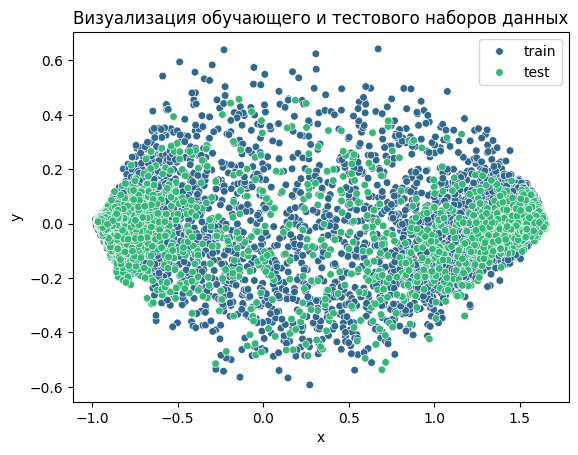

In [101]:
sns.scatterplot(x='x', y='y', hue='marker',  
                data=embeddings_df, s=30, palette='viridis')
plt.title('Визуализация обучающего и тестового наборов данных')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Доля сохраняемой дисперсии первой компонентой составляет почти 98%

In [89]:
pca.explained_variance_ratio_

array([0.97941688, 0.00852008])

Учитывая высокую степень сохранения дисперсии хочется сказать что тестовые данные "немного лучше" разделяются в направлении 
оси х, однако дисперсия не обязательно совпадает с разделением классов (я также посмотрел отдельно эмбеддинги тестовых и обучающих данных в разрезе таргета и ничего примечательного не увидел).  

Попробуем теперь оценить долю объектов в обучающей и тестовой выборках (для мета-модели) в которых у базовый моделей 
"расходились мнения", возможно в тестовой выборке доля таких меньше

In [90]:
# Cреднее значение вероятности
meta_X['mean_pred'] = meta_X.mean(axis=1)

# Маркеры True/False если все модели принимали решение о принадлежности объектов к первому/нулевому классам
meta_X['all_above_threshold'] = (meta_X > 0.5).all(axis=1)
meta_X['all_below_threshold'] = (meta_X < 0.5).all(axis=1)

Доля таких объектов в обучающей выборке

In [102]:
print((len(meta_X[~(meta_X['all_above_threshold'] | 
    meta_X['all_below_threshold'])]) / len(meta_X)) * 100, '%')

8.238687578871462 %


In [96]:
meta_X_test['mean_pred'] = meta_X_test.mean(axis=1)
meta_X_test['all_above_threshold'] = (meta_X_test > 0.5).all(axis=1)
meta_X_test['all_below_threshold'] = (meta_X_test < 0.5).all(axis=1)

В тестовой

In [97]:
print((len(meta_X_test[~(meta_X_test['all_above_threshold'] |  \
    meta_X_test['all_below_threshold'])]) / len(meta_X_test)) * 100, '%')

6.841535965386695 %


Действительно, в обучающей выборке доля объектов, которым хотя бы одна базовая модели предсказывала класс отличный от остальных немного больше чем в тестовой, возможно эти объекты являются более сложными для мета-модели, так как мы могли наблюдать что при уменьшении обучающей выборки мета-модель демонстировала на обучающих данных лучшие метрики, в большей степени привязываясь к обучающей выборке.